In [ ]:
# Mixed new and old data

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, concatenate, Conv2DTranspose
#from keras.utils.vis_utils import plot_model
import keras.backend as K
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import numpy as np
import random
from tensorflow.keras.models import load_model
# Set the random seeds for reproducibility
seed_value = 42
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)



def build_unet(input_shape,input_shape2, seed_value=42):
    
    
    # Create separate input layers for the three inputs
    input_low_geometry = Input(shape=input_shape, name='low_geometry_input')
    input_low_stream = Input(shape=input_shape2, name='low_stream_input')
    input_low_pressure = Input(shape=input_shape2, name='low_pressure_input')

    # Concatenate the three input layers to create a single input
    concatenated_input = concatenate([input_low_geometry, input_low_stream,input_low_pressure], axis=-1)
   

    # Contracting path
    conv1 = Conv2D(64, 3, activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed_value), padding='same')(concatenated_input )
    conv1 = Conv2D(64, 3, activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed_value), padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed_value), padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed_value), padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed_value), padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed_value), padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3, activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed_value), padding='same')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed_value), padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(1024, 3, activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed_value), padding='same')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed_value), padding='same')(conv5)

    # Expanding path
    up6 = Conv2DTranspose(512, 2, strides=(2, 2), padding='same')(conv5)
    up6 = concatenate([up6, conv4])
    conv6 = Conv2D(512, 3, activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed_value), padding='same')(up6)
    conv6 = Conv2D(512, 3, activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed_value), padding='same')(conv6)

    up7 = Conv2DTranspose(256, 2, strides=(2, 2), padding='same')(conv6)
    up7 = concatenate([up7, conv3])
    conv7 = Conv2D(256, 3, activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed_value), padding='same')(up7)
    conv7 = Conv2D(256, 3, activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed_value), padding='same')(conv7)

    up8 = Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv7)
    up8 = concatenate([up8, conv2])
    conv8 = Conv2D(128, 3, activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed_value), padding='same')(up8)
    conv8 = Conv2D(128, 3, activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed_value), padding='same')(conv8)

    up9 = Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv8)
    up9 = concatenate([up9, conv1])
    conv9 = Conv2D(64, 3, activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed_value), padding='same')(up9)
    conv9 = Conv2D(64, 3, activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed_value), padding='same')(conv9)
    
    # Velocity output layer
    velocity_outputs = Conv2D(1, 1, activation='sigmoid', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed_value), name='velocity_output')(conv9)

    # Pressure output layer
    pressure_outputs = Conv2D(1, 1, activation='sigmoid', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed_value), name='pressure_output')(conv9)

    model = Model(inputs=[input_low_geometry,input_low_stream,input_low_pressure], outputs=[pressure_outputs, velocity_outputs])
    return model


def boundary_loss(y_true, y_pred):
    # Extract velocity and pressure from predictions and true values
    velocity_pred = y_pred[0]
    pressure_pred = y_pred[1]
    velocity_true = y_true[0]
    pressure_true = y_true[1]
    
    # Compute max and min values for velocity and pressure
    velocity_pred_max = tf.reduce_max(velocity_pred)
    velocity_pred_min = tf.reduce_min(velocity_pred)
    velocity_true_max = tf.reduce_max(velocity_true)
    velocity_true_min = tf.reduce_min(velocity_true)
    
    pressure_pred_max = tf.reduce_max(pressure_pred)
    pressure_pred_min = tf.reduce_min(pressure_pred)
    pressure_true_max = tf.reduce_max(pressure_true)
    pressure_true_min = tf.reduce_min(pressure_true)
    
    # Compute residuals for max and min values
    velocity_residual = tf.square(velocity_pred_max - velocity_true_max) + tf.square(velocity_pred_min - velocity_true_min)
    pressure_residual = tf.square(pressure_pred_max - pressure_true_max) + tf.square(pressure_pred_min - pressure_true_min)
    
    # Total loss as the sum of residuals
    tloss = (velocity_residual + pressure_residual)/2
    
    return tloss


def data_loss(y_true, y_pred):
    y_true = tf.expand_dims(y_true, axis=-1)
    y_pred = tf.expand_dims(y_pred, axis=-1)
    # Data loss function for velocity and pressure
    d_loss = tf.reduce_mean(tf.square(y_true - y_pred))
    return d_loss





def physical_loss(y_true, y_pred):
    
    # Extract velocity and pressure from predictions and true values
    velocity_pred = y_pred[0]
    pressure_pred = y_pred[1]
    velocity_true = y_true[0]
    pressure_true = y_true[1]
    
    
    # Convert the numpy array to a TensorFlow tensor
    velocity_true = tf.convert_to_tensor(velocity_true, dtype=tf.float32)
    pressure_true = tf.convert_to_tensor(pressure_true, dtype=tf.float32)
    
    
    
    velocity_true = tf.expand_dims(velocity_true, axis=-1)
    pressure_true = tf.expand_dims(pressure_true, axis=-1)
    
    velocity_true = tf.expand_dims(velocity_true, axis=0)
    pressure_true = tf.expand_dims(pressure_true, axis=0)
    
    
    velocity_pred = tf.expand_dims(velocity_pred, axis=-1)
    pressure_pred = tf.expand_dims(pressure_pred, axis=-1)

    velocity_pred = tf.expand_dims(velocity_pred, axis=0)
    pressure_pred = tf.expand_dims(pressure_pred, axis=0)

    

    # Compute gradients
    velocity_gradients_pred = tf.image.image_gradients(velocity_pred)
    pressure_gradients_pred = tf.image.image_gradients(pressure_pred)
    velocity_gradients_true = tf.image.image_gradients(velocity_true)
    pressure_gradients_true = tf.image.image_gradients(pressure_true)

    # Compute divergence of velocity (for continuity equation)
    divergence_velocity_pred = velocity_gradients_pred[0] + velocity_gradients_pred[1]
    divergence_velocity_true = velocity_gradients_true[0] + velocity_gradients_true[1]
    
    divergence_pressure_pred = pressure_gradients_pred[0]+ pressure_gradients_pred[1]
    divergence_pressure_true = pressure_gradients_true[0] + pressure_gradients_true[1]


    # Compute the convective term (u · ∇)u for predicted and true velocity
    convective_term_pred = (
        velocity_pred[0] * velocity_gradients_pred[0] + 
        velocity_pred[0] * velocity_gradients_pred[1]
    )
    convective_term_true = (
        velocity_true[0] * velocity_gradients_true[0] + 
        velocity_true[0] * velocity_gradients_true[1]
    )

    # Compute the viscous term μ∇²u (Laplacian of velocity) for predicted and true velocity
    viscous_term_pred =  (
        tf.image.image_gradients(velocity_gradients_pred[0]) + 
        tf.image.image_gradients(velocity_gradients_pred[1])
    )
    viscous_term_true =  (
        tf.image.image_gradients(velocity_gradients_true[0]) + 
        tf.image.image_gradients(velocity_gradients_true[1])
    )

    # Compute the pressure gradient term ∇p for predicted and true pressure
    pressure_gradient_pred = tf.concat(pressure_gradients_pred, axis=-1)
    pressure_gradient_true = tf.concat(pressure_gradients_true, axis=-1)

    # Compute the momentum residual for predicted and true values
    momentum_residual_pred = (
        convective_term_pred - 
        pressure_gradient_pred + 
        viscous_term_pred
    )
    momentum_residual_true = (
        convective_term_true - 
        pressure_gradient_true + 
        viscous_term_true
    )
    
    
    
    

    # Compute the L2 norm of the momentum residual
    momentum_residual_norm = tf.reduce_mean(tf.square(momentum_residual_pred - momentum_residual_true))

    # Compute the L2 norm of the continuity residual
    continuity_residual_norm = tf.reduce_mean(tf.square(divergence_velocity_pred - divergence_velocity_true))

    # Total physical loss is the sum of momentum and continuity residuals
    physical_loss_value = 0.2*momentum_residual_norm +continuity_residual_norm

    return physical_loss_value

    
    



def total_loss(y_true, y_pred):
    # You can customize the weighting of the data loss and physical loss here
    weight_boundary_loss = 0.02
    weight_data_loss = 0.08
    weight_physical_loss = 0.9
    phy=physical_loss(y_true, y_pred)

    # Calculate the total loss as a combination of data loss and physical loss
    total_loss = (weight_data_loss * data_loss(y_true, y_pred) )+(weight_physical_loss * phy ) + (weight_boundary_loss * boundary_loss(y_true, y_pred) )
    return total_loss
     



# Train the model with your dataset
import os
import numpy as np
from PIL import Image
from keras.callbacks import ModelCheckpoint



lv_folder = 'Low/LVV-new'
hv_folder = 'High/HVV'
lp_folder = 'LPP-new'
hp_folder = 'High/HPP'
lg_folder = 'LG-3C'

# Get the list of file names in each folder
lv_files = [f for f in os.listdir(lv_folder) if f != ".ipynb_checkpoints"]
hv_files = [f for f in os.listdir(hv_folder) if f != ".ipynb_checkpoints"]
lp_files = [f for f in os.listdir(lp_folder) if f != ".ipynb_checkpoints"]
hp_files = [f for f in os.listdir(hp_folder) if f != ".ipynb_checkpoints"]
lg_files = [f for f in os.listdir(lg_folder) if f != ".ipynb_checkpoints"]

# Sort the file names to ensure the order is consistent
lv_files.sort()
hv_files.sort()
lp_files.sort()
hp_files.sort()
lg_files.sort()


# Set the input shape
input_shape = (256, 256, 3)  # Update to 3 channels for color images
input_shape2 = (256, 256, 1)

# Create empty lists to store the data
X_lv = []
X_lp = []
X_lg = []
Y_hv = []
Y_hp = []

# Read the data from the folders
for lv_file, hv_file,lp_file,hp_file,lg_file in zip(lv_files, hv_files,lp_files,hp_files,lg_files):
    try:
        
        # Read the LFV
        lv_image = np.load(os.path.join(lv_folder, lv_file))  # Convert to RGB
        X_lv.append(np.array(lv_image))
        
        # Read the HFV
        hv_image = np.load(os.path.join(hv_folder, hv_file))  # Convert to RGB
        Y_hv.append(np.array(hv_image))

        # Read the LFP
        lp_image = np.load(os.path.join(lp_folder, lp_file))  # Convert to RGB
        X_lp.append(np.array(lp_image))
    
    
        # Read the channel geometry image
        lg_image = Image.open(os.path.join(lg_folder, lg_file)).convert('RGB')  # Convert to RGB
        lg_image = lg_image.resize(input_shape[:2])  # Resize the image
        X_lg.append(np.array(lg_image))
    
        # Read the HFP
        hp_image = np.load(os.path.join(hp_folder, hp_file))  # Convert to RGB
        Y_hp.append(np.array(hp_image))
    except:
        print('')

# Convert the lists to arrays
X_lv = np.array(X_lv) 
X_lp = np.array(X_lp) 
X_lg = np.array(X_lg) / 255.0  # Normalize the channel geometry images
Y_hv = np.array(Y_hv)
Y_hp = np.array(Y_hp)

X_lp = np.nan_to_num(X_lp, nan=0)
X_lv = np.nan_to_num(X_lv, nan=0)

Y_hpt=(Y_hp-np.min(Y_hp))/(np.max(Y_hp)-np.min(Y_hp))
X_lpt=(X_lp-np.min(X_lp))/(np.max(X_lp)-np.min(X_lp))




# Build the U-Net model
model = build_unet(input_shape,input_shape2)



optim = Adam(learning_rate=0.00001)
# Compile the model with the desired loss functions
model.compile(optimizer=optim,
              loss=[total_loss,total_loss])
# Set up checkpoints to save the best model during training
checkpoint_path = 'Saved_Models_Temp/total-Micro-Unet-3-Inputs.h5'
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
# Train the model
epochs = 2400
batch_size = 16
print('start fitting')
model.fit([X_lg,X_lv,X_lpt], [Y_hpt, Y_hv],
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2,
          callbacks=[checkpoint])





start fitting
Epoch 1/2400


2025-01-24 22:37:20.409982: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


142/142 [==============================] - ETA: 0s - loss: 0.0254 - pressure_output_loss: 0.0095 - velocity_output_loss: 0.0159

2025-01-24 22:38:43.220720: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.00551, saving model to Saved_Models/total-Micro-Unet-3-Inputs.h5
142/142 [==============================] - 92s 622ms/step - loss: 0.0254 - pressure_output_loss: 0.0095 - velocity_output_loss: 0.0159 - val_loss: 0.0055 - val_pressure_output_loss: 0.0027 - val_velocity_output_loss: 0.0028
Epoch 2/2400
142/142 [==============================] - ETA: 0s - loss: 0.0037 - pressure_output_loss: 0.0021 - velocity_output_loss: 0.0016
Epoch 2: val_loss improved from 0.00551 to 0.00398, saving model to Saved_Models/total-Micro-Unet-3-Inputs.h5
142/142 [==============================] - 83s 581ms/step - loss: 0.0037 - pressure_output_loss: 0.0021 - velocity_output_loss: 0.0016 - val_loss: 0.0040 - val_pressure_output_loss: 0.0017 - val_velocity_output_loss: 0.0023
Epoch 3/2400
142/142 [==============================] - ETA: 0s - loss: 0.0020 - pressure_output_loss: 0.0011 - velocity_output_loss: 8.9125e-04
Epoch 3: val_loss improved from 0.00398 to 0.0014

Epoch 19/2400
142/142 [==============================] - ETA: 0s - loss: 7.2499e-04 - pressure_output_loss: 2.5886e-04 - velocity_output_loss: 4.6613e-04
Epoch 19: val_loss improved from 0.00037 to 0.00032, saving model to Saved_Models/total-Micro-Unet-3-Inputs.h5
142/142 [==============================] - 89s 630ms/step - loss: 7.2499e-04 - pressure_output_loss: 2.5886e-04 - velocity_output_loss: 4.6613e-04 - val_loss: 3.2286e-04 - val_pressure_output_loss: 2.2994e-04 - val_velocity_output_loss: 9.2916e-05
Epoch 20/2400
142/142 [==============================] - ETA: 0s - loss: 7.1168e-04 - pressure_output_loss: 2.4593e-04 - velocity_output_loss: 4.6576e-04
Epoch 20: val_loss improved from 0.00032 to 0.00030, saving model to Saved_Models/total-Micro-Unet-3-Inputs.h5
142/142 [==============================] - 90s 630ms/step - loss: 7.1168e-04 - pressure_output_loss: 2.4593e-04 - velocity_output_loss: 4.6576e-04 - val_loss: 3.0144e-04 - val_pressure_output_loss: 2.0374e-04 - val_velocit

142/142 [==============================] - 90s 634ms/step - loss: 6.5142e-04 - pressure_output_loss: 1.9928e-04 - velocity_output_loss: 4.5214e-04 - val_loss: 2.5260e-04 - val_pressure_output_loss: 1.6701e-04 - val_velocity_output_loss: 8.5596e-05
Epoch 37/2400
142/142 [==============================] - ETA: 0s - loss: 6.3187e-04 - pressure_output_loss: 1.8994e-04 - velocity_output_loss: 4.4192e-04
Epoch 37: val_loss did not improve from 0.00025
142/142 [==============================] - 89s 628ms/step - loss: 6.3187e-04 - pressure_output_loss: 1.8994e-04 - velocity_output_loss: 4.4192e-04 - val_loss: 2.5830e-04 - val_pressure_output_loss: 1.7577e-04 - val_velocity_output_loss: 8.2529e-05
Epoch 38/2400
142/142 [==============================] - ETA: 0s - loss: 6.3182e-04 - pressure_output_loss: 1.8370e-04 - velocity_output_loss: 4.4812e-04
Epoch 38: val_loss did not improve from 0.00025
142/142 [==============================] - 91s 641ms/step - loss: 6.3182e-04 - pressure_output_loss:

Epoch 54/2400
142/142 [==============================] - ETA: 0s - loss: 5.6070e-04 - pressure_output_loss: 1.4653e-04 - velocity_output_loss: 4.1417e-04
Epoch 54: val_loss did not improve from 0.00022
142/142 [==============================] - 87s 611ms/step - loss: 5.6070e-04 - pressure_output_loss: 1.4653e-04 - velocity_output_loss: 4.1417e-04 - val_loss: 2.2555e-04 - val_pressure_output_loss: 1.4178e-04 - val_velocity_output_loss: 8.3771e-05
Epoch 55/2400
142/142 [==============================] - ETA: 0s - loss: 5.3466e-04 - pressure_output_loss: 1.3695e-04 - velocity_output_loss: 3.9771e-04
Epoch 55: val_loss did not improve from 0.00022
142/142 [==============================] - 88s 618ms/step - loss: 5.3466e-04 - pressure_output_loss: 1.3695e-04 - velocity_output_loss: 3.9771e-04 - val_loss: 2.1934e-04 - val_pressure_output_loss: 1.4057e-04 - val_velocity_output_loss: 7.8773e-05
Epoch 56/2400
142/142 [==============================] - ETA: 0s - loss: 5.3364e-04 - pressure_outpu

142/142 [==============================] - 87s 612ms/step - loss: 4.6595e-04 - pressure_output_loss: 1.0720e-04 - velocity_output_loss: 3.5876e-04 - val_loss: 1.8098e-04 - val_pressure_output_loss: 9.7576e-05 - val_velocity_output_loss: 8.3409e-05
Epoch 72/2400
142/142 [==============================] - ETA: 0s - loss: 4.9539e-04 - pressure_output_loss: 1.0255e-04 - velocity_output_loss: 3.9284e-04
Epoch 72: val_loss did not improve from 0.00018
142/142 [==============================] - 87s 610ms/step - loss: 4.9539e-04 - pressure_output_loss: 1.0255e-04 - velocity_output_loss: 3.9284e-04 - val_loss: 1.9861e-04 - val_pressure_output_loss: 1.2057e-04 - val_velocity_output_loss: 7.8037e-05
Epoch 73/2400
142/142 [==============================] - ETA: 0s - loss: 4.8690e-04 - pressure_output_loss: 1.1048e-04 - velocity_output_loss: 3.7642e-04
Epoch 73: val_loss did not improve from 0.00018
142/142 [==============================] - 88s 622ms/step - loss: 4.8690e-04 - pressure_output_loss:

142/142 [==============================] - 86s 608ms/step - loss: 7.5758e-04 - pressure_output_loss: 3.4636e-04 - velocity_output_loss: 4.1122e-04 - val_loss: 1.2200e-04 - val_pressure_output_loss: 5.5779e-05 - val_velocity_output_loss: 6.6224e-05
Epoch 107/2400
142/142 [==============================] - ETA: 0s - loss: 6.7109e-04 - pressure_output_loss: 3.0069e-04 - velocity_output_loss: 3.7040e-04
Epoch 107: val_loss improved from 0.00012 to 0.00012, saving model to Saved_Models/total-Micro-Unet-3-Inputs.h5
142/142 [==============================] - 88s 618ms/step - loss: 6.7109e-04 - pressure_output_loss: 3.0069e-04 - velocity_output_loss: 3.7040e-04 - val_loss: 1.1741e-04 - val_pressure_output_loss: 5.4528e-05 - val_velocity_output_loss: 6.2883e-05
Epoch 108/2400
142/142 [==============================] - ETA: 0s - loss: 4.2011e-04 - pressure_output_loss: 7.1667e-05 - velocity_output_loss: 3.4844e-04
Epoch 108: val_loss did not improve from 0.00012
142/142 [========================

Epoch 124/2400
142/142 [==============================] - ETA: 0s - loss: 4.0227e-04 - pressure_output_loss: 6.6400e-05 - velocity_output_loss: 3.3587e-04
Epoch 124: val_loss did not improve from 0.00010
142/142 [==============================] - 87s 610ms/step - loss: 4.0227e-04 - pressure_output_loss: 6.6400e-05 - velocity_output_loss: 3.3587e-04 - val_loss: 9.8713e-05 - val_pressure_output_loss: 3.6651e-05 - val_velocity_output_loss: 6.2062e-05
Epoch 125/2400
142/142 [==============================] - ETA: 0s - loss: 4.6979e-04 - pressure_output_loss: 1.2853e-04 - velocity_output_loss: 3.4126e-04
Epoch 125: val_loss improved from 0.00010 to 0.00009, saving model to Saved_Models/total-Micro-Unet-3-Inputs.h5
142/142 [==============================] - 89s 626ms/step - loss: 4.6979e-04 - pressure_output_loss: 1.2853e-04 - velocity_output_loss: 3.4126e-04 - val_loss: 9.3173e-05 - val_pressure_output_loss: 3.5397e-05 - val_velocity_output_loss: 5.7776e-05
Epoch 126/2400
142/142 [=========

142/142 [==============================] - 85s 600ms/step - loss: 3.5471e-04 - pressure_output_loss: 5.3682e-05 - velocity_output_loss: 3.0103e-04 - val_loss: 8.1546e-05 - val_pressure_output_loss: 2.7588e-05 - val_velocity_output_loss: 5.3958e-05
Epoch 142/2400
142/142 [==============================] - ETA: 0s - loss: 3.6672e-04 - pressure_output_loss: 5.9359e-05 - velocity_output_loss: 3.0736e-04
Epoch 142: val_loss improved from 0.00008 to 0.00008, saving model to Saved_Models/total-Micro-Unet-3-Inputs.h5
142/142 [==============================] - 86s 609ms/step - loss: 3.6672e-04 - pressure_output_loss: 5.9359e-05 - velocity_output_loss: 3.0736e-04 - val_loss: 7.8776e-05 - val_pressure_output_loss: 2.5719e-05 - val_velocity_output_loss: 5.3058e-05
Epoch 143/2400
142/142 [==============================] - ETA: 0s - loss: 3.6606e-04 - pressure_output_loss: 6.0409e-05 - velocity_output_loss: 3.0565e-04
Epoch 143: val_loss did not improve from 0.00008
142/142 [========================

Epoch 177/2400
142/142 [==============================] - ETA: 0s - loss: 3.3859e-04 - pressure_output_loss: 6.3385e-05 - velocity_output_loss: 2.7520e-04
Epoch 177: val_loss did not improve from 0.00007
142/142 [==============================] - 87s 611ms/step - loss: 3.3859e-04 - pressure_output_loss: 6.3385e-05 - velocity_output_loss: 2.7520e-04 - val_loss: 8.7020e-05 - val_pressure_output_loss: 2.9761e-05 - val_velocity_output_loss: 5.7259e-05
Epoch 178/2400
142/142 [==============================] - ETA: 0s - loss: 3.4466e-04 - pressure_output_loss: 5.5061e-05 - velocity_output_loss: 2.8960e-04
Epoch 178: val_loss did not improve from 0.00007
142/142 [==============================] - 87s 613ms/step - loss: 3.4466e-04 - pressure_output_loss: 5.5061e-05 - velocity_output_loss: 2.8960e-04 - val_loss: 7.2082e-05 - val_pressure_output_loss: 2.3006e-05 - val_velocity_output_loss: 4.9076e-05
Epoch 179/2400
142/142 [==============================] - ETA: 0s - loss: 3.5924e-04 - pressure_

Epoch 195/2400
142/142 [==============================] - ETA: 0s - loss: 3.4825e-04 - pressure_output_loss: 5.7454e-05 - velocity_output_loss: 2.9079e-04
Epoch 195: val_loss did not improve from 0.00007
142/142 [==============================] - 87s 610ms/step - loss: 3.4825e-04 - pressure_output_loss: 5.7454e-05 - velocity_output_loss: 2.9079e-04 - val_loss: 7.6360e-05 - val_pressure_output_loss: 1.9847e-05 - val_velocity_output_loss: 5.6514e-05
Epoch 196/2400
142/142 [==============================] - ETA: 0s - loss: 3.5750e-04 - pressure_output_loss: 5.6419e-05 - velocity_output_loss: 3.0108e-04
Epoch 196: val_loss did not improve from 0.00007
142/142 [==============================] - 86s 603ms/step - loss: 3.5750e-04 - pressure_output_loss: 5.6419e-05 - velocity_output_loss: 3.0108e-04 - val_loss: 7.2263e-05 - val_pressure_output_loss: 2.1783e-05 - val_velocity_output_loss: 5.0480e-05
Epoch 197/2400
142/142 [==============================] - ETA: 0s - loss: 3.2567e-04 - pressure_

Epoch 213/2400
142/142 [==============================] - ETA: 0s - loss: 5.8074e-04 - pressure_output_loss: 2.6154e-04 - velocity_output_loss: 3.1920e-04
Epoch 213: val_loss did not improve from 0.00006
142/142 [==============================] - 85s 601ms/step - loss: 5.8074e-04 - pressure_output_loss: 2.6154e-04 - velocity_output_loss: 3.1920e-04 - val_loss: 1.7693e-04 - val_pressure_output_loss: 1.0276e-04 - val_velocity_output_loss: 7.4177e-05
Epoch 214/2400
142/142 [==============================] - ETA: 0s - loss: 4.2900e-04 - pressure_output_loss: 1.1663e-04 - velocity_output_loss: 3.1237e-04
Epoch 214: val_loss did not improve from 0.00006
142/142 [==============================] - 85s 598ms/step - loss: 4.2900e-04 - pressure_output_loss: 1.1663e-04 - velocity_output_loss: 3.1237e-04 - val_loss: 7.6127e-05 - val_pressure_output_loss: 2.3620e-05 - val_velocity_output_loss: 5.2507e-05
Epoch 215/2400
142/142 [==============================] - ETA: 0s - loss: 3.3943e-04 - pressure_

Epoch 231/2400
142/142 [==============================] - ETA: 0s - loss: 3.1211e-04 - pressure_output_loss: 4.2633e-05 - velocity_output_loss: 2.6948e-04
Epoch 231: val_loss did not improve from 0.00006
142/142 [==============================] - 86s 605ms/step - loss: 3.1211e-04 - pressure_output_loss: 4.2633e-05 - velocity_output_loss: 2.6948e-04 - val_loss: 6.3076e-05 - val_pressure_output_loss: 1.7810e-05 - val_velocity_output_loss: 4.5266e-05
Epoch 232/2400
142/142 [==============================] - ETA: 0s - loss: 2.8717e-04 - pressure_output_loss: 3.6837e-05 - velocity_output_loss: 2.5033e-04
Epoch 232: val_loss did not improve from 0.00006
142/142 [==============================] - 85s 599ms/step - loss: 2.8717e-04 - pressure_output_loss: 3.6837e-05 - velocity_output_loss: 2.5033e-04 - val_loss: 6.4687e-05 - val_pressure_output_loss: 1.5503e-05 - val_velocity_output_loss: 4.9184e-05
Epoch 233/2400
142/142 [==============================] - ETA: 0s - loss: 2.8919e-04 - pressure_

Epoch 249/2400
142/142 [==============================] - ETA: 0s - loss: 3.3221e-04 - pressure_output_loss: 4.8513e-05 - velocity_output_loss: 2.8370e-04
Epoch 249: val_loss did not improve from 0.00006
142/142 [==============================] - 86s 604ms/step - loss: 3.3221e-04 - pressure_output_loss: 4.8513e-05 - velocity_output_loss: 2.8370e-04 - val_loss: 6.2219e-05 - val_pressure_output_loss: 1.6548e-05 - val_velocity_output_loss: 4.5670e-05
Epoch 250/2400
142/142 [==============================] - ETA: 0s - loss: 3.0266e-04 - pressure_output_loss: 4.4226e-05 - velocity_output_loss: 2.5843e-04
Epoch 250: val_loss did not improve from 0.00006
142/142 [==============================] - 86s 605ms/step - loss: 3.0266e-04 - pressure_output_loss: 4.4226e-05 - velocity_output_loss: 2.5843e-04 - val_loss: 6.1912e-05 - val_pressure_output_loss: 1.6316e-05 - val_velocity_output_loss: 4.5597e-05
Epoch 251/2400
142/142 [==============================] - ETA: 0s - loss: 3.8861e-04 - pressure_

Epoch 267/2400
142/142 [==============================] - ETA: 0s - loss: 3.3847e-04 - pressure_output_loss: 4.6423e-05 - velocity_output_loss: 2.9205e-04
Epoch 267: val_loss did not improve from 0.00006
142/142 [==============================] - 86s 605ms/step - loss: 3.3847e-04 - pressure_output_loss: 4.6423e-05 - velocity_output_loss: 2.9205e-04 - val_loss: 6.4300e-05 - val_pressure_output_loss: 1.7072e-05 - val_velocity_output_loss: 4.7228e-05
Epoch 268/2400
142/142 [==============================] - ETA: 0s - loss: 3.1020e-04 - pressure_output_loss: 4.4778e-05 - velocity_output_loss: 2.6542e-04
Epoch 268: val_loss did not improve from 0.00006
142/142 [==============================] - 85s 598ms/step - loss: 3.1020e-04 - pressure_output_loss: 4.4778e-05 - velocity_output_loss: 2.6542e-04 - val_loss: 6.1089e-05 - val_pressure_output_loss: 1.7343e-05 - val_velocity_output_loss: 4.3746e-05
Epoch 269/2400
142/142 [==============================] - ETA: 0s - loss: 3.1144e-04 - pressure_

Epoch 285/2400
142/142 [==============================] - ETA: 0s - loss: 3.6120e-04 - pressure_output_loss: 7.6028e-05 - velocity_output_loss: 2.8518e-04
Epoch 285: val_loss did not improve from 0.00006
142/142 [==============================] - 85s 598ms/step - loss: 3.6120e-04 - pressure_output_loss: 7.6028e-05 - velocity_output_loss: 2.8518e-04 - val_loss: 5.6321e-05 - val_pressure_output_loss: 1.3432e-05 - val_velocity_output_loss: 4.2890e-05
Epoch 286/2400
142/142 [==============================] - ETA: 0s - loss: 2.8134e-04 - pressure_output_loss: 3.5963e-05 - velocity_output_loss: 2.4538e-04
Epoch 286: val_loss did not improve from 0.00006
142/142 [==============================] - 85s 598ms/step - loss: 2.8134e-04 - pressure_output_loss: 3.5963e-05 - velocity_output_loss: 2.4538e-04 - val_loss: 5.7356e-05 - val_pressure_output_loss: 1.3692e-05 - val_velocity_output_loss: 4.3664e-05
Epoch 287/2400
142/142 [==============================] - ETA: 0s - loss: 2.9855e-04 - pressure_

Epoch 303/2400
142/142 [==============================] - ETA: 0s - loss: 2.9473e-04 - pressure_output_loss: 3.8560e-05 - velocity_output_loss: 2.5617e-04
Epoch 303: val_loss did not improve from 0.00005
142/142 [==============================] - 85s 597ms/step - loss: 2.9473e-04 - pressure_output_loss: 3.8560e-05 - velocity_output_loss: 2.5617e-04 - val_loss: 6.5107e-05 - val_pressure_output_loss: 1.9974e-05 - val_velocity_output_loss: 4.5133e-05
Epoch 304/2400
142/142 [==============================] - ETA: 0s - loss: 2.9330e-04 - pressure_output_loss: 4.0445e-05 - velocity_output_loss: 2.5286e-04
Epoch 304: val_loss did not improve from 0.00005
142/142 [==============================] - 84s 593ms/step - loss: 2.9330e-04 - pressure_output_loss: 4.0445e-05 - velocity_output_loss: 2.5286e-04 - val_loss: 5.7596e-05 - val_pressure_output_loss: 1.4176e-05 - val_velocity_output_loss: 4.3420e-05
Epoch 305/2400
142/142 [==============================] - ETA: 0s - loss: 2.7979e-04 - pressure_

Epoch 339/2400
142/142 [==============================] - ETA: 0s - loss: 2.9516e-04 - pressure_output_loss: 7.4159e-05 - velocity_output_loss: 2.2100e-04
Epoch 339: val_loss did not improve from 0.00005
142/142 [==============================] - 84s 594ms/step - loss: 2.9516e-04 - pressure_output_loss: 7.4159e-05 - velocity_output_loss: 2.2100e-04 - val_loss: 8.0764e-05 - val_pressure_output_loss: 3.9287e-05 - val_velocity_output_loss: 4.1477e-05
Epoch 340/2400
142/142 [==============================] - ETA: 0s - loss: 4.5773e-04 - pressure_output_loss: 2.2248e-04 - velocity_output_loss: 2.3525e-04
Epoch 340: val_loss did not improve from 0.00005
142/142 [==============================] - 84s 593ms/step - loss: 4.5773e-04 - pressure_output_loss: 2.2248e-04 - velocity_output_loss: 2.3525e-04 - val_loss: 5.2657e-05 - val_pressure_output_loss: 1.2518e-05 - val_velocity_output_loss: 4.0139e-05
Epoch 341/2400
142/142 [==============================] - ETA: 0s - loss: 2.6020e-04 - pressure_

Epoch 357/2400
142/142 [==============================] - ETA: 0s - loss: 2.5638e-04 - pressure_output_loss: 4.1617e-05 - velocity_output_loss: 2.1477e-04
Epoch 357: val_loss did not improve from 0.00005
142/142 [==============================] - 85s 600ms/step - loss: 2.5638e-04 - pressure_output_loss: 4.1617e-05 - velocity_output_loss: 2.1477e-04 - val_loss: 5.4779e-05 - val_pressure_output_loss: 1.3917e-05 - val_velocity_output_loss: 4.0862e-05
Epoch 358/2400
142/142 [==============================] - ETA: 0s - loss: 2.9328e-04 - pressure_output_loss: 7.2478e-05 - velocity_output_loss: 2.2080e-04
Epoch 358: val_loss did not improve from 0.00005
142/142 [==============================] - 85s 596ms/step - loss: 2.9328e-04 - pressure_output_loss: 7.2478e-05 - velocity_output_loss: 2.2080e-04 - val_loss: 5.8801e-05 - val_pressure_output_loss: 1.4550e-05 - val_velocity_output_loss: 4.4251e-05
Epoch 359/2400
142/142 [==============================] - ETA: 0s - loss: 2.3891e-04 - pressure_

Epoch 375/2400
142/142 [==============================] - ETA: 0s - loss: 2.2700e-04 - pressure_output_loss: 3.4205e-05 - velocity_output_loss: 1.9280e-04
Epoch 375: val_loss did not improve from 0.00005
142/142 [==============================] - 86s 606ms/step - loss: 2.2700e-04 - pressure_output_loss: 3.4205e-05 - velocity_output_loss: 1.9280e-04 - val_loss: 4.7380e-05 - val_pressure_output_loss: 1.2483e-05 - val_velocity_output_loss: 3.4897e-05
Epoch 376/2400
142/142 [==============================] - ETA: 0s - loss: 2.4411e-04 - pressure_output_loss: 3.9064e-05 - velocity_output_loss: 2.0505e-04
Epoch 376: val_loss did not improve from 0.00005
142/142 [==============================] - 87s 615ms/step - loss: 2.4411e-04 - pressure_output_loss: 3.9064e-05 - velocity_output_loss: 2.0505e-04 - val_loss: 4.8857e-05 - val_pressure_output_loss: 1.0894e-05 - val_velocity_output_loss: 3.7963e-05
Epoch 377/2400
142/142 [==============================] - ETA: 0s - loss: 2.5005e-04 - pressure_

Epoch 393/2400
142/142 [==============================] - ETA: 0s - loss: 2.2050e-04 - pressure_output_loss: 3.1832e-05 - velocity_output_loss: 1.8867e-04
Epoch 393: val_loss did not improve from 0.00004
142/142 [==============================] - 84s 594ms/step - loss: 2.2050e-04 - pressure_output_loss: 3.1832e-05 - velocity_output_loss: 1.8867e-04 - val_loss: 7.3656e-05 - val_pressure_output_loss: 2.6110e-05 - val_velocity_output_loss: 4.7546e-05
Epoch 394/2400
142/142 [==============================] - ETA: 0s - loss: 3.7659e-04 - pressure_output_loss: 1.6809e-04 - velocity_output_loss: 2.0850e-04
Epoch 394: val_loss did not improve from 0.00004
142/142 [==============================] - 84s 591ms/step - loss: 3.7659e-04 - pressure_output_loss: 1.6809e-04 - velocity_output_loss: 2.0850e-04 - val_loss: 5.7394e-05 - val_pressure_output_loss: 1.8279e-05 - val_velocity_output_loss: 3.9115e-05
Epoch 395/2400
142/142 [==============================] - ETA: 0s - loss: 2.3444e-04 - pressure_

Epoch 411/2400
142/142 [==============================] - ETA: 0s - loss: 2.1113e-04 - pressure_output_loss: 3.6249e-05 - velocity_output_loss: 1.7488e-04
Epoch 411: val_loss did not improve from 0.00004
142/142 [==============================] - 83s 587ms/step - loss: 2.1113e-04 - pressure_output_loss: 3.6249e-05 - velocity_output_loss: 1.7488e-04 - val_loss: 4.6864e-05 - val_pressure_output_loss: 1.1559e-05 - val_velocity_output_loss: 3.5305e-05
Epoch 412/2400
142/142 [==============================] - ETA: 0s - loss: 2.0208e-04 - pressure_output_loss: 3.2095e-05 - velocity_output_loss: 1.6999e-04
Epoch 412: val_loss did not improve from 0.00004
142/142 [==============================] - 83s 587ms/step - loss: 2.0208e-04 - pressure_output_loss: 3.2095e-05 - velocity_output_loss: 1.6999e-04 - val_loss: 4.7528e-05 - val_pressure_output_loss: 1.2556e-05 - val_velocity_output_loss: 3.4972e-05
Epoch 413/2400
142/142 [==============================] - ETA: 0s - loss: 2.1101e-04 - pressure_

Epoch 429/2400
142/142 [==============================] - ETA: 0s - loss: 2.1736e-04 - pressure_output_loss: 3.8925e-05 - velocity_output_loss: 1.7843e-04
Epoch 429: val_loss did not improve from 0.00004
142/142 [==============================] - 84s 591ms/step - loss: 2.1736e-04 - pressure_output_loss: 3.8925e-05 - velocity_output_loss: 1.7843e-04 - val_loss: 5.3088e-05 - val_pressure_output_loss: 1.3047e-05 - val_velocity_output_loss: 4.0041e-05
Epoch 430/2400
142/142 [==============================] - ETA: 0s - loss: 2.4572e-04 - pressure_output_loss: 6.9580e-05 - velocity_output_loss: 1.7614e-04
Epoch 430: val_loss did not improve from 0.00004
142/142 [==============================] - 84s 588ms/step - loss: 2.4572e-04 - pressure_output_loss: 6.9580e-05 - velocity_output_loss: 1.7614e-04 - val_loss: 4.4630e-05 - val_pressure_output_loss: 1.2503e-05 - val_velocity_output_loss: 3.2127e-05
Epoch 431/2400
142/142 [==============================] - ETA: 0s - loss: 2.1600e-04 - pressure_

Epoch 447/2400
142/142 [==============================] - ETA: 0s - loss: 1.8145e-04 - pressure_output_loss: 2.9545e-05 - velocity_output_loss: 1.5191e-04
Epoch 447: val_loss did not improve from 0.00004
142/142 [==============================] - 84s 590ms/step - loss: 1.8145e-04 - pressure_output_loss: 2.9545e-05 - velocity_output_loss: 1.5191e-04 - val_loss: 4.7045e-05 - val_pressure_output_loss: 1.1555e-05 - val_velocity_output_loss: 3.5490e-05
Epoch 448/2400
142/142 [==============================] - ETA: 0s - loss: 2.0745e-04 - pressure_output_loss: 3.6540e-05 - velocity_output_loss: 1.7091e-04
Epoch 448: val_loss did not improve from 0.00004
142/142 [==============================] - 84s 595ms/step - loss: 2.0745e-04 - pressure_output_loss: 3.6540e-05 - velocity_output_loss: 1.7091e-04 - val_loss: 4.5937e-05 - val_pressure_output_loss: 1.1615e-05 - val_velocity_output_loss: 3.4322e-05
Epoch 449/2400
142/142 [==============================] - ETA: 0s - loss: 1.9545e-04 - pressure_

Epoch 465/2400
142/142 [==============================] - ETA: 0s - loss: 1.6909e-04 - pressure_output_loss: 2.9631e-05 - velocity_output_loss: 1.3946e-04
Epoch 465: val_loss did not improve from 0.00004
142/142 [==============================] - 85s 597ms/step - loss: 1.6909e-04 - pressure_output_loss: 2.9631e-05 - velocity_output_loss: 1.3946e-04 - val_loss: 4.7980e-05 - val_pressure_output_loss: 1.2977e-05 - val_velocity_output_loss: 3.5003e-05
Epoch 466/2400
142/142 [==============================] - ETA: 0s - loss: 2.2100e-04 - pressure_output_loss: 6.0839e-05 - velocity_output_loss: 1.6016e-04
Epoch 466: val_loss did not improve from 0.00004
142/142 [==============================] - 84s 594ms/step - loss: 2.2100e-04 - pressure_output_loss: 6.0839e-05 - velocity_output_loss: 1.6016e-04 - val_loss: 4.8957e-05 - val_pressure_output_loss: 1.6370e-05 - val_velocity_output_loss: 3.2587e-05
Epoch 467/2400
142/142 [==============================] - ETA: 0s - loss: 1.8224e-04 - pressure_

Epoch 483/2400
142/142 [==============================] - ETA: 0s - loss: 1.9250e-04 - pressure_output_loss: 3.8396e-05 - velocity_output_loss: 1.5410e-04
Epoch 483: val_loss did not improve from 0.00004
142/142 [==============================] - 85s 601ms/step - loss: 1.9250e-04 - pressure_output_loss: 3.8396e-05 - velocity_output_loss: 1.5410e-04 - val_loss: 5.1296e-05 - val_pressure_output_loss: 1.4988e-05 - val_velocity_output_loss: 3.6308e-05
Epoch 484/2400
142/142 [==============================] - ETA: 0s - loss: 1.7566e-04 - pressure_output_loss: 3.0206e-05 - velocity_output_loss: 1.4545e-04
Epoch 484: val_loss improved from 0.00004 to 0.00004, saving model to Saved_Models/total-Micro-Unet-3-Inputs.h5
142/142 [==============================] - 85s 600ms/step - loss: 1.7566e-04 - pressure_output_loss: 3.0206e-05 - velocity_output_loss: 1.4545e-04 - val_loss: 3.6746e-05 - val_pressure_output_loss: 9.6815e-06 - val_velocity_output_loss: 2.7064e-05
Epoch 485/2400
142/142 [=========

Epoch 501/2400
142/142 [==============================] - ETA: 0s - loss: 2.2861e-04 - pressure_output_loss: 7.1558e-05 - velocity_output_loss: 1.5705e-04
Epoch 501: val_loss did not improve from 0.00004
142/142 [==============================] - 89s 628ms/step - loss: 2.2861e-04 - pressure_output_loss: 7.1558e-05 - velocity_output_loss: 1.5705e-04 - val_loss: 3.8804e-05 - val_pressure_output_loss: 1.0765e-05 - val_velocity_output_loss: 2.8038e-05
Epoch 502/2400
142/142 [==============================] - ETA: 0s - loss: 1.8464e-04 - pressure_output_loss: 4.1933e-05 - velocity_output_loss: 1.4271e-04
Epoch 502: val_loss did not improve from 0.00004
142/142 [==============================] - 88s 620ms/step - loss: 1.8464e-04 - pressure_output_loss: 4.1933e-05 - velocity_output_loss: 1.4271e-04 - val_loss: 4.0802e-05 - val_pressure_output_loss: 1.0712e-05 - val_velocity_output_loss: 3.0090e-05
Epoch 503/2400
142/142 [==============================] - ETA: 0s - loss: 1.6132e-04 - pressure_

Epoch 519/2400
142/142 [==============================] - ETA: 0s - loss: 1.6210e-04 - pressure_output_loss: 3.0248e-05 - velocity_output_loss: 1.3185e-04
Epoch 519: val_loss did not improve from 0.00004
142/142 [==============================] - 86s 605ms/step - loss: 1.6210e-04 - pressure_output_loss: 3.0248e-05 - velocity_output_loss: 1.3185e-04 - val_loss: 3.6382e-05 - val_pressure_output_loss: 9.4795e-06 - val_velocity_output_loss: 2.6902e-05
Epoch 520/2400
142/142 [==============================] - ETA: 0s - loss: 1.9054e-04 - pressure_output_loss: 4.9351e-05 - velocity_output_loss: 1.4119e-04
Epoch 520: val_loss did not improve from 0.00004
142/142 [==============================] - 85s 598ms/step - loss: 1.9054e-04 - pressure_output_loss: 4.9351e-05 - velocity_output_loss: 1.4119e-04 - val_loss: 3.8173e-05 - val_pressure_output_loss: 1.2008e-05 - val_velocity_output_loss: 2.6165e-05
Epoch 521/2400
142/142 [==============================] - ETA: 0s - loss: 1.8242e-04 - pressure_

Epoch 537/2400
142/142 [==============================] - ETA: 0s - loss: 1.4913e-04 - pressure_output_loss: 2.7273e-05 - velocity_output_loss: 1.2185e-04
Epoch 537: val_loss did not improve from 0.00003
142/142 [==============================] - 86s 604ms/step - loss: 1.4913e-04 - pressure_output_loss: 2.7273e-05 - velocity_output_loss: 1.2185e-04 - val_loss: 4.0562e-05 - val_pressure_output_loss: 1.3958e-05 - val_velocity_output_loss: 2.6604e-05
Epoch 538/2400
142/142 [==============================] - ETA: 0s - loss: 1.4358e-04 - pressure_output_loss: 2.4702e-05 - velocity_output_loss: 1.1888e-04
Epoch 538: val_loss improved from 0.00003 to 0.00003, saving model to Saved_Models/total-Micro-Unet-3-Inputs.h5
142/142 [==============================] - 86s 604ms/step - loss: 1.4358e-04 - pressure_output_loss: 2.4702e-05 - velocity_output_loss: 1.1888e-04 - val_loss: 3.3172e-05 - val_pressure_output_loss: 9.8875e-06 - val_velocity_output_loss: 2.3285e-05
Epoch 539/2400
142/142 [=========

Epoch 555/2400
142/142 [==============================] - ETA: 0s - loss: 1.5058e-04 - pressure_output_loss: 2.8493e-05 - velocity_output_loss: 1.2209e-04
Epoch 555: val_loss did not improve from 0.00003
142/142 [==============================] - 88s 617ms/step - loss: 1.5058e-04 - pressure_output_loss: 2.8493e-05 - velocity_output_loss: 1.2209e-04 - val_loss: 3.3771e-05 - val_pressure_output_loss: 9.3756e-06 - val_velocity_output_loss: 2.4396e-05
Epoch 556/2400
142/142 [==============================] - ETA: 0s - loss: 1.4927e-04 - pressure_output_loss: 2.9604e-05 - velocity_output_loss: 1.1967e-04
Epoch 556: val_loss did not improve from 0.00003
142/142 [==============================] - 88s 617ms/step - loss: 1.4927e-04 - pressure_output_loss: 2.9604e-05 - velocity_output_loss: 1.1967e-04 - val_loss: 3.5515e-05 - val_pressure_output_loss: 1.1087e-05 - val_velocity_output_loss: 2.4428e-05
Epoch 557/2400
142/142 [==============================] - ETA: 0s - loss: 1.6010e-04 - pressure_

Epoch 573/2400
142/142 [==============================] - ETA: 0s - loss: 1.4721e-04 - pressure_output_loss: 2.9682e-05 - velocity_output_loss: 1.1752e-04
Epoch 573: val_loss did not improve from 0.00003
142/142 [==============================] - 88s 617ms/step - loss: 1.4721e-04 - pressure_output_loss: 2.9682e-05 - velocity_output_loss: 1.1752e-04 - val_loss: 3.5959e-05 - val_pressure_output_loss: 1.1370e-05 - val_velocity_output_loss: 2.4589e-05
Epoch 574/2400
142/142 [==============================] - ETA: 0s - loss: 1.5296e-04 - pressure_output_loss: 2.9151e-05 - velocity_output_loss: 1.2381e-04
Epoch 574: val_loss improved from 0.00003 to 0.00003, saving model to Saved_Models/total-Micro-Unet-3-Inputs.h5
142/142 [==============================] - 90s 633ms/step - loss: 1.5296e-04 - pressure_output_loss: 2.9151e-05 - velocity_output_loss: 1.2381e-04 - val_loss: 3.0107e-05 - val_pressure_output_loss: 8.6671e-06 - val_velocity_output_loss: 2.1440e-05
Epoch 575/2400
142/142 [=========

Epoch 591/2400
142/142 [==============================] - ETA: 0s - loss: 1.2752e-04 - pressure_output_loss: 2.6023e-05 - velocity_output_loss: 1.0149e-04
Epoch 591: val_loss did not improve from 0.00003
142/142 [==============================] - 85s 601ms/step - loss: 1.2752e-04 - pressure_output_loss: 2.6023e-05 - velocity_output_loss: 1.0149e-04 - val_loss: 3.0614e-05 - val_pressure_output_loss: 9.3595e-06 - val_velocity_output_loss: 2.1254e-05
Epoch 592/2400
142/142 [==============================] - ETA: 0s - loss: 1.3784e-04 - pressure_output_loss: 2.5378e-05 - velocity_output_loss: 1.1247e-04
Epoch 592: val_loss did not improve from 0.00003
142/142 [==============================] - 85s 602ms/step - loss: 1.3784e-04 - pressure_output_loss: 2.5378e-05 - velocity_output_loss: 1.1247e-04 - val_loss: 2.9139e-05 - val_pressure_output_loss: 7.8492e-06 - val_velocity_output_loss: 2.1290e-05
Epoch 593/2400
142/142 [==============================] - ETA: 0s - loss: 2.7746e-04 - pressure_

Epoch 609/2400
142/142 [==============================] - ETA: 0s - loss: 1.3339e-04 - pressure_output_loss: 2.4430e-05 - velocity_output_loss: 1.0896e-04
Epoch 609: val_loss did not improve from 0.00003
142/142 [==============================] - 85s 598ms/step - loss: 1.3339e-04 - pressure_output_loss: 2.4430e-05 - velocity_output_loss: 1.0896e-04 - val_loss: 3.1069e-05 - val_pressure_output_loss: 9.5173e-06 - val_velocity_output_loss: 2.1551e-05
Epoch 610/2400
142/142 [==============================] - ETA: 0s - loss: 2.8182e-04 - pressure_output_loss: 1.4845e-04 - velocity_output_loss: 1.3337e-04
Epoch 610: val_loss did not improve from 0.00003
142/142 [==============================] - 85s 598ms/step - loss: 2.8182e-04 - pressure_output_loss: 1.4845e-04 - velocity_output_loss: 1.3337e-04 - val_loss: 3.0268e-05 - val_pressure_output_loss: 9.9831e-06 - val_velocity_output_loss: 2.0285e-05
Epoch 611/2400
142/142 [==============================] - ETA: 0s - loss: 1.3511e-04 - pressure_

Epoch 627/2400
142/142 [==============================] - ETA: 0s - loss: 1.2827e-04 - pressure_output_loss: 2.4384e-05 - velocity_output_loss: 1.0388e-04
Epoch 627: val_loss did not improve from 0.00003
142/142 [==============================] - 86s 604ms/step - loss: 1.2827e-04 - pressure_output_loss: 2.4384e-05 - velocity_output_loss: 1.0388e-04 - val_loss: 2.9877e-05 - val_pressure_output_loss: 8.6610e-06 - val_velocity_output_loss: 2.1216e-05
Epoch 628/2400
142/142 [==============================] - ETA: 0s - loss: 1.3578e-04 - pressure_output_loss: 2.9939e-05 - velocity_output_loss: 1.0584e-04
Epoch 628: val_loss did not improve from 0.00003
142/142 [==============================] - 85s 598ms/step - loss: 1.3578e-04 - pressure_output_loss: 2.9939e-05 - velocity_output_loss: 1.0584e-04 - val_loss: 2.9366e-05 - val_pressure_output_loss: 9.5171e-06 - val_velocity_output_loss: 1.9849e-05
Epoch 629/2400
142/142 [==============================] - ETA: 0s - loss: 1.2779e-04 - pressure_

Epoch 645/2400
142/142 [==============================] - ETA: 0s - loss: 2.5450e-04 - pressure_output_loss: 1.4068e-04 - velocity_output_loss: 1.1382e-04
Epoch 645: val_loss did not improve from 0.00003
142/142 [==============================] - 86s 608ms/step - loss: 2.5450e-04 - pressure_output_loss: 1.4068e-04 - velocity_output_loss: 1.1382e-04 - val_loss: 4.3267e-05 - val_pressure_output_loss: 1.9073e-05 - val_velocity_output_loss: 2.4194e-05
Epoch 646/2400
142/142 [==============================] - ETA: 0s - loss: 1.4527e-04 - pressure_output_loss: 3.3314e-05 - velocity_output_loss: 1.1196e-04
Epoch 646: val_loss did not improve from 0.00003
142/142 [==============================] - 86s 609ms/step - loss: 1.4527e-04 - pressure_output_loss: 3.3314e-05 - velocity_output_loss: 1.1196e-04 - val_loss: 2.7936e-05 - val_pressure_output_loss: 8.1991e-06 - val_velocity_output_loss: 1.9737e-05
Epoch 647/2400
142/142 [==============================] - ETA: 0s - loss: 2.8127e-04 - pressure_

Epoch 663/2400
142/142 [==============================] - ETA: 0s - loss: 1.2112e-04 - pressure_output_loss: 2.1739e-05 - velocity_output_loss: 9.9385e-05
Epoch 663: val_loss did not improve from 0.00003
142/142 [==============================] - 91s 643ms/step - loss: 1.2112e-04 - pressure_output_loss: 2.1739e-05 - velocity_output_loss: 9.9385e-05 - val_loss: 2.7071e-05 - val_pressure_output_loss: 8.1316e-06 - val_velocity_output_loss: 1.8940e-05
Epoch 664/2400
142/142 [==============================] - ETA: 0s - loss: 1.3564e-04 - pressure_output_loss: 3.0429e-05 - velocity_output_loss: 1.0521e-04
Epoch 664: val_loss did not improve from 0.00003
142/142 [==============================] - 92s 646ms/step - loss: 1.3564e-04 - pressure_output_loss: 3.0429e-05 - velocity_output_loss: 1.0521e-04 - val_loss: 2.5869e-05 - val_pressure_output_loss: 7.3525e-06 - val_velocity_output_loss: 1.8517e-05
Epoch 665/2400
142/142 [==============================] - ETA: 0s - loss: 1.3425e-04 - pressure_

Epoch 699/2400
142/142 [==============================] - ETA: 0s - loss: 1.2543e-04 - pressure_output_loss: 2.8402e-05 - velocity_output_loss: 9.7033e-05
Epoch 699: val_loss did not improve from 0.00002
142/142 [==============================] - 88s 619ms/step - loss: 1.2543e-04 - pressure_output_loss: 2.8402e-05 - velocity_output_loss: 9.7033e-05 - val_loss: 2.5074e-05 - val_pressure_output_loss: 7.8112e-06 - val_velocity_output_loss: 1.7263e-05
Epoch 700/2400
142/142 [==============================] - ETA: 0s - loss: 2.2009e-04 - pressure_output_loss: 1.2032e-04 - velocity_output_loss: 9.9776e-05
Epoch 700: val_loss did not improve from 0.00002
142/142 [==============================] - 87s 614ms/step - loss: 2.2009e-04 - pressure_output_loss: 1.2032e-04 - velocity_output_loss: 9.9776e-05 - val_loss: 3.2267e-05 - val_pressure_output_loss: 1.2083e-05 - val_velocity_output_loss: 2.0184e-05
Epoch 701/2400
142/142 [==============================] - ETA: 0s - loss: 2.9432e-04 - pressure_

Epoch 717/2400
142/142 [==============================] - ETA: 0s - loss: 1.0644e-04 - pressure_output_loss: 2.0404e-05 - velocity_output_loss: 8.6037e-05
Epoch 717: val_loss did not improve from 0.00002
142/142 [==============================] - 88s 623ms/step - loss: 1.0644e-04 - pressure_output_loss: 2.0404e-05 - velocity_output_loss: 8.6037e-05 - val_loss: 2.4673e-05 - val_pressure_output_loss: 7.4073e-06 - val_velocity_output_loss: 1.7266e-05
Epoch 718/2400
142/142 [==============================] - ETA: 0s - loss: 1.0319e-04 - pressure_output_loss: 1.9384e-05 - velocity_output_loss: 8.3807e-05
Epoch 718: val_loss did not improve from 0.00002
142/142 [==============================] - 89s 626ms/step - loss: 1.0319e-04 - pressure_output_loss: 1.9384e-05 - velocity_output_loss: 8.3807e-05 - val_loss: 2.3805e-05 - val_pressure_output_loss: 6.6738e-06 - val_velocity_output_loss: 1.7131e-05
Epoch 719/2400
142/142 [==============================] - ETA: 0s - loss: 1.2149e-04 - pressure_

Epoch 735/2400
142/142 [==============================] - ETA: 0s - loss: 1.0782e-04 - pressure_output_loss: 2.0217e-05 - velocity_output_loss: 8.7607e-05
Epoch 735: val_loss did not improve from 0.00002
142/142 [==============================] - 87s 610ms/step - loss: 1.0782e-04 - pressure_output_loss: 2.0217e-05 - velocity_output_loss: 8.7607e-05 - val_loss: 2.6221e-05 - val_pressure_output_loss: 6.8118e-06 - val_velocity_output_loss: 1.9409e-05
Epoch 736/2400
142/142 [==============================] - ETA: 0s - loss: 1.5604e-04 - pressure_output_loss: 6.0250e-05 - velocity_output_loss: 9.5785e-05
Epoch 736: val_loss did not improve from 0.00002
142/142 [==============================] - 87s 615ms/step - loss: 1.5604e-04 - pressure_output_loss: 6.0250e-05 - velocity_output_loss: 9.5785e-05 - val_loss: 2.4544e-05 - val_pressure_output_loss: 7.0006e-06 - val_velocity_output_loss: 1.7544e-05
Epoch 737/2400
142/142 [==============================] - ETA: 0s - loss: 1.1321e-04 - pressure_

Epoch 753/2400
142/142 [==============================] - ETA: 0s - loss: 1.1166e-04 - pressure_output_loss: 2.1297e-05 - velocity_output_loss: 9.0358e-05
Epoch 753: val_loss did not improve from 0.00002
142/142 [==============================] - 85s 599ms/step - loss: 1.1166e-04 - pressure_output_loss: 2.1297e-05 - velocity_output_loss: 9.0358e-05 - val_loss: 2.4012e-05 - val_pressure_output_loss: 7.3183e-06 - val_velocity_output_loss: 1.6694e-05
Epoch 754/2400
142/142 [==============================] - ETA: 0s - loss: 1.0338e-04 - pressure_output_loss: 1.9596e-05 - velocity_output_loss: 8.3785e-05
Epoch 754: val_loss improved from 0.00002 to 0.00002, saving model to Saved_Models/total-Micro-Unet-3-Inputs.h5
142/142 [==============================] - 85s 602ms/step - loss: 1.0338e-04 - pressure_output_loss: 1.9596e-05 - velocity_output_loss: 8.3785e-05 - val_loss: 2.2791e-05 - val_pressure_output_loss: 6.6755e-06 - val_velocity_output_loss: 1.6115e-05
Epoch 755/2400
142/142 [=========

Epoch 771/2400
142/142 [==============================] - ETA: 0s - loss: 1.4956e-04 - pressure_output_loss: 5.7456e-05 - velocity_output_loss: 9.2108e-05
Epoch 771: val_loss did not improve from 0.00002
142/142 [==============================] - 86s 603ms/step - loss: 1.4956e-04 - pressure_output_loss: 5.7456e-05 - velocity_output_loss: 9.2108e-05 - val_loss: 3.7587e-05 - val_pressure_output_loss: 1.3195e-05 - val_velocity_output_loss: 2.4392e-05
Epoch 772/2400
142/142 [==============================] - ETA: 0s - loss: 1.2243e-04 - pressure_output_loss: 2.7766e-05 - velocity_output_loss: 9.4665e-05
Epoch 772: val_loss did not improve from 0.00002
142/142 [==============================] - 86s 605ms/step - loss: 1.2243e-04 - pressure_output_loss: 2.7766e-05 - velocity_output_loss: 9.4665e-05 - val_loss: 2.3786e-05 - val_pressure_output_loss: 6.6945e-06 - val_velocity_output_loss: 1.7091e-05
Epoch 773/2400
142/142 [==============================] - ETA: 0s - loss: 1.0369e-04 - pressure_

Epoch 789/2400
142/142 [==============================] - ETA: 0s - loss: 1.0032e-04 - pressure_output_loss: 2.0329e-05 - velocity_output_loss: 7.9989e-05
Epoch 789: val_loss did not improve from 0.00002
142/142 [==============================] - 89s 624ms/step - loss: 1.0032e-04 - pressure_output_loss: 2.0329e-05 - velocity_output_loss: 7.9989e-05 - val_loss: 2.3540e-05 - val_pressure_output_loss: 7.4831e-06 - val_velocity_output_loss: 1.6057e-05
Epoch 790/2400
142/142 [==============================] - ETA: 0s - loss: 1.1345e-04 - pressure_output_loss: 2.7217e-05 - velocity_output_loss: 8.6236e-05
Epoch 790: val_loss did not improve from 0.00002
142/142 [==============================] - 88s 620ms/step - loss: 1.1345e-04 - pressure_output_loss: 2.7217e-05 - velocity_output_loss: 8.6236e-05 - val_loss: 2.3850e-05 - val_pressure_output_loss: 6.9711e-06 - val_velocity_output_loss: 1.6879e-05
Epoch 791/2400
142/142 [==============================] - ETA: 0s - loss: 9.9397e-05 - pressure_

142/142 [==============================] - ETA: 0s - loss: 9.8050e-05 - pressure_output_loss: 1.9737e-05 - velocity_output_loss: 7.8313e-05
Epoch 825: val_loss did not improve from 0.00002
142/142 [==============================] - 85s 599ms/step - loss: 9.8050e-05 - pressure_output_loss: 1.9737e-05 - velocity_output_loss: 7.8313e-05 - val_loss: 2.3928e-05 - val_pressure_output_loss: 8.1103e-06 - val_velocity_output_loss: 1.5818e-05
Epoch 826/2400
142/142 [==============================] - ETA: 0s - loss: 1.5501e-04 - pressure_output_loss: 6.1411e-05 - velocity_output_loss: 9.3603e-05
Epoch 826: val_loss did not improve from 0.00002
142/142 [==============================] - 85s 599ms/step - loss: 1.5501e-04 - pressure_output_loss: 6.1411e-05 - velocity_output_loss: 9.3603e-05 - val_loss: 2.3295e-05 - val_pressure_output_loss: 7.3072e-06 - val_velocity_output_loss: 1.5988e-05
Epoch 827/2400
142/142 [==============================] - ETA: 0s - loss: 9.5064e-05 - pressure_output_loss: 2.

Epoch 843/2400
142/142 [==============================] - ETA: 0s - loss: 1.1013e-04 - pressure_output_loss: 3.0486e-05 - velocity_output_loss: 7.9641e-05
Epoch 843: val_loss did not improve from 0.00002
142/142 [==============================] - 85s 599ms/step - loss: 1.1013e-04 - pressure_output_loss: 3.0486e-05 - velocity_output_loss: 7.9641e-05 - val_loss: 2.2244e-05 - val_pressure_output_loss: 6.3269e-06 - val_velocity_output_loss: 1.5917e-05
Epoch 844/2400
142/142 [==============================] - ETA: 0s - loss: 1.3410e-04 - pressure_output_loss: 5.2473e-05 - velocity_output_loss: 8.1631e-05
Epoch 844: val_loss did not improve from 0.00002
142/142 [==============================] - 85s 601ms/step - loss: 1.3410e-04 - pressure_output_loss: 5.2473e-05 - velocity_output_loss: 8.1631e-05 - val_loss: 7.0735e-05 - val_pressure_output_loss: 3.9947e-05 - val_velocity_output_loss: 3.0787e-05
Epoch 845/2400
142/142 [==============================] - ETA: 0s - loss: 2.5591e-04 - pressure_

Epoch 861/2400
142/142 [==============================] - ETA: 0s - loss: 9.6680e-05 - pressure_output_loss: 2.1647e-05 - velocity_output_loss: 7.5032e-05
Epoch 861: val_loss did not improve from 0.00002
142/142 [==============================] - 87s 612ms/step - loss: 9.6680e-05 - pressure_output_loss: 2.1647e-05 - velocity_output_loss: 7.5032e-05 - val_loss: 2.1587e-05 - val_pressure_output_loss: 7.2041e-06 - val_velocity_output_loss: 1.4383e-05
Epoch 862/2400
142/142 [==============================] - ETA: 0s - loss: 8.8996e-05 - pressure_output_loss: 1.7583e-05 - velocity_output_loss: 7.1413e-05
Epoch 862: val_loss improved from 0.00002 to 0.00002, saving model to Saved_Models/total-Micro-Unet-3-Inputs.h5
142/142 [==============================] - 86s 608ms/step - loss: 8.8996e-05 - pressure_output_loss: 1.7583e-05 - velocity_output_loss: 7.1413e-05 - val_loss: 2.0155e-05 - val_pressure_output_loss: 5.7000e-06 - val_velocity_output_loss: 1.4455e-05
Epoch 863/2400
142/142 [=========

Epoch 879/2400
142/142 [==============================] - ETA: 0s - loss: 9.9652e-05 - pressure_output_loss: 2.1697e-05 - velocity_output_loss: 7.7955e-05
Epoch 879: val_loss did not improve from 0.00002
142/142 [==============================] - 91s 644ms/step - loss: 9.9652e-05 - pressure_output_loss: 2.1697e-05 - velocity_output_loss: 7.7955e-05 - val_loss: 2.0586e-05 - val_pressure_output_loss: 5.8666e-06 - val_velocity_output_loss: 1.4720e-05
Epoch 880/2400
142/142 [==============================] - ETA: 0s - loss: 9.5161e-05 - pressure_output_loss: 2.4395e-05 - velocity_output_loss: 7.0766e-05
Epoch 880: val_loss improved from 0.00002 to 0.00002, saving model to Saved_Models/total-Micro-Unet-3-Inputs.h5
142/142 [==============================] - 91s 640ms/step - loss: 9.5161e-05 - pressure_output_loss: 2.4395e-05 - velocity_output_loss: 7.0766e-05 - val_loss: 1.9829e-05 - val_pressure_output_loss: 5.4537e-06 - val_velocity_output_loss: 1.4375e-05
Epoch 881/2400
142/142 [=========

Epoch 897/2400
142/142 [==============================] - ETA: 0s - loss: 8.6746e-05 - pressure_output_loss: 1.6686e-05 - velocity_output_loss: 7.0060e-05
Epoch 897: val_loss did not improve from 0.00002
142/142 [==============================] - 85s 600ms/step - loss: 8.6746e-05 - pressure_output_loss: 1.6686e-05 - velocity_output_loss: 7.0060e-05 - val_loss: 2.0940e-05 - val_pressure_output_loss: 6.8313e-06 - val_velocity_output_loss: 1.4108e-05
Epoch 898/2400
142/142 [==============================] - ETA: 0s - loss: 8.9309e-05 - pressure_output_loss: 1.8368e-05 - velocity_output_loss: 7.0941e-05
Epoch 898: val_loss did not improve from 0.00002
142/142 [==============================] - 86s 608ms/step - loss: 8.9309e-05 - pressure_output_loss: 1.8368e-05 - velocity_output_loss: 7.0941e-05 - val_loss: 2.0491e-05 - val_pressure_output_loss: 5.8173e-06 - val_velocity_output_loss: 1.4673e-05
Epoch 899/2400
142/142 [==============================] - ETA: 0s - loss: 1.3760e-04 - pressure_

Epoch 915/2400
142/142 [==============================] - ETA: 0s - loss: 1.0126e-04 - pressure_output_loss: 2.6334e-05 - velocity_output_loss: 7.4927e-05
Epoch 915: val_loss did not improve from 0.00002
142/142 [==============================] - 84s 592ms/step - loss: 1.0126e-04 - pressure_output_loss: 2.6334e-05 - velocity_output_loss: 7.4927e-05 - val_loss: 2.0379e-05 - val_pressure_output_loss: 5.7881e-06 - val_velocity_output_loss: 1.4591e-05
Epoch 916/2400
142/142 [==============================] - ETA: 0s - loss: 8.9176e-05 - pressure_output_loss: 1.9763e-05 - velocity_output_loss: 6.9412e-05
Epoch 916: val_loss did not improve from 0.00002
142/142 [==============================] - 84s 592ms/step - loss: 8.9176e-05 - pressure_output_loss: 1.9763e-05 - velocity_output_loss: 6.9412e-05 - val_loss: 2.0489e-05 - val_pressure_output_loss: 6.4686e-06 - val_velocity_output_loss: 1.4021e-05
Epoch 917/2400
142/142 [==============================] - ETA: 0s - loss: 8.1197e-05 - pressure_

Epoch 933/2400
142/142 [==============================] - ETA: 0s - loss: 7.9548e-05 - pressure_output_loss: 1.6431e-05 - velocity_output_loss: 6.3117e-05
Epoch 933: val_loss did not improve from 0.00002
142/142 [==============================] - 84s 591ms/step - loss: 7.9548e-05 - pressure_output_loss: 1.6431e-05 - velocity_output_loss: 6.3117e-05 - val_loss: 2.3001e-05 - val_pressure_output_loss: 8.8496e-06 - val_velocity_output_loss: 1.4152e-05
Epoch 934/2400
142/142 [==============================] - ETA: 0s - loss: 8.5816e-05 - pressure_output_loss: 1.9185e-05 - velocity_output_loss: 6.6631e-05
Epoch 934: val_loss did not improve from 0.00002
142/142 [==============================] - 84s 589ms/step - loss: 8.5816e-05 - pressure_output_loss: 1.9185e-05 - velocity_output_loss: 6.6631e-05 - val_loss: 1.8941e-05 - val_pressure_output_loss: 5.7885e-06 - val_velocity_output_loss: 1.3152e-05
Epoch 935/2400
142/142 [==============================] - ETA: 0s - loss: 1.2767e-04 - pressure_

Epoch 951/2400
142/142 [==============================] - ETA: 0s - loss: 8.6585e-05 - pressure_output_loss: 2.1995e-05 - velocity_output_loss: 6.4589e-05
Epoch 951: val_loss did not improve from 0.00002
142/142 [==============================] - 85s 599ms/step - loss: 8.6585e-05 - pressure_output_loss: 2.1995e-05 - velocity_output_loss: 6.4589e-05 - val_loss: 1.9547e-05 - val_pressure_output_loss: 6.5925e-06 - val_velocity_output_loss: 1.2955e-05
Epoch 952/2400
142/142 [==============================] - ETA: 0s - loss: 8.5621e-05 - pressure_output_loss: 1.8141e-05 - velocity_output_loss: 6.7480e-05
Epoch 952: val_loss did not improve from 0.00002
142/142 [==============================] - 86s 604ms/step - loss: 8.5621e-05 - pressure_output_loss: 1.8141e-05 - velocity_output_loss: 6.7480e-05 - val_loss: 1.8930e-05 - val_pressure_output_loss: 5.2523e-06 - val_velocity_output_loss: 1.3678e-05
Epoch 953/2400
142/142 [==============================] - ETA: 0s - loss: 8.8193e-05 - pressure_

Epoch 969/2400
142/142 [==============================] - ETA: 0s - loss: 1.4207e-04 - pressure_output_loss: 7.1545e-05 - velocity_output_loss: 7.0521e-05
Epoch 969: val_loss did not improve from 0.00002
142/142 [==============================] - 85s 598ms/step - loss: 1.4207e-04 - pressure_output_loss: 7.1545e-05 - velocity_output_loss: 7.0521e-05 - val_loss: 2.2153e-05 - val_pressure_output_loss: 7.8670e-06 - val_velocity_output_loss: 1.4286e-05
Epoch 970/2400
142/142 [==============================] - ETA: 0s - loss: 8.9304e-05 - pressure_output_loss: 2.0373e-05 - velocity_output_loss: 6.8931e-05
Epoch 970: val_loss did not improve from 0.00002
142/142 [==============================] - 84s 593ms/step - loss: 8.9304e-05 - pressure_output_loss: 2.0373e-05 - velocity_output_loss: 6.8931e-05 - val_loss: 2.0644e-05 - val_pressure_output_loss: 6.0834e-06 - val_velocity_output_loss: 1.4561e-05
Epoch 971/2400
142/142 [==============================] - ETA: 0s - loss: 8.4973e-05 - pressure_

Epoch 987/2400
142/142 [==============================] - ETA: 0s - loss: 8.5317e-05 - pressure_output_loss: 2.1862e-05 - velocity_output_loss: 6.3455e-05
Epoch 987: val_loss did not improve from 0.00002
142/142 [==============================] - 87s 613ms/step - loss: 8.5317e-05 - pressure_output_loss: 2.1862e-05 - velocity_output_loss: 6.3455e-05 - val_loss: 1.8876e-05 - val_pressure_output_loss: 5.5227e-06 - val_velocity_output_loss: 1.3353e-05
Epoch 988/2400
142/142 [==============================] - ETA: 0s - loss: 8.9387e-05 - pressure_output_loss: 2.0905e-05 - velocity_output_loss: 6.8482e-05
Epoch 988: val_loss did not improve from 0.00002
142/142 [==============================] - 85s 600ms/step - loss: 8.9387e-05 - pressure_output_loss: 2.0905e-05 - velocity_output_loss: 6.8482e-05 - val_loss: 2.1311e-05 - val_pressure_output_loss: 7.2139e-06 - val_velocity_output_loss: 1.4097e-05
Epoch 989/2400
142/142 [==============================] - ETA: 0s - loss: 8.0549e-05 - pressure_

Epoch 1005/2400
142/142 [==============================] - ETA: 0s - loss: 7.9075e-05 - pressure_output_loss: 1.7962e-05 - velocity_output_loss: 6.1112e-05
Epoch 1005: val_loss did not improve from 0.00002
142/142 [==============================] - 85s 599ms/step - loss: 7.9075e-05 - pressure_output_loss: 1.7962e-05 - velocity_output_loss: 6.1112e-05 - val_loss: 1.8287e-05 - val_pressure_output_loss: 5.6517e-06 - val_velocity_output_loss: 1.2635e-05
Epoch 1006/2400
142/142 [==============================] - ETA: 0s - loss: 7.7110e-05 - pressure_output_loss: 1.9452e-05 - velocity_output_loss: 5.7658e-05
Epoch 1006: val_loss did not improve from 0.00002
142/142 [==============================] - 86s 609ms/step - loss: 7.7110e-05 - pressure_output_loss: 1.9452e-05 - velocity_output_loss: 5.7658e-05 - val_loss: 2.0157e-05 - val_pressure_output_loss: 6.7399e-06 - val_velocity_output_loss: 1.3417e-05
Epoch 1007/2400
142/142 [==============================] - ETA: 0s - loss: 8.9447e-05 - pres

142/142 [==============================] - ETA: 0s - loss: 9.9362e-05 - pressure_output_loss: 3.9088e-05 - velocity_output_loss: 6.0274e-05
Epoch 1041: val_loss did not improve from 0.00002
142/142 [==============================] - 83s 583ms/step - loss: 9.9362e-05 - pressure_output_loss: 3.9088e-05 - velocity_output_loss: 6.0274e-05 - val_loss: 6.7820e-05 - val_pressure_output_loss: 3.8804e-05 - val_velocity_output_loss: 2.9016e-05
Epoch 1042/2400
142/142 [==============================] - ETA: 0s - loss: 9.2755e-05 - pressure_output_loss: 2.1785e-05 - velocity_output_loss: 7.0969e-05
Epoch 1042: val_loss did not improve from 0.00002
142/142 [==============================] - 83s 582ms/step - loss: 9.2755e-05 - pressure_output_loss: 2.1785e-05 - velocity_output_loss: 7.0969e-05 - val_loss: 1.8476e-05 - val_pressure_output_loss: 5.6110e-06 - val_velocity_output_loss: 1.2865e-05
Epoch 1043/2400
142/142 [==============================] - ETA: 0s - loss: 6.8014e-05 - pressure_output_loss

Epoch 1059/2400
142/142 [==============================] - ETA: 0s - loss: 9.0023e-05 - pressure_output_loss: 2.2338e-05 - velocity_output_loss: 6.7685e-05
Epoch 1059: val_loss did not improve from 0.00002
142/142 [==============================] - 83s 587ms/step - loss: 9.0023e-05 - pressure_output_loss: 2.2338e-05 - velocity_output_loss: 6.7685e-05 - val_loss: 1.9204e-05 - val_pressure_output_loss: 6.0430e-06 - val_velocity_output_loss: 1.3161e-05
Epoch 1060/2400
142/142 [==============================] - ETA: 0s - loss: 2.3919e-04 - pressure_output_loss: 1.3615e-04 - velocity_output_loss: 1.0304e-04
Epoch 1060: val_loss did not improve from 0.00002
142/142 [==============================] - 84s 590ms/step - loss: 2.3919e-04 - pressure_output_loss: 1.3615e-04 - velocity_output_loss: 1.0304e-04 - val_loss: 2.3757e-05 - val_pressure_output_loss: 7.4087e-06 - val_velocity_output_loss: 1.6348e-05
Epoch 1061/2400
142/142 [==============================] - ETA: 0s - loss: 8.4957e-05 - pres

Epoch 1077/2400
142/142 [==============================] - ETA: 0s - loss: 1.1829e-04 - pressure_output_loss: 4.9065e-05 - velocity_output_loss: 6.9226e-05
Epoch 1077: val_loss did not improve from 0.00002
142/142 [==============================] - 86s 604ms/step - loss: 1.1829e-04 - pressure_output_loss: 4.9065e-05 - velocity_output_loss: 6.9226e-05 - val_loss: 5.2635e-05 - val_pressure_output_loss: 3.4449e-05 - val_velocity_output_loss: 1.8186e-05
Epoch 1078/2400
142/142 [==============================] - ETA: 0s - loss: 1.1022e-04 - pressure_output_loss: 4.1969e-05 - velocity_output_loss: 6.8256e-05
Epoch 1078: val_loss did not improve from 0.00002
142/142 [==============================] - 85s 602ms/step - loss: 1.1022e-04 - pressure_output_loss: 4.1969e-05 - velocity_output_loss: 6.8256e-05 - val_loss: 1.8164e-05 - val_pressure_output_loss: 5.2421e-06 - val_velocity_output_loss: 1.2922e-05
Epoch 1079/2400
142/142 [==============================] - ETA: 0s - loss: 7.9246e-05 - pres

Epoch 1113/2400
142/142 [==============================] - ETA: 0s - loss: 8.2122e-05 - pressure_output_loss: 2.2898e-05 - velocity_output_loss: 5.9224e-05
Epoch 1113: val_loss did not improve from 0.00002
142/142 [==============================] - 85s 601ms/step - loss: 8.2122e-05 - pressure_output_loss: 2.2898e-05 - velocity_output_loss: 5.9224e-05 - val_loss: 1.7646e-05 - val_pressure_output_loss: 5.3017e-06 - val_velocity_output_loss: 1.2344e-05
Epoch 1114/2400
142/142 [==============================] - ETA: 0s - loss: 1.0005e-04 - pressure_output_loss: 3.9585e-05 - velocity_output_loss: 6.0464e-05
Epoch 1114: val_loss did not improve from 0.00002
142/142 [==============================] - 87s 610ms/step - loss: 1.0005e-04 - pressure_output_loss: 3.9585e-05 - velocity_output_loss: 6.0464e-05 - val_loss: 1.7267e-05 - val_pressure_output_loss: 5.3340e-06 - val_velocity_output_loss: 1.1933e-05
Epoch 1115/2400
142/142 [==============================] - ETA: 0s - loss: 7.2553e-05 - pres

Epoch 1149/2400
142/142 [==============================] - ETA: 0s - loss: 7.0722e-05 - pressure_output_loss: 1.6797e-05 - velocity_output_loss: 5.3925e-05
Epoch 1149: val_loss did not improve from 0.00002
142/142 [==============================] - 83s 582ms/step - loss: 7.0722e-05 - pressure_output_loss: 1.6797e-05 - velocity_output_loss: 5.3925e-05 - val_loss: 1.7284e-05 - val_pressure_output_loss: 5.2101e-06 - val_velocity_output_loss: 1.2074e-05
Epoch 1150/2400
142/142 [==============================] - ETA: 0s - loss: 6.6435e-05 - pressure_output_loss: 1.3818e-05 - velocity_output_loss: 5.2617e-05
Epoch 1150: val_loss improved from 0.00002 to 0.00002, saving model to Saved_Models/total-Micro-Unet-3-Inputs.h5
142/142 [==============================] - 83s 584ms/step - loss: 6.6435e-05 - pressure_output_loss: 1.3818e-05 - velocity_output_loss: 5.2617e-05 - val_loss: 1.6235e-05 - val_pressure_output_loss: 5.0328e-06 - val_velocity_output_loss: 1.1202e-05
Epoch 1151/2400
142/142 [====

Epoch 1167/2400
142/142 [==============================] - ETA: 0s - loss: 1.2085e-04 - pressure_output_loss: 3.9419e-05 - velocity_output_loss: 8.1426e-05
Epoch 1167: val_loss did not improve from 0.00002
142/142 [==============================] - 83s 581ms/step - loss: 1.2085e-04 - pressure_output_loss: 3.9419e-05 - velocity_output_loss: 8.1426e-05 - val_loss: 5.8076e-05 - val_pressure_output_loss: 1.6403e-05 - val_velocity_output_loss: 4.1673e-05
Epoch 1168/2400
142/142 [==============================] - ETA: 0s - loss: 1.8756e-04 - pressure_output_loss: 9.4951e-05 - velocity_output_loss: 9.2610e-05
Epoch 1168: val_loss did not improve from 0.00002
142/142 [==============================] - 82s 579ms/step - loss: 1.8756e-04 - pressure_output_loss: 9.4951e-05 - velocity_output_loss: 9.2610e-05 - val_loss: 2.0696e-05 - val_pressure_output_loss: 7.0483e-06 - val_velocity_output_loss: 1.3647e-05
Epoch 1169/2400
142/142 [==============================] - ETA: 0s - loss: 7.4605e-05 - pres

Epoch 1185/2400
142/142 [==============================] - ETA: 0s - loss: 5.9700e-05 - pressure_output_loss: 1.2570e-05 - velocity_output_loss: 4.7130e-05
Epoch 1185: val_loss did not improve from 0.00002
142/142 [==============================] - 83s 584ms/step - loss: 5.9700e-05 - pressure_output_loss: 1.2570e-05 - velocity_output_loss: 4.7130e-05 - val_loss: 1.6365e-05 - val_pressure_output_loss: 5.2196e-06 - val_velocity_output_loss: 1.1146e-05
Epoch 1186/2400
142/142 [==============================] - ETA: 0s - loss: 1.1044e-04 - pressure_output_loss: 4.9002e-05 - velocity_output_loss: 6.1436e-05
Epoch 1186: val_loss did not improve from 0.00002
142/142 [==============================] - 82s 579ms/step - loss: 1.1044e-04 - pressure_output_loss: 4.9002e-05 - velocity_output_loss: 6.1436e-05 - val_loss: 2.1294e-05 - val_pressure_output_loss: 7.5840e-06 - val_velocity_output_loss: 1.3710e-05
Epoch 1187/2400
142/142 [==============================] - ETA: 0s - loss: 6.8400e-05 - pres

Epoch 1203/2400
142/142 [==============================] - ETA: 0s - loss: 6.1641e-05 - pressure_output_loss: 1.3498e-05 - velocity_output_loss: 4.8144e-05
Epoch 1203: val_loss did not improve from 0.00002
142/142 [==============================] - 83s 585ms/step - loss: 6.1641e-05 - pressure_output_loss: 1.3498e-05 - velocity_output_loss: 4.8144e-05 - val_loss: 1.6223e-05 - val_pressure_output_loss: 4.6875e-06 - val_velocity_output_loss: 1.1536e-05
Epoch 1204/2400
142/142 [==============================] - ETA: 0s - loss: 6.2904e-05 - pressure_output_loss: 1.3407e-05 - velocity_output_loss: 4.9497e-05
Epoch 1204: val_loss improved from 0.00002 to 0.00002, saving model to Saved_Models/total-Micro-Unet-3-Inputs.h5
142/142 [==============================] - 83s 587ms/step - loss: 6.2904e-05 - pressure_output_loss: 1.3407e-05 - velocity_output_loss: 4.9497e-05 - val_loss: 1.5919e-05 - val_pressure_output_loss: 4.6825e-06 - val_velocity_output_loss: 1.1237e-05
Epoch 1205/2400
142/142 [====

Epoch 1221/2400
142/142 [==============================] - ETA: 0s - loss: 6.3523e-05 - pressure_output_loss: 1.5880e-05 - velocity_output_loss: 4.7643e-05
Epoch 1221: val_loss did not improve from 0.00002
142/142 [==============================] - 85s 599ms/step - loss: 6.3523e-05 - pressure_output_loss: 1.5880e-05 - velocity_output_loss: 4.7643e-05 - val_loss: 1.7294e-05 - val_pressure_output_loss: 6.2684e-06 - val_velocity_output_loss: 1.1025e-05
Epoch 1222/2400
142/142 [==============================] - ETA: 0s - loss: 5.8058e-05 - pressure_output_loss: 1.1616e-05 - velocity_output_loss: 4.6443e-05
Epoch 1222: val_loss improved from 0.00002 to 0.00002, saving model to Saved_Models/total-Micro-Unet-3-Inputs.h5
142/142 [==============================] - 85s 598ms/step - loss: 5.8058e-05 - pressure_output_loss: 1.1616e-05 - velocity_output_loss: 4.6443e-05 - val_loss: 1.5572e-05 - val_pressure_output_loss: 4.6790e-06 - val_velocity_output_loss: 1.0893e-05
Epoch 1223/2400
142/142 [====

Epoch 1239/2400
142/142 [==============================] - ETA: 0s - loss: 8.3484e-05 - pressure_output_loss: 1.6283e-05 - velocity_output_loss: 6.7201e-05
Epoch 1239: val_loss did not improve from 0.00002
142/142 [==============================] - 84s 589ms/step - loss: 8.3484e-05 - pressure_output_loss: 1.6283e-05 - velocity_output_loss: 6.7201e-05 - val_loss: 1.9233e-05 - val_pressure_output_loss: 5.8583e-06 - val_velocity_output_loss: 1.3375e-05
Epoch 1240/2400
142/142 [==============================] - ETA: 0s - loss: 7.1287e-05 - pressure_output_loss: 1.6544e-05 - velocity_output_loss: 5.4743e-05
Epoch 1240: val_loss did not improve from 0.00002
142/142 [==============================] - 85s 597ms/step - loss: 7.1287e-05 - pressure_output_loss: 1.6544e-05 - velocity_output_loss: 5.4743e-05 - val_loss: 1.7264e-05 - val_pressure_output_loss: 4.8756e-06 - val_velocity_output_loss: 1.2389e-05
Epoch 1241/2400
142/142 [==============================] - ETA: 0s - loss: 7.0304e-05 - pres

Epoch 1257/2400
142/142 [==============================] - ETA: 0s - loss: 5.8304e-05 - pressure_output_loss: 1.2625e-05 - velocity_output_loss: 4.5680e-05
Epoch 1257: val_loss did not improve from 0.00002
142/142 [==============================] - 83s 582ms/step - loss: 5.8304e-05 - pressure_output_loss: 1.2625e-05 - velocity_output_loss: 4.5680e-05 - val_loss: 1.5551e-05 - val_pressure_output_loss: 4.7298e-06 - val_velocity_output_loss: 1.0821e-05
Epoch 1258/2400
142/142 [==============================] - ETA: 0s - loss: 7.1908e-05 - pressure_output_loss: 1.9721e-05 - velocity_output_loss: 5.2187e-05
Epoch 1258: val_loss did not improve from 0.00002
142/142 [==============================] - 83s 586ms/step - loss: 7.1908e-05 - pressure_output_loss: 1.9721e-05 - velocity_output_loss: 5.2187e-05 - val_loss: 1.8396e-05 - val_pressure_output_loss: 7.0329e-06 - val_velocity_output_loss: 1.1363e-05
Epoch 1259/2400
142/142 [==============================] - ETA: 0s - loss: 9.4280e-05 - pres

Epoch 1293/2400
142/142 [==============================] - ETA: 0s - loss: 6.0830e-05 - pressure_output_loss: 1.2816e-05 - velocity_output_loss: 4.8013e-05
Epoch 1293: val_loss did not improve from 0.00001
142/142 [==============================] - 82s 579ms/step - loss: 6.0830e-05 - pressure_output_loss: 1.2816e-05 - velocity_output_loss: 4.8013e-05 - val_loss: 1.5999e-05 - val_pressure_output_loss: 4.3973e-06 - val_velocity_output_loss: 1.1601e-05
Epoch 1294/2400
142/142 [==============================] - ETA: 0s - loss: 6.3979e-05 - pressure_output_loss: 1.4942e-05 - velocity_output_loss: 4.9037e-05
Epoch 1294: val_loss did not improve from 0.00001
142/142 [==============================] - 83s 584ms/step - loss: 6.3979e-05 - pressure_output_loss: 1.4942e-05 - velocity_output_loss: 4.9037e-05 - val_loss: 1.5347e-05 - val_pressure_output_loss: 4.7338e-06 - val_velocity_output_loss: 1.0614e-05
Epoch 1295/2400
142/142 [==============================] - ETA: 0s - loss: 6.3179e-05 - pres

Epoch 1311/2400
142/142 [==============================] - ETA: 0s - loss: 5.9377e-05 - pressure_output_loss: 1.3432e-05 - velocity_output_loss: 4.5944e-05
Epoch 1311: val_loss did not improve from 0.00001
142/142 [==============================] - 84s 589ms/step - loss: 5.9377e-05 - pressure_output_loss: 1.3432e-05 - velocity_output_loss: 4.5944e-05 - val_loss: 1.5966e-05 - val_pressure_output_loss: 5.2935e-06 - val_velocity_output_loss: 1.0673e-05
Epoch 1312/2400
142/142 [==============================] - ETA: 0s - loss: 6.6311e-05 - pressure_output_loss: 1.6239e-05 - velocity_output_loss: 5.0072e-05
Epoch 1312: val_loss did not improve from 0.00001
142/142 [==============================] - 83s 583ms/step - loss: 6.6311e-05 - pressure_output_loss: 1.6239e-05 - velocity_output_loss: 5.0072e-05 - val_loss: 1.6839e-05 - val_pressure_output_loss: 5.5356e-06 - val_velocity_output_loss: 1.1303e-05
Epoch 1313/2400
142/142 [==============================] - ETA: 0s - loss: 6.6636e-05 - pres

142/142 [==============================] - ETA: 0s - loss: 5.0105e-05 - pressure_output_loss: 1.0017e-05 - velocity_output_loss: 4.0088e-05
Epoch 1347: val_loss did not improve from 0.00001
142/142 [==============================] - 86s 609ms/step - loss: 5.0105e-05 - pressure_output_loss: 1.0017e-05 - velocity_output_loss: 4.0088e-05 - val_loss: 1.6700e-05 - val_pressure_output_loss: 5.1563e-06 - val_velocity_output_loss: 1.1543e-05
Epoch 1348/2400
142/142 [==============================] - ETA: 0s - loss: 6.0280e-05 - pressure_output_loss: 1.3976e-05 - velocity_output_loss: 4.6304e-05
Epoch 1348: val_loss did not improve from 0.00001
142/142 [==============================] - 86s 605ms/step - loss: 6.0280e-05 - pressure_output_loss: 1.3976e-05 - velocity_output_loss: 4.6304e-05 - val_loss: 1.4772e-05 - val_pressure_output_loss: 4.1893e-06 - val_velocity_output_loss: 1.0583e-05
Epoch 1349/2400
142/142 [==============================] - ETA: 0s - loss: 6.0601e-05 - pressure_output_loss

Epoch 1383/2400
142/142 [==============================] - ETA: 0s - loss: 6.1669e-05 - pressure_output_loss: 1.3793e-05 - velocity_output_loss: 4.7876e-05
Epoch 1383: val_loss did not improve from 0.00001
142/142 [==============================] - 83s 584ms/step - loss: 6.1669e-05 - pressure_output_loss: 1.3793e-05 - velocity_output_loss: 4.7876e-05 - val_loss: 1.5626e-05 - val_pressure_output_loss: 4.7790e-06 - val_velocity_output_loss: 1.0846e-05
Epoch 1384/2400
142/142 [==============================] - ETA: 0s - loss: 5.8423e-05 - pressure_output_loss: 1.2572e-05 - velocity_output_loss: 4.5852e-05
Epoch 1384: val_loss did not improve from 0.00001
142/142 [==============================] - 84s 590ms/step - loss: 5.8423e-05 - pressure_output_loss: 1.2572e-05 - velocity_output_loss: 4.5852e-05 - val_loss: 1.5404e-05 - val_pressure_output_loss: 5.3068e-06 - val_velocity_output_loss: 1.0098e-05
Epoch 1385/2400
142/142 [==============================] - ETA: 0s - loss: 5.9134e-05 - pres

Epoch 1401/2400
142/142 [==============================] - ETA: 0s - loss: 5.4992e-05 - pressure_output_loss: 1.1470e-05 - velocity_output_loss: 4.3522e-05
Epoch 1401: val_loss did not improve from 0.00001
142/142 [==============================] - 84s 590ms/step - loss: 5.4992e-05 - pressure_output_loss: 1.1470e-05 - velocity_output_loss: 4.3522e-05 - val_loss: 1.4834e-05 - val_pressure_output_loss: 4.5191e-06 - val_velocity_output_loss: 1.0315e-05
Epoch 1402/2400
142/142 [==============================] - ETA: 0s - loss: 4.9085e-05 - pressure_output_loss: 1.0256e-05 - velocity_output_loss: 3.8829e-05
Epoch 1402: val_loss did not improve from 0.00001
142/142 [==============================] - 84s 594ms/step - loss: 4.9085e-05 - pressure_output_loss: 1.0256e-05 - velocity_output_loss: 3.8829e-05 - val_loss: 1.5029e-05 - val_pressure_output_loss: 4.6790e-06 - val_velocity_output_loss: 1.0350e-05
Epoch 1403/2400
142/142 [==============================] - ETA: 0s - loss: 5.4700e-05 - pres

Epoch 1419/2400
142/142 [==============================] - ETA: 0s - loss: 5.7891e-05 - pressure_output_loss: 1.2697e-05 - velocity_output_loss: 4.5193e-05
Epoch 1419: val_loss did not improve from 0.00001
142/142 [==============================] - 82s 581ms/step - loss: 5.7891e-05 - pressure_output_loss: 1.2697e-05 - velocity_output_loss: 4.5193e-05 - val_loss: 1.4833e-05 - val_pressure_output_loss: 4.6005e-06 - val_velocity_output_loss: 1.0233e-05
Epoch 1420/2400
142/142 [==============================] - ETA: 0s - loss: 5.8012e-05 - pressure_output_loss: 1.2803e-05 - velocity_output_loss: 4.5210e-05
Epoch 1420: val_loss did not improve from 0.00001
142/142 [==============================] - 82s 580ms/step - loss: 5.8012e-05 - pressure_output_loss: 1.2803e-05 - velocity_output_loss: 4.5210e-05 - val_loss: 1.5894e-05 - val_pressure_output_loss: 5.0807e-06 - val_velocity_output_loss: 1.0813e-05
Epoch 1421/2400
142/142 [==============================] - ETA: 0s - loss: 6.1458e-05 - pres

Epoch 1455/2400
142/142 [==============================] - ETA: 0s - loss: 5.8435e-05 - pressure_output_loss: 1.1696e-05 - velocity_output_loss: 4.6739e-05
Epoch 1455: val_loss did not improve from 0.00001
142/142 [==============================] - 85s 600ms/step - loss: 5.8435e-05 - pressure_output_loss: 1.1696e-05 - velocity_output_loss: 4.6739e-05 - val_loss: 1.4298e-05 - val_pressure_output_loss: 3.8029e-06 - val_velocity_output_loss: 1.0495e-05
Epoch 1456/2400
142/142 [==============================] - ETA: 0s - loss: 6.2913e-05 - pressure_output_loss: 1.5880e-05 - velocity_output_loss: 4.7033e-05
Epoch 1456: val_loss did not improve from 0.00001
142/142 [==============================] - 84s 594ms/step - loss: 6.2913e-05 - pressure_output_loss: 1.5880e-05 - velocity_output_loss: 4.7033e-05 - val_loss: 1.7954e-05 - val_pressure_output_loss: 5.6146e-06 - val_velocity_output_loss: 1.2340e-05
Epoch 1457/2400
142/142 [==============================] - ETA: 0s - loss: 5.7444e-05 - pres

Epoch 1473/2400
142/142 [==============================] - ETA: 0s - loss: 5.2335e-05 - pressure_output_loss: 1.0870e-05 - velocity_output_loss: 4.1465e-05
Epoch 1473: val_loss did not improve from 0.00001
142/142 [==============================] - 86s 605ms/step - loss: 5.2335e-05 - pressure_output_loss: 1.0870e-05 - velocity_output_loss: 4.1465e-05 - val_loss: 1.4980e-05 - val_pressure_output_loss: 4.0577e-06 - val_velocity_output_loss: 1.0923e-05
Epoch 1474/2400
142/142 [==============================] - ETA: 0s - loss: 6.6208e-05 - pressure_output_loss: 1.8257e-05 - velocity_output_loss: 4.7951e-05
Epoch 1474: val_loss did not improve from 0.00001
142/142 [==============================] - 87s 615ms/step - loss: 6.6208e-05 - pressure_output_loss: 1.8257e-05 - velocity_output_loss: 4.7951e-05 - val_loss: 1.5871e-05 - val_pressure_output_loss: 5.0120e-06 - val_velocity_output_loss: 1.0859e-05
Epoch 1475/2400
142/142 [==============================] - ETA: 0s - loss: 5.9328e-05 - pres

Epoch 1491/2400
142/142 [==============================] - ETA: 0s - loss: 6.1249e-05 - pressure_output_loss: 1.7090e-05 - velocity_output_loss: 4.4160e-05
Epoch 1491: val_loss did not improve from 0.00001
142/142 [==============================] - 83s 584ms/step - loss: 6.1249e-05 - pressure_output_loss: 1.7090e-05 - velocity_output_loss: 4.4160e-05 - val_loss: 1.5219e-05 - val_pressure_output_loss: 4.7096e-06 - val_velocity_output_loss: 1.0510e-05
Epoch 1492/2400
142/142 [==============================] - ETA: 0s - loss: 5.0156e-05 - pressure_output_loss: 1.0415e-05 - velocity_output_loss: 3.9741e-05
Epoch 1492: val_loss did not improve from 0.00001
142/142 [==============================] - 83s 585ms/step - loss: 5.0156e-05 - pressure_output_loss: 1.0415e-05 - velocity_output_loss: 3.9741e-05 - val_loss: 1.3645e-05 - val_pressure_output_loss: 3.6934e-06 - val_velocity_output_loss: 9.9519e-06
Epoch 1493/2400
142/142 [==============================] - ETA: 0s - loss: 4.6819e-05 - pres

Epoch 1527/2400
142/142 [==============================] - ETA: 0s - loss: 4.8334e-05 - pressure_output_loss: 9.9587e-06 - velocity_output_loss: 3.8376e-05
Epoch 1527: val_loss did not improve from 0.00001
142/142 [==============================] - 84s 594ms/step - loss: 4.8334e-05 - pressure_output_loss: 9.9587e-06 - velocity_output_loss: 3.8376e-05 - val_loss: 1.3772e-05 - val_pressure_output_loss: 4.0042e-06 - val_velocity_output_loss: 9.7680e-06
Epoch 1528/2400
142/142 [==============================] - ETA: 0s - loss: 4.9432e-05 - pressure_output_loss: 1.0792e-05 - velocity_output_loss: 3.8640e-05
Epoch 1528: val_loss did not improve from 0.00001
142/142 [==============================] - 84s 594ms/step - loss: 4.9432e-05 - pressure_output_loss: 1.0792e-05 - velocity_output_loss: 3.8640e-05 - val_loss: 1.4602e-05 - val_pressure_output_loss: 3.8117e-06 - val_velocity_output_loss: 1.0790e-05
Epoch 1529/2400
142/142 [==============================] - ETA: 0s - loss: 5.1587e-05 - pres

Epoch 1545/2400
142/142 [==============================] - ETA: 0s - loss: 4.8071e-05 - pressure_output_loss: 1.0832e-05 - velocity_output_loss: 3.7239e-05
Epoch 1545: val_loss did not improve from 0.00001
142/142 [==============================] - 83s 588ms/step - loss: 4.8071e-05 - pressure_output_loss: 1.0832e-05 - velocity_output_loss: 3.7239e-05 - val_loss: 1.4084e-05 - val_pressure_output_loss: 4.0497e-06 - val_velocity_output_loss: 1.0034e-05
Epoch 1546/2400
142/142 [==============================] - ETA: 0s - loss: 4.3878e-05 - pressure_output_loss: 9.1149e-06 - velocity_output_loss: 3.4763e-05
Epoch 1546: val_loss improved from 0.00001 to 0.00001, saving model to Saved_Models/total-Micro-Unet-3-Inputs.h5
142/142 [==============================] - 84s 588ms/step - loss: 4.3878e-05 - pressure_output_loss: 9.1149e-06 - velocity_output_loss: 3.4763e-05 - val_loss: 1.3405e-05 - val_pressure_output_loss: 3.9891e-06 - val_velocity_output_loss: 9.4160e-06
Epoch 1547/2400
142/142 [====

Epoch 1563/2400
142/142 [==============================] - ETA: 0s - loss: 4.8536e-05 - pressure_output_loss: 1.0171e-05 - velocity_output_loss: 3.8364e-05
Epoch 1563: val_loss did not improve from 0.00001
142/142 [==============================] - 88s 623ms/step - loss: 4.8536e-05 - pressure_output_loss: 1.0171e-05 - velocity_output_loss: 3.8364e-05 - val_loss: 1.3385e-05 - val_pressure_output_loss: 4.0579e-06 - val_velocity_output_loss: 9.3273e-06
Epoch 1564/2400
142/142 [==============================] - ETA: 0s - loss: 4.1381e-05 - pressure_output_loss: 8.1457e-06 - velocity_output_loss: 3.3236e-05
Epoch 1564: val_loss did not improve from 0.00001
142/142 [==============================] - 88s 623ms/step - loss: 4.1381e-05 - pressure_output_loss: 8.1457e-06 - velocity_output_loss: 3.3236e-05 - val_loss: 1.3223e-05 - val_pressure_output_loss: 3.8807e-06 - val_velocity_output_loss: 9.3420e-06
Epoch 1565/2400
142/142 [==============================] - ETA: 0s - loss: 5.4947e-05 - pres

Epoch 1581/2400
142/142 [==============================] - ETA: 0s - loss: 1.3008e-04 - pressure_output_loss: 7.6987e-05 - velocity_output_loss: 5.3097e-05
Epoch 1581: val_loss did not improve from 0.00001
142/142 [==============================] - 86s 606ms/step - loss: 1.3008e-04 - pressure_output_loss: 7.6987e-05 - velocity_output_loss: 5.3097e-05 - val_loss: 1.9450e-05 - val_pressure_output_loss: 7.8694e-06 - val_velocity_output_loss: 1.1580e-05
Epoch 1582/2400
142/142 [==============================] - ETA: 0s - loss: 6.4058e-05 - pressure_output_loss: 1.6164e-05 - velocity_output_loss: 4.7894e-05
Epoch 1582: val_loss did not improve from 0.00001
142/142 [==============================] - 85s 600ms/step - loss: 6.4058e-05 - pressure_output_loss: 1.6164e-05 - velocity_output_loss: 4.7894e-05 - val_loss: 1.4607e-05 - val_pressure_output_loss: 4.1090e-06 - val_velocity_output_loss: 1.0498e-05
Epoch 1583/2400
142/142 [==============================] - ETA: 0s - loss: 5.2084e-05 - pres

Epoch 1617/2400
142/142 [==============================] - ETA: 0s - loss: 4.7199e-05 - pressure_output_loss: 1.0169e-05 - velocity_output_loss: 3.7030e-05
Epoch 1617: val_loss did not improve from 0.00001
142/142 [==============================] - 83s 586ms/step - loss: 4.7199e-05 - pressure_output_loss: 1.0169e-05 - velocity_output_loss: 3.7030e-05 - val_loss: 1.3983e-05 - val_pressure_output_loss: 4.0732e-06 - val_velocity_output_loss: 9.9102e-06
Epoch 1618/2400
142/142 [==============================] - ETA: 0s - loss: 5.4518e-05 - pressure_output_loss: 1.4331e-05 - velocity_output_loss: 4.0188e-05
Epoch 1618: val_loss did not improve from 0.00001
142/142 [==============================] - 84s 591ms/step - loss: 5.4518e-05 - pressure_output_loss: 1.4331e-05 - velocity_output_loss: 4.0188e-05 - val_loss: 1.4191e-05 - val_pressure_output_loss: 4.2001e-06 - val_velocity_output_loss: 9.9913e-06
Epoch 1619/2400
142/142 [==============================] - ETA: 0s - loss: 4.6759e-05 - pres

Epoch 1635/2400
142/142 [==============================] - ETA: 0s - loss: 4.2500e-05 - pressure_output_loss: 8.7450e-06 - velocity_output_loss: 3.3755e-05
Epoch 1635: val_loss did not improve from 0.00001
142/142 [==============================] - 84s 595ms/step - loss: 4.2500e-05 - pressure_output_loss: 8.7450e-06 - velocity_output_loss: 3.3755e-05 - val_loss: 1.3134e-05 - val_pressure_output_loss: 3.6456e-06 - val_velocity_output_loss: 9.4888e-06
Epoch 1636/2400
142/142 [==============================] - ETA: 0s - loss: 4.5009e-05 - pressure_output_loss: 8.9948e-06 - velocity_output_loss: 3.6014e-05
Epoch 1636: val_loss did not improve from 0.00001
142/142 [==============================] - 86s 602ms/step - loss: 4.5009e-05 - pressure_output_loss: 8.9948e-06 - velocity_output_loss: 3.6014e-05 - val_loss: 1.3504e-05 - val_pressure_output_loss: 4.4013e-06 - val_velocity_output_loss: 9.1025e-06
Epoch 1637/2400
142/142 [==============================] - ETA: 0s - loss: 6.6147e-05 - pres

142/142 [==============================] - ETA: 0s - loss: 4.5975e-05 - pressure_output_loss: 9.7114e-06 - velocity_output_loss: 3.6264e-05
Epoch 1671: val_loss did not improve from 0.00001
142/142 [==============================] - 83s 588ms/step - loss: 4.5975e-05 - pressure_output_loss: 9.7114e-06 - velocity_output_loss: 3.6264e-05 - val_loss: 1.3811e-05 - val_pressure_output_loss: 3.8518e-06 - val_velocity_output_loss: 9.9588e-06
Epoch 1672/2400
142/142 [==============================] - ETA: 0s - loss: 4.7019e-05 - pressure_output_loss: 1.1102e-05 - velocity_output_loss: 3.5916e-05
Epoch 1672: val_loss did not improve from 0.00001
142/142 [==============================] - 83s 587ms/step - loss: 4.7019e-05 - pressure_output_loss: 1.1102e-05 - velocity_output_loss: 3.5916e-05 - val_loss: 1.3598e-05 - val_pressure_output_loss: 4.1246e-06 - val_velocity_output_loss: 9.4731e-06
Epoch 1673/2400
142/142 [==============================] - ETA: 0s - loss: 4.9531e-05 - pressure_output_loss

Epoch 1689/2400
142/142 [==============================] - ETA: 0s - loss: 4.8879e-05 - pressure_output_loss: 1.0916e-05 - velocity_output_loss: 3.7962e-05
Epoch 1689: val_loss did not improve from 0.00001
142/142 [==============================] - 85s 596ms/step - loss: 4.8879e-05 - pressure_output_loss: 1.0916e-05 - velocity_output_loss: 3.7962e-05 - val_loss: 1.3485e-05 - val_pressure_output_loss: 4.2294e-06 - val_velocity_output_loss: 9.2558e-06
Epoch 1690/2400
142/142 [==============================] - ETA: 0s - loss: 5.4725e-05 - pressure_output_loss: 1.5755e-05 - velocity_output_loss: 3.8971e-05
Epoch 1690: val_loss did not improve from 0.00001
142/142 [==============================] - 84s 593ms/step - loss: 5.4725e-05 - pressure_output_loss: 1.5755e-05 - velocity_output_loss: 3.8971e-05 - val_loss: 2.0532e-05 - val_pressure_output_loss: 8.2457e-06 - val_velocity_output_loss: 1.2286e-05
Epoch 1691/2400
142/142 [==============================] - ETA: 0s - loss: 5.9358e-05 - pres

Epoch 1707/2400
142/142 [==============================] - ETA: 0s - loss: 4.5758e-05 - pressure_output_loss: 1.0094e-05 - velocity_output_loss: 3.5663e-05
Epoch 1707: val_loss did not improve from 0.00001
142/142 [==============================] - 86s 606ms/step - loss: 4.5758e-05 - pressure_output_loss: 1.0094e-05 - velocity_output_loss: 3.5663e-05 - val_loss: 1.2893e-05 - val_pressure_output_loss: 3.4668e-06 - val_velocity_output_loss: 9.4267e-06
Epoch 1708/2400
142/142 [==============================] - ETA: 0s - loss: 5.9621e-05 - pressure_output_loss: 2.0919e-05 - velocity_output_loss: 3.8702e-05
Epoch 1708: val_loss did not improve from 0.00001
142/142 [==============================] - 87s 615ms/step - loss: 5.9621e-05 - pressure_output_loss: 2.0919e-05 - velocity_output_loss: 3.8702e-05 - val_loss: 1.3537e-05 - val_pressure_output_loss: 4.3261e-06 - val_velocity_output_loss: 9.2108e-06
Epoch 1709/2400
142/142 [==============================] - ETA: 0s - loss: 4.3552e-05 - pres

Epoch 1725/2400
142/142 [==============================] - ETA: 0s - loss: 4.4524e-05 - pressure_output_loss: 9.5317e-06 - velocity_output_loss: 3.4992e-05
Epoch 1725: val_loss did not improve from 0.00001
142/142 [==============================] - 83s 584ms/step - loss: 4.4524e-05 - pressure_output_loss: 9.5317e-06 - velocity_output_loss: 3.4992e-05 - val_loss: 1.2616e-05 - val_pressure_output_loss: 3.7035e-06 - val_velocity_output_loss: 8.9122e-06
Epoch 1726/2400
142/142 [==============================] - ETA: 0s - loss: 3.9629e-05 - pressure_output_loss: 7.6682e-06 - velocity_output_loss: 3.1961e-05
Epoch 1726: val_loss did not improve from 0.00001
142/142 [==============================] - 83s 587ms/step - loss: 3.9629e-05 - pressure_output_loss: 7.6682e-06 - velocity_output_loss: 3.1961e-05 - val_loss: 1.2908e-05 - val_pressure_output_loss: 3.6826e-06 - val_velocity_output_loss: 9.2255e-06
Epoch 1727/2400
142/142 [==============================] - ETA: 0s - loss: 7.6917e-05 - pres

Epoch 1761/2400
142/142 [==============================] - ETA: 0s - loss: 4.3634e-05 - pressure_output_loss: 9.0250e-06 - velocity_output_loss: 3.4609e-05
Epoch 1761: val_loss did not improve from 0.00001
142/142 [==============================] - 84s 593ms/step - loss: 4.3634e-05 - pressure_output_loss: 9.0250e-06 - velocity_output_loss: 3.4609e-05 - val_loss: 1.3156e-05 - val_pressure_output_loss: 3.9269e-06 - val_velocity_output_loss: 9.2287e-06
Epoch 1762/2400
142/142 [==============================] - ETA: 0s - loss: 3.7725e-05 - pressure_output_loss: 7.7974e-06 - velocity_output_loss: 2.9928e-05
Epoch 1762: val_loss did not improve from 0.00001
142/142 [==============================] - 84s 595ms/step - loss: 3.7725e-05 - pressure_output_loss: 7.7974e-06 - velocity_output_loss: 2.9928e-05 - val_loss: 1.2750e-05 - val_pressure_output_loss: 3.9870e-06 - val_velocity_output_loss: 8.7634e-06
Epoch 1763/2400
142/142 [==============================] - ETA: 0s - loss: 3.9579e-05 - pres

142/142 [==============================] - ETA: 0s - loss: 4.3338e-05 - pressure_output_loss: 9.5474e-06 - velocity_output_loss: 3.3790e-05
Epoch 1797: val_loss did not improve from 0.00001
142/142 [==============================] - 83s 586ms/step - loss: 4.3338e-05 - pressure_output_loss: 9.5474e-06 - velocity_output_loss: 3.3790e-05 - val_loss: 1.2382e-05 - val_pressure_output_loss: 3.8550e-06 - val_velocity_output_loss: 8.5271e-06
Epoch 1798/2400
142/142 [==============================] - ETA: 0s - loss: 3.9508e-05 - pressure_output_loss: 7.5442e-06 - velocity_output_loss: 3.1963e-05
Epoch 1798: val_loss did not improve from 0.00001
142/142 [==============================] - 83s 583ms/step - loss: 3.9508e-05 - pressure_output_loss: 7.5442e-06 - velocity_output_loss: 3.1963e-05 - val_loss: 1.2280e-05 - val_pressure_output_loss: 3.5556e-06 - val_velocity_output_loss: 8.7243e-06
Epoch 1799/2400
142/142 [==============================] - ETA: 0s - loss: 4.5119e-05 - pressure_output_loss

Epoch 1815/2400
142/142 [==============================] - ETA: 0s - loss: 4.2811e-05 - pressure_output_loss: 8.6997e-06 - velocity_output_loss: 3.4111e-05
Epoch 1815: val_loss did not improve from 0.00001
142/142 [==============================] - 83s 584ms/step - loss: 4.2811e-05 - pressure_output_loss: 8.6997e-06 - velocity_output_loss: 3.4111e-05 - val_loss: 1.1848e-05 - val_pressure_output_loss: 3.1882e-06 - val_velocity_output_loss: 8.6595e-06
Epoch 1816/2400
142/142 [==============================] - ETA: 0s - loss: 4.3940e-05 - pressure_output_loss: 1.0061e-05 - velocity_output_loss: 3.3879e-05
Epoch 1816: val_loss did not improve from 0.00001
142/142 [==============================] - 83s 584ms/step - loss: 4.3940e-05 - pressure_output_loss: 1.0061e-05 - velocity_output_loss: 3.3879e-05 - val_loss: 1.2656e-05 - val_pressure_output_loss: 3.8430e-06 - val_velocity_output_loss: 8.8126e-06
Epoch 1817/2400
142/142 [==============================] - ETA: 0s - loss: 4.2000e-05 - pres

Epoch 1833/2400
142/142 [==============================] - ETA: 0s - loss: 4.0883e-05 - pressure_output_loss: 8.3099e-06 - velocity_output_loss: 3.2573e-05
Epoch 1833: val_loss did not improve from 0.00001
142/142 [==============================] - 84s 593ms/step - loss: 4.0883e-05 - pressure_output_loss: 8.3099e-06 - velocity_output_loss: 3.2573e-05 - val_loss: 1.2266e-05 - val_pressure_output_loss: 3.5556e-06 - val_velocity_output_loss: 8.7101e-06
Epoch 1834/2400
142/142 [==============================] - ETA: 0s - loss: 5.6197e-05 - pressure_output_loss: 1.9186e-05 - velocity_output_loss: 3.7011e-05
Epoch 1834: val_loss did not improve from 0.00001
142/142 [==============================] - 84s 590ms/step - loss: 5.6197e-05 - pressure_output_loss: 1.9186e-05 - velocity_output_loss: 3.7011e-05 - val_loss: 1.2914e-05 - val_pressure_output_loss: 3.7826e-06 - val_velocity_output_loss: 9.1309e-06
Epoch 1835/2400
142/142 [==============================] - ETA: 0s - loss: 4.0767e-05 - pres

142/142 [==============================] - ETA: 0s - loss: 4.0731e-05 - pressure_output_loss: 8.9172e-06 - velocity_output_loss: 3.1814e-05
Epoch 1869: val_loss did not improve from 0.00001
142/142 [==============================] - 84s 594ms/step - loss: 4.0731e-05 - pressure_output_loss: 8.9172e-06 - velocity_output_loss: 3.1814e-05 - val_loss: 1.2730e-05 - val_pressure_output_loss: 3.7017e-06 - val_velocity_output_loss: 9.0279e-06
Epoch 1870/2400
142/142 [==============================] - ETA: 0s - loss: 5.3255e-05 - pressure_output_loss: 1.7675e-05 - velocity_output_loss: 3.5580e-05
Epoch 1870: val_loss did not improve from 0.00001
142/142 [==============================] - 84s 594ms/step - loss: 5.3255e-05 - pressure_output_loss: 1.7675e-05 - velocity_output_loss: 3.5580e-05 - val_loss: 1.3117e-05 - val_pressure_output_loss: 3.7948e-06 - val_velocity_output_loss: 9.3226e-06
Epoch 1871/2400
142/142 [==============================] - ETA: 0s - loss: 4.4701e-05 - pressure_output_loss

142/142 [==============================] - ETA: 0s - loss: 3.8298e-05 - pressure_output_loss: 8.4199e-06 - velocity_output_loss: 2.9878e-05
Epoch 1905: val_loss did not improve from 0.00001
142/142 [==============================] - 83s 584ms/step - loss: 3.8298e-05 - pressure_output_loss: 8.4199e-06 - velocity_output_loss: 2.9878e-05 - val_loss: 1.3019e-05 - val_pressure_output_loss: 4.3503e-06 - val_velocity_output_loss: 8.6689e-06
Epoch 1906/2400
142/142 [==============================] - ETA: 0s - loss: 4.3288e-05 - pressure_output_loss: 9.5368e-06 - velocity_output_loss: 3.3751e-05
Epoch 1906: val_loss did not improve from 0.00001
142/142 [==============================] - 83s 582ms/step - loss: 4.3288e-05 - pressure_output_loss: 9.5368e-06 - velocity_output_loss: 3.3751e-05 - val_loss: 1.2759e-05 - val_pressure_output_loss: 3.2743e-06 - val_velocity_output_loss: 9.4845e-06
Epoch 1907/2400
142/142 [==============================] - ETA: 0s - loss: 3.9517e-05 - pressure_output_loss

Epoch 1923/2400
142/142 [==============================] - ETA: 0s - loss: 4.1848e-05 - pressure_output_loss: 8.6952e-06 - velocity_output_loss: 3.3153e-05
Epoch 1923: val_loss did not improve from 0.00001
142/142 [==============================] - 82s 579ms/step - loss: 4.1848e-05 - pressure_output_loss: 8.6952e-06 - velocity_output_loss: 3.3153e-05 - val_loss: 1.2353e-05 - val_pressure_output_loss: 3.4017e-06 - val_velocity_output_loss: 8.9515e-06
Epoch 1924/2400
142/142 [==============================] - ETA: 0s - loss: 3.7811e-05 - pressure_output_loss: 7.4859e-06 - velocity_output_loss: 3.0325e-05
Epoch 1924: val_loss did not improve from 0.00001
142/142 [==============================] - 83s 583ms/step - loss: 3.7811e-05 - pressure_output_loss: 7.4859e-06 - velocity_output_loss: 3.0325e-05 - val_loss: 1.2123e-05 - val_pressure_output_loss: 3.7007e-06 - val_velocity_output_loss: 8.4222e-06
Epoch 1925/2400
142/142 [==============================] - ETA: 0s - loss: 3.6687e-05 - pres

Epoch 1941/2400
142/142 [==============================] - ETA: 0s - loss: 6.6122e-05 - pressure_output_loss: 2.4827e-05 - velocity_output_loss: 4.1295e-05
Epoch 1941: val_loss did not improve from 0.00001
142/142 [==============================] - 83s 585ms/step - loss: 6.6122e-05 - pressure_output_loss: 2.4827e-05 - velocity_output_loss: 4.1295e-05 - val_loss: 1.3444e-05 - val_pressure_output_loss: 3.8852e-06 - val_velocity_output_loss: 9.5592e-06
Epoch 1942/2400
142/142 [==============================] - ETA: 0s - loss: 4.5430e-05 - pressure_output_loss: 1.1559e-05 - velocity_output_loss: 3.3872e-05
Epoch 1942: val_loss did not improve from 0.00001
142/142 [==============================] - 83s 585ms/step - loss: 4.5430e-05 - pressure_output_loss: 1.1559e-05 - velocity_output_loss: 3.3872e-05 - val_loss: 1.1861e-05 - val_pressure_output_loss: 3.3624e-06 - val_velocity_output_loss: 8.4989e-06
Epoch 1943/2400
142/142 [==============================] - ETA: 0s - loss: 4.0492e-05 - pres

Epoch 1959/2400
142/142 [==============================] - ETA: 0s - loss: 5.0524e-05 - pressure_output_loss: 1.7532e-05 - velocity_output_loss: 3.2993e-05
Epoch 1959: val_loss did not improve from 0.00001
142/142 [==============================] - 85s 595ms/step - loss: 5.0524e-05 - pressure_output_loss: 1.7532e-05 - velocity_output_loss: 3.2993e-05 - val_loss: 2.4539e-05 - val_pressure_output_loss: 1.0983e-05 - val_velocity_output_loss: 1.3557e-05
Epoch 1960/2400
142/142 [==============================] - ETA: 0s - loss: 4.8626e-05 - pressure_output_loss: 1.2497e-05 - velocity_output_loss: 3.6129e-05
Epoch 1960: val_loss did not improve from 0.00001
142/142 [==============================] - 84s 593ms/step - loss: 4.8626e-05 - pressure_output_loss: 1.2497e-05 - velocity_output_loss: 3.6129e-05 - val_loss: 1.3754e-05 - val_pressure_output_loss: 3.6447e-06 - val_velocity_output_loss: 1.0109e-05
Epoch 1961/2400
142/142 [==============================] - ETA: 0s - loss: 3.9558e-05 - pres

Epoch 1995/2400
142/142 [==============================] - ETA: 0s - loss: 3.9977e-05 - pressure_output_loss: 8.5794e-06 - velocity_output_loss: 3.1398e-05
Epoch 1995: val_loss did not improve from 0.00001
142/142 [==============================] - 86s 603ms/step - loss: 3.9977e-05 - pressure_output_loss: 8.5794e-06 - velocity_output_loss: 3.1398e-05 - val_loss: 1.1734e-05 - val_pressure_output_loss: 3.1043e-06 - val_velocity_output_loss: 8.6295e-06
Epoch 1996/2400
142/142 [==============================] - ETA: 0s - loss: 3.9403e-05 - pressure_output_loss: 8.7690e-06 - velocity_output_loss: 3.0634e-05
Epoch 1996: val_loss improved from 0.00001 to 0.00001, saving model to Saved_Models/total-Micro-Unet-3-Inputs.h5
142/142 [==============================] - 86s 607ms/step - loss: 3.9403e-05 - pressure_output_loss: 8.7690e-06 - velocity_output_loss: 3.0634e-05 - val_loss: 1.1032e-05 - val_pressure_output_loss: 3.0690e-06 - val_velocity_output_loss: 7.9628e-06
Epoch 1997/2400
142/142 [====

Epoch 2013/2400
142/142 [==============================] - ETA: 0s - loss: 3.7540e-05 - pressure_output_loss: 6.9777e-06 - velocity_output_loss: 3.0562e-05
Epoch 2013: val_loss did not improve from 0.00001
142/142 [==============================] - 87s 610ms/step - loss: 3.7540e-05 - pressure_output_loss: 6.9777e-06 - velocity_output_loss: 3.0562e-05 - val_loss: 1.1804e-05 - val_pressure_output_loss: 3.6199e-06 - val_velocity_output_loss: 8.1841e-06
Epoch 2014/2400
142/142 [==============================] - ETA: 0s - loss: 3.7065e-05 - pressure_output_loss: 8.3107e-06 - velocity_output_loss: 2.8754e-05
Epoch 2014: val_loss did not improve from 0.00001
142/142 [==============================] - 86s 604ms/step - loss: 3.7065e-05 - pressure_output_loss: 8.3107e-06 - velocity_output_loss: 2.8754e-05 - val_loss: 1.1820e-05 - val_pressure_output_loss: 3.2806e-06 - val_velocity_output_loss: 8.5398e-06
Epoch 2015/2400
142/142 [==============================] - ETA: 0s - loss: 3.6355e-05 - pres

Epoch 2049/2400
142/142 [==============================] - ETA: 0s - loss: 3.6738e-05 - pressure_output_loss: 8.2881e-06 - velocity_output_loss: 2.8450e-05
Epoch 2049: val_loss did not improve from 0.00001
142/142 [==============================] - 87s 611ms/step - loss: 3.6738e-05 - pressure_output_loss: 8.2881e-06 - velocity_output_loss: 2.8450e-05 - val_loss: 1.1240e-05 - val_pressure_output_loss: 3.1850e-06 - val_velocity_output_loss: 8.0547e-06
Epoch 2050/2400
142/142 [==============================] - ETA: 0s - loss: 3.6617e-05 - pressure_output_loss: 7.7395e-06 - velocity_output_loss: 2.8877e-05
Epoch 2050: val_loss did not improve from 0.00001
142/142 [==============================] - 86s 607ms/step - loss: 3.6617e-05 - pressure_output_loss: 7.7395e-06 - velocity_output_loss: 2.8877e-05 - val_loss: 1.1664e-05 - val_pressure_output_loss: 3.1006e-06 - val_velocity_output_loss: 8.5637e-06
Epoch 2051/2400
142/142 [==============================] - ETA: 0s - loss: 3.3828e-05 - pres

Epoch 2085/2400
142/142 [==============================] - ETA: 0s - loss: 3.8272e-05 - pressure_output_loss: 8.4001e-06 - velocity_output_loss: 2.9872e-05
Epoch 2085: val_loss did not improve from 0.00001
142/142 [==============================] - 84s 592ms/step - loss: 3.8272e-05 - pressure_output_loss: 8.4001e-06 - velocity_output_loss: 2.9872e-05 - val_loss: 1.1013e-05 - val_pressure_output_loss: 3.1416e-06 - val_velocity_output_loss: 7.8711e-06
Epoch 2086/2400
142/142 [==============================] - ETA: 0s - loss: 3.4496e-05 - pressure_output_loss: 6.5443e-06 - velocity_output_loss: 2.7952e-05
Epoch 2086: val_loss did not improve from 0.00001
142/142 [==============================] - 86s 604ms/step - loss: 3.4496e-05 - pressure_output_loss: 6.5443e-06 - velocity_output_loss: 2.7952e-05 - val_loss: 1.1064e-05 - val_pressure_output_loss: 3.0302e-06 - val_velocity_output_loss: 8.0337e-06
Epoch 2087/2400
142/142 [==============================] - ETA: 0s - loss: 3.4134e-05 - pres

Epoch 2121/2400
142/142 [==============================] - ETA: 0s - loss: 3.1635e-05 - pressure_output_loss: 5.5963e-06 - velocity_output_loss: 2.6039e-05
Epoch 2121: val_loss did not improve from 0.00001
142/142 [==============================] - 84s 593ms/step - loss: 3.1635e-05 - pressure_output_loss: 5.5963e-06 - velocity_output_loss: 2.6039e-05 - val_loss: 1.2183e-05 - val_pressure_output_loss: 3.2380e-06 - val_velocity_output_loss: 8.9452e-06
Epoch 2122/2400
142/142 [==============================] - ETA: 0s - loss: 3.3914e-05 - pressure_output_loss: 6.3110e-06 - velocity_output_loss: 2.7603e-05
Epoch 2122: val_loss did not improve from 0.00001
142/142 [==============================] - 86s 608ms/step - loss: 3.3914e-05 - pressure_output_loss: 6.3110e-06 - velocity_output_loss: 2.7603e-05 - val_loss: 1.1112e-05 - val_pressure_output_loss: 3.1239e-06 - val_velocity_output_loss: 7.9882e-06
Epoch 2123/2400
142/142 [==============================] - ETA: 0s - loss: 4.8259e-05 - pres

Epoch 2139/2400
142/142 [==============================] - ETA: 0s - loss: 3.8366e-05 - pressure_output_loss: 7.8469e-06 - velocity_output_loss: 3.0520e-05
Epoch 2139: val_loss did not improve from 0.00001
142/142 [==============================] - 82s 581ms/step - loss: 3.8366e-05 - pressure_output_loss: 7.8469e-06 - velocity_output_loss: 3.0520e-05 - val_loss: 1.2655e-05 - val_pressure_output_loss: 3.5688e-06 - val_velocity_output_loss: 9.0864e-06
Epoch 2140/2400
142/142 [==============================] - ETA: 0s - loss: 3.4750e-05 - pressure_output_loss: 6.8572e-06 - velocity_output_loss: 2.7893e-05
Epoch 2140: val_loss did not improve from 0.00001
142/142 [==============================] - 82s 580ms/step - loss: 3.4750e-05 - pressure_output_loss: 6.8572e-06 - velocity_output_loss: 2.7893e-05 - val_loss: 1.1488e-05 - val_pressure_output_loss: 3.1729e-06 - val_velocity_output_loss: 8.3146e-06
Epoch 2141/2400
142/142 [==============================] - ETA: 0s - loss: 3.4506e-05 - pres

Epoch 2157/2400
142/142 [==============================] - ETA: 0s - loss: 3.6153e-05 - pressure_output_loss: 7.6518e-06 - velocity_output_loss: 2.8501e-05
Epoch 2157: val_loss did not improve from 0.00001
142/142 [==============================] - 82s 577ms/step - loss: 3.6153e-05 - pressure_output_loss: 7.6518e-06 - velocity_output_loss: 2.8501e-05 - val_loss: 1.1005e-05 - val_pressure_output_loss: 2.9795e-06 - val_velocity_output_loss: 8.0253e-06
Epoch 2158/2400
142/142 [==============================] - ETA: 0s - loss: 3.6834e-05 - pressure_output_loss: 8.0413e-06 - velocity_output_loss: 2.8792e-05
Epoch 2158: val_loss did not improve from 0.00001
142/142 [==============================] - 82s 578ms/step - loss: 3.6834e-05 - pressure_output_loss: 8.0413e-06 - velocity_output_loss: 2.8792e-05 - val_loss: 1.1513e-05 - val_pressure_output_loss: 3.5342e-06 - val_velocity_output_loss: 7.9790e-06
Epoch 2159/2400
142/142 [==============================] - ETA: 0s - loss: 3.7407e-05 - pres

Epoch 2175/2400
142/142 [==============================] - ETA: 0s - loss: 3.3832e-05 - pressure_output_loss: 7.1394e-06 - velocity_output_loss: 2.6693e-05
Epoch 2175: val_loss did not improve from 0.00001
142/142 [==============================] - 82s 581ms/step - loss: 3.3832e-05 - pressure_output_loss: 7.1394e-06 - velocity_output_loss: 2.6693e-05 - val_loss: 1.0954e-05 - val_pressure_output_loss: 3.0708e-06 - val_velocity_output_loss: 7.8837e-06
Epoch 2176/2400
142/142 [==============================] - ETA: 0s - loss: 3.6696e-05 - pressure_output_loss: 7.9575e-06 - velocity_output_loss: 2.8738e-05
Epoch 2176: val_loss did not improve from 0.00001
142/142 [==============================] - 83s 583ms/step - loss: 3.6696e-05 - pressure_output_loss: 7.9575e-06 - velocity_output_loss: 2.8738e-05 - val_loss: 1.1818e-05 - val_pressure_output_loss: 3.5910e-06 - val_velocity_output_loss: 8.2274e-06
Epoch 2177/2400
142/142 [==============================] - ETA: 0s - loss: 3.5974e-05 - pres

Epoch 2211/2400
142/142 [==============================] - ETA: 0s - loss: 3.4629e-05 - pressure_output_loss: 7.5312e-06 - velocity_output_loss: 2.7098e-05

 1/91 [..............................] - ETA: 17s

2025-04-02 15:06:24.297017: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


91/91 [==============================] - 27s 301ms/step
711.1599754067322
-89.62890386477409


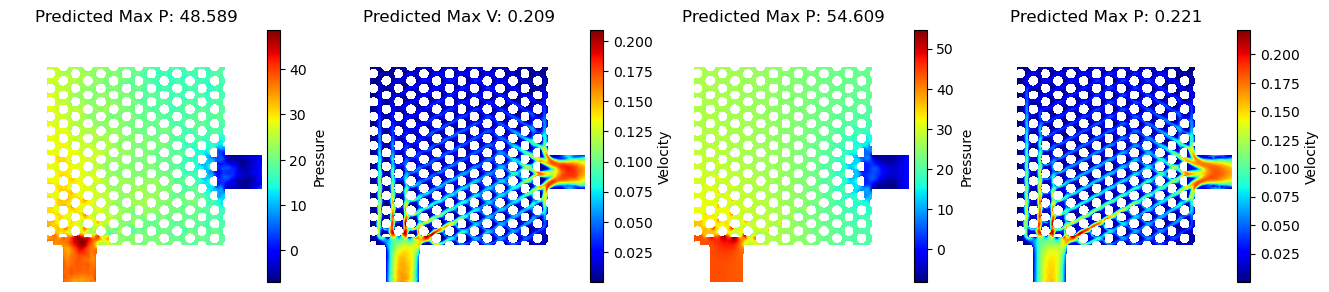

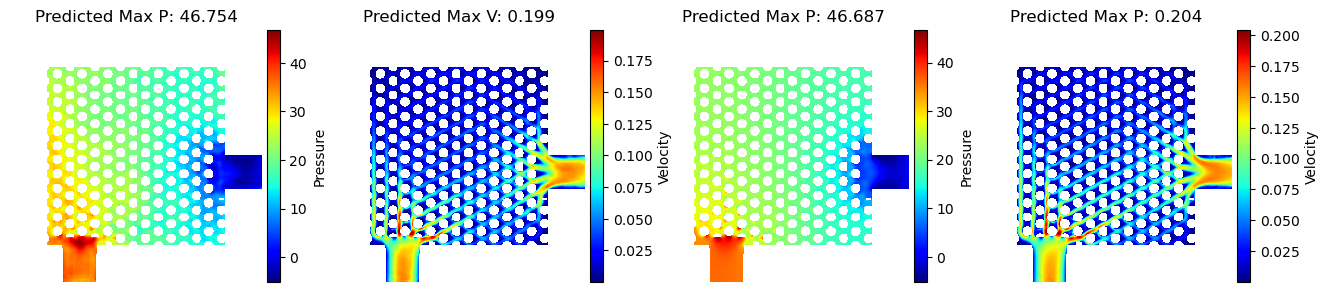

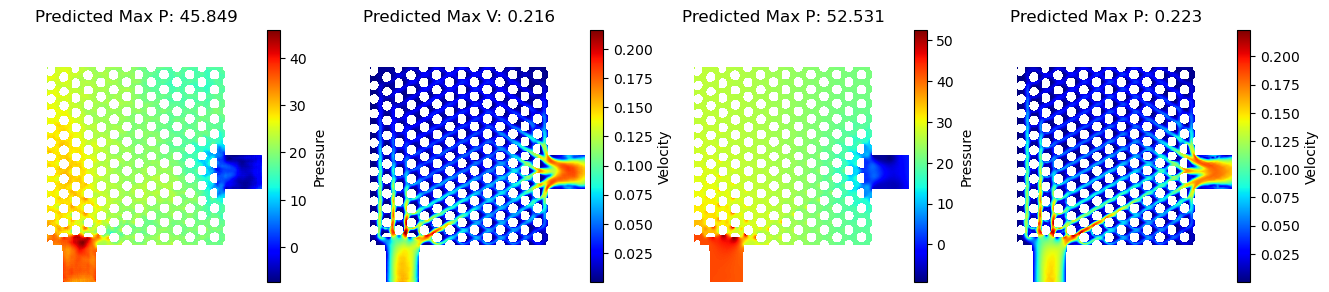

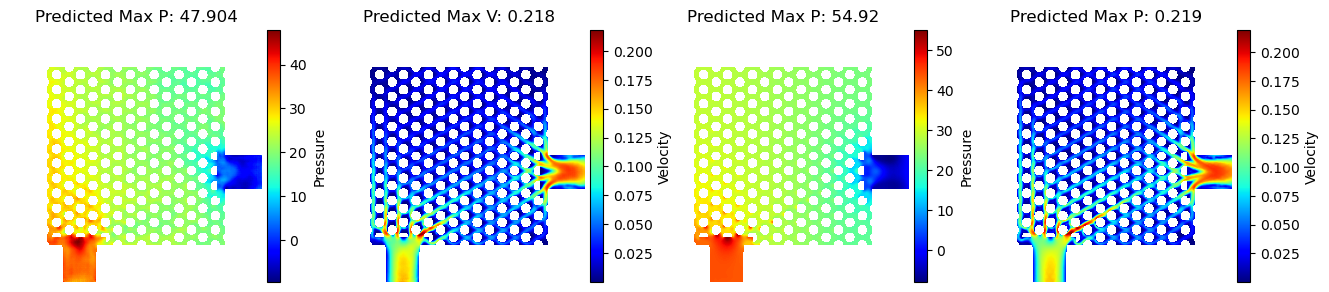

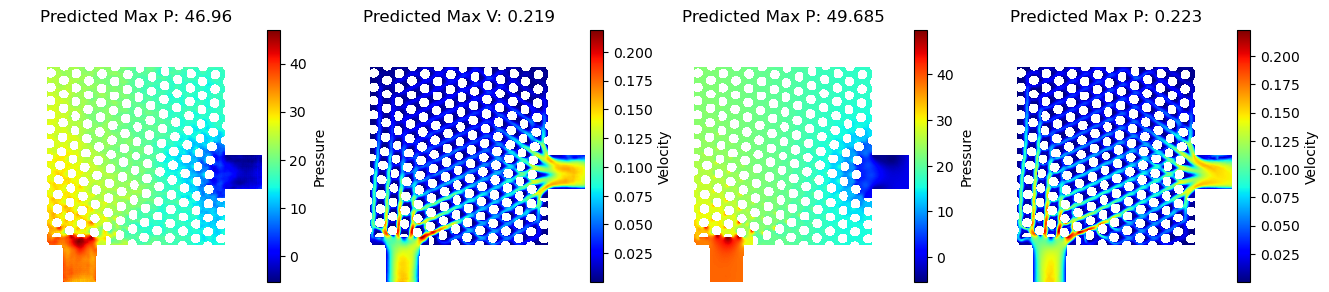

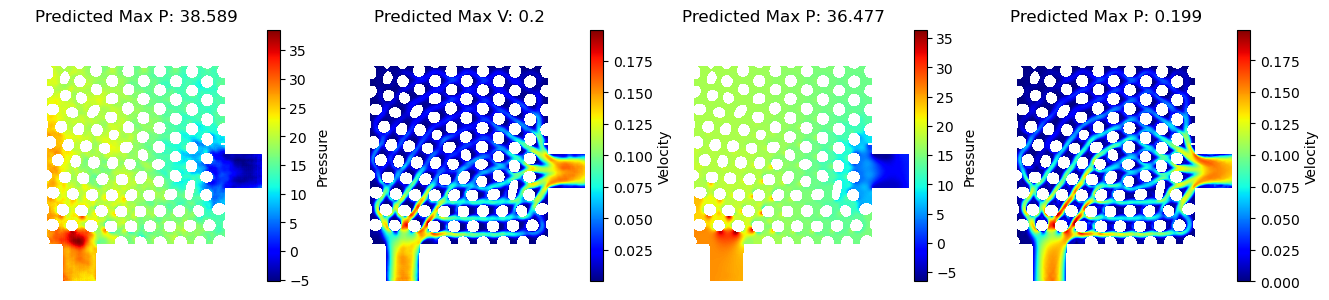

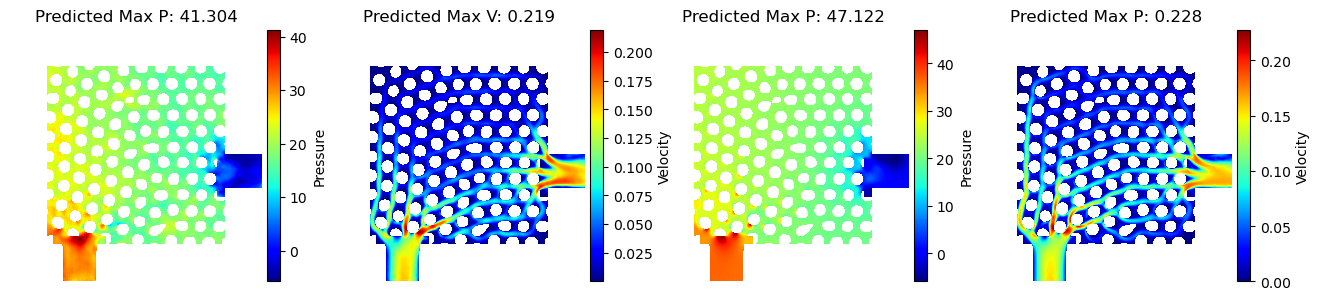

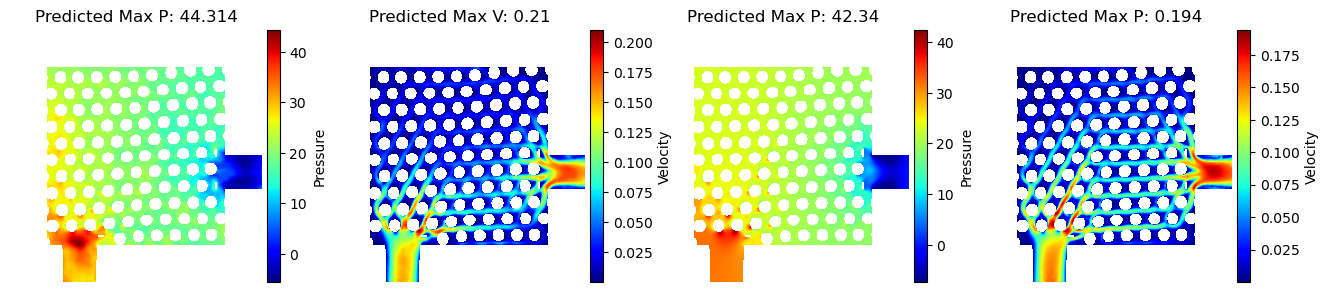

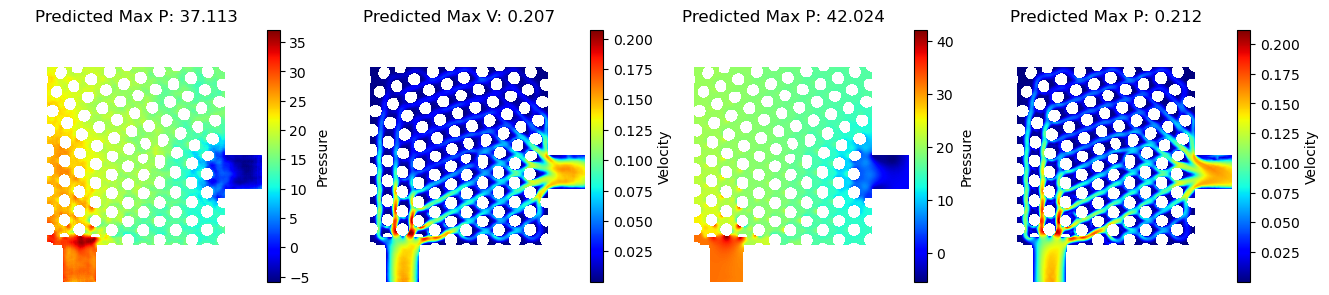

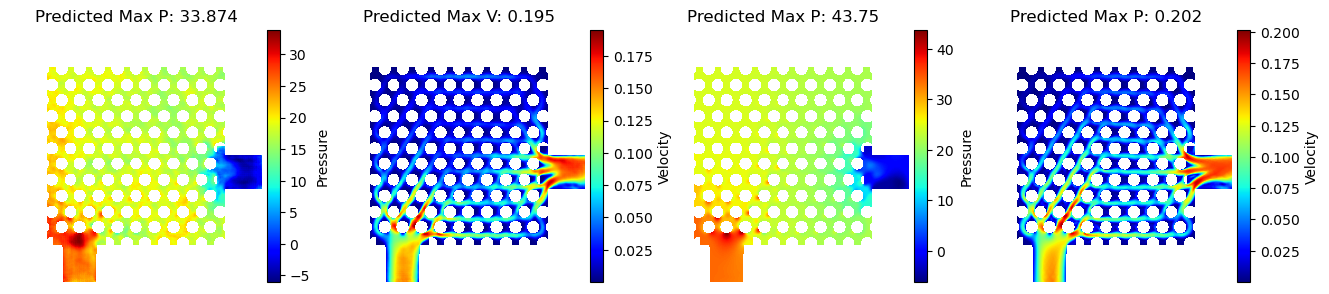

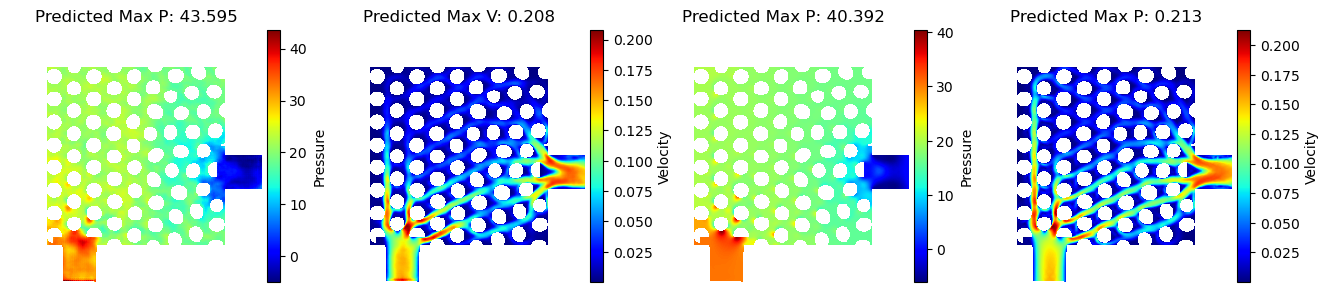

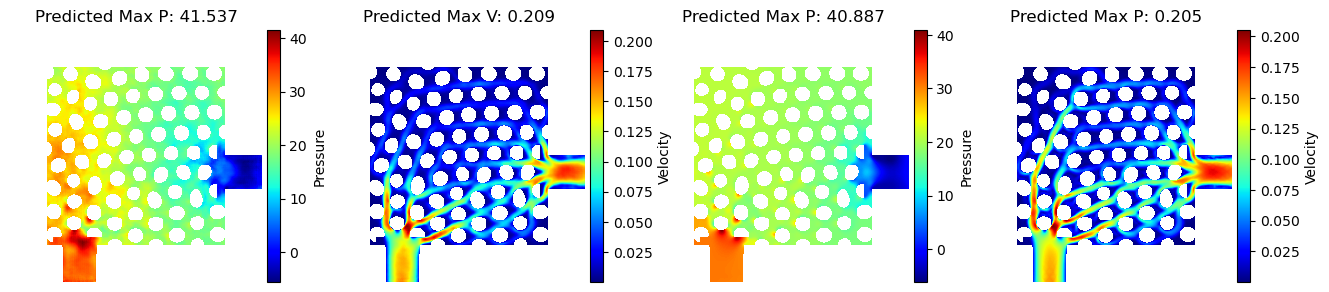

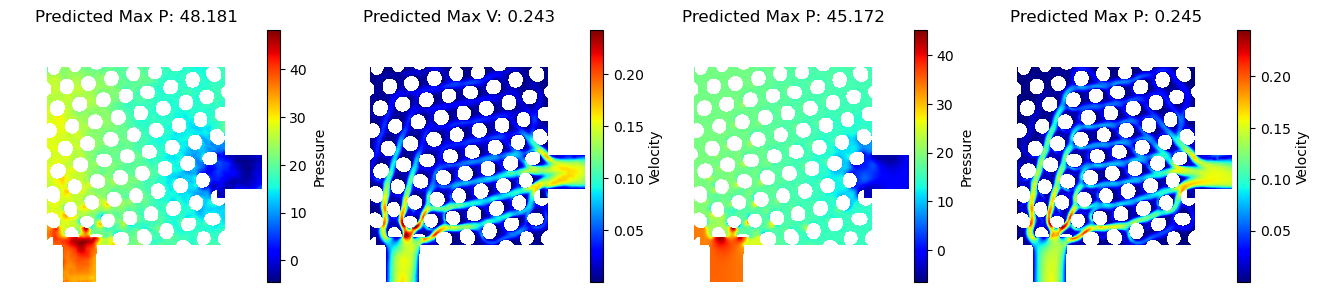

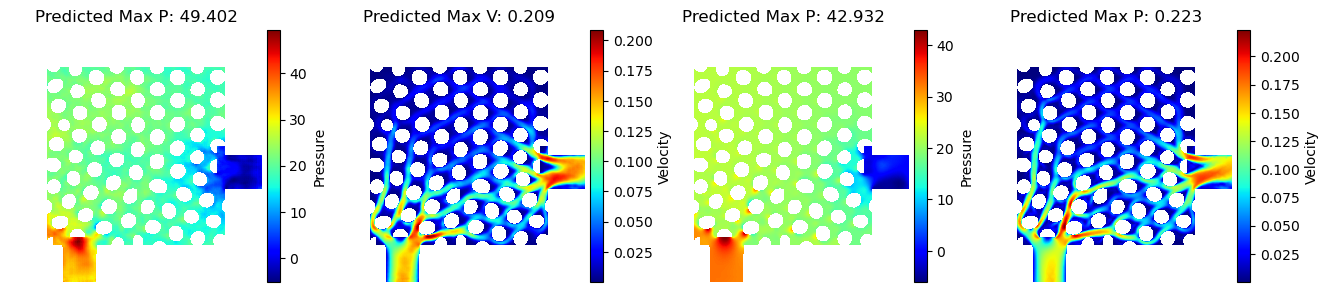

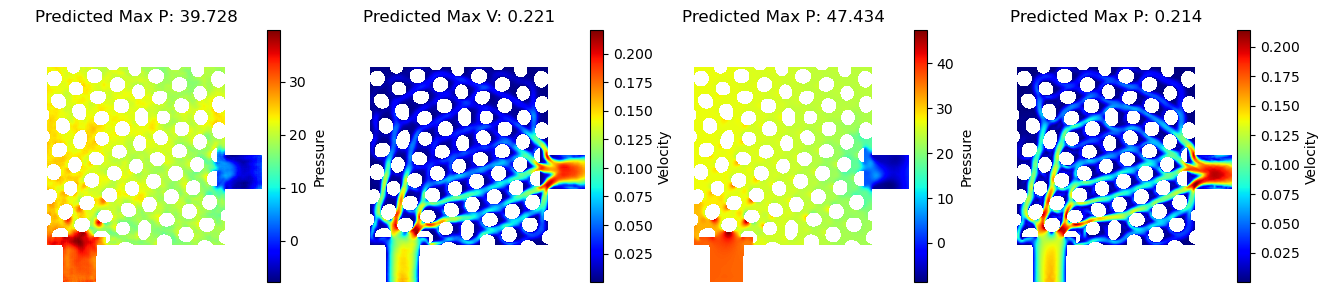

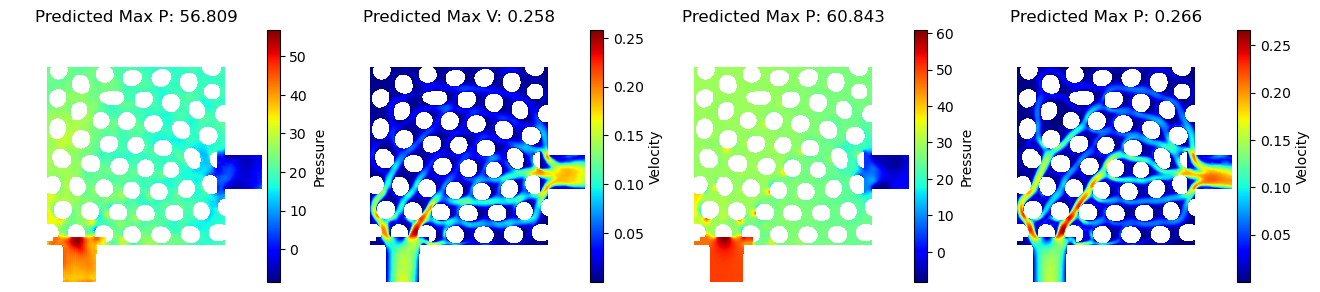

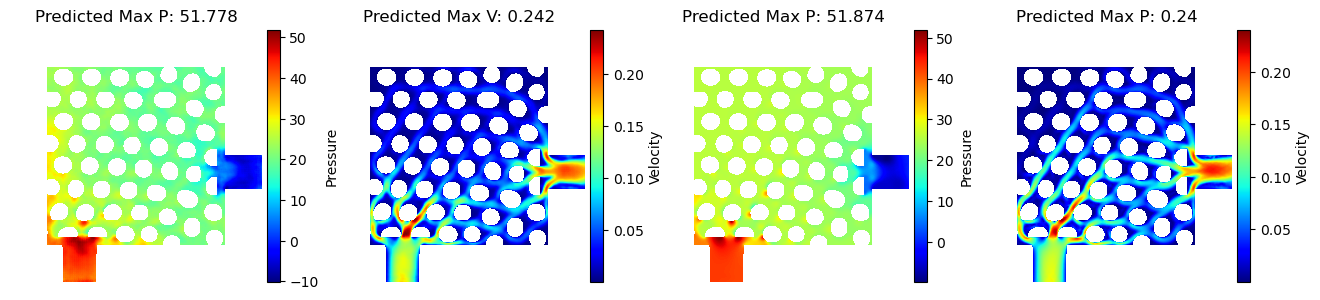

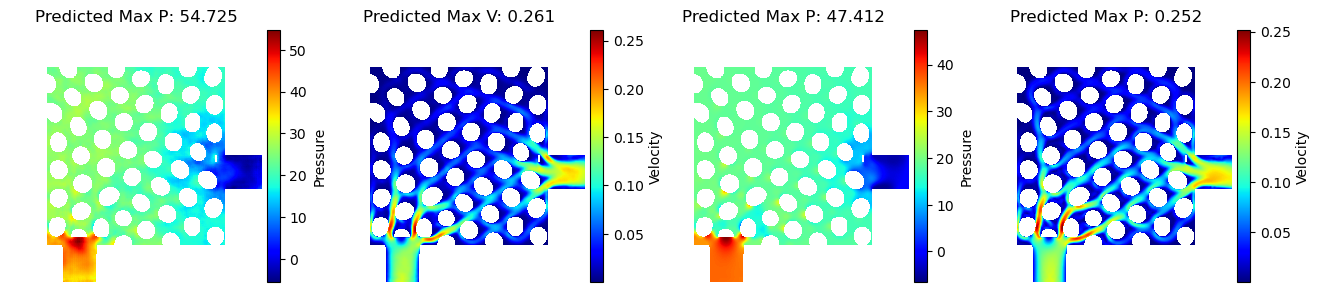

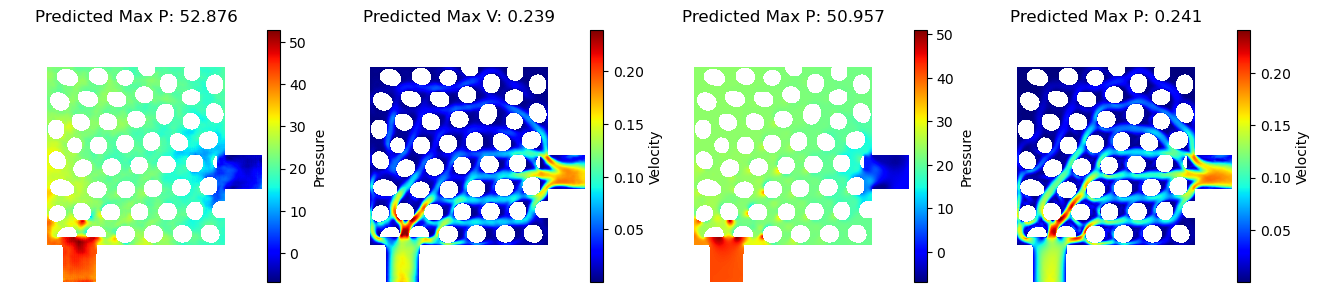

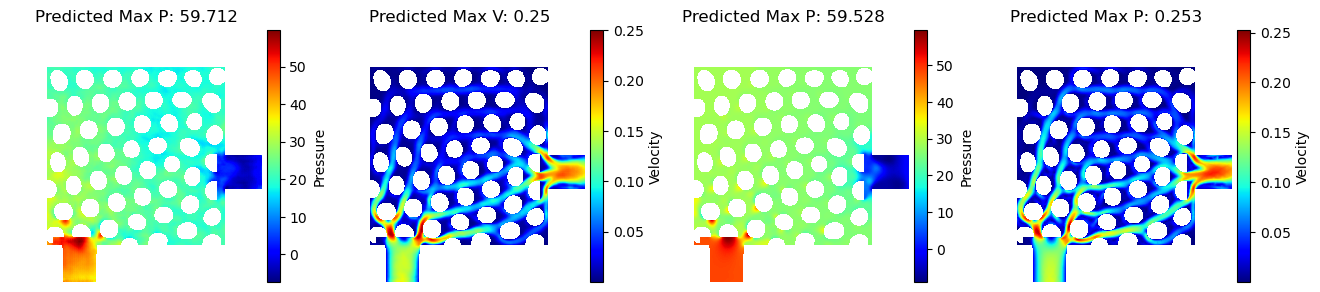

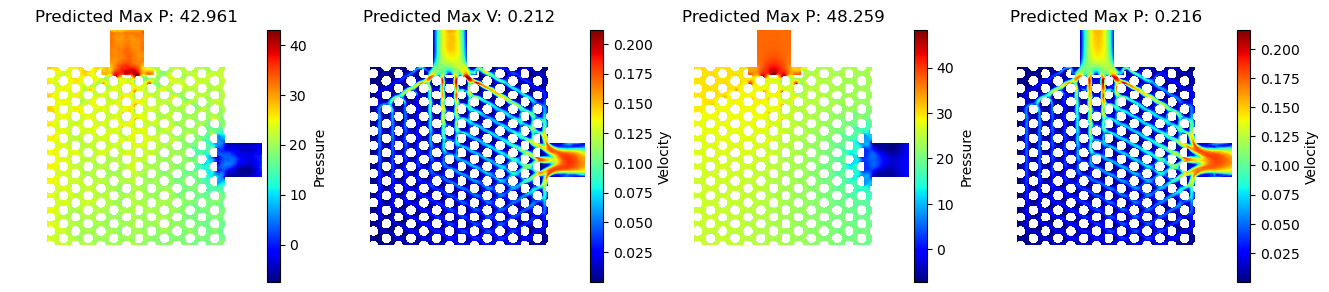

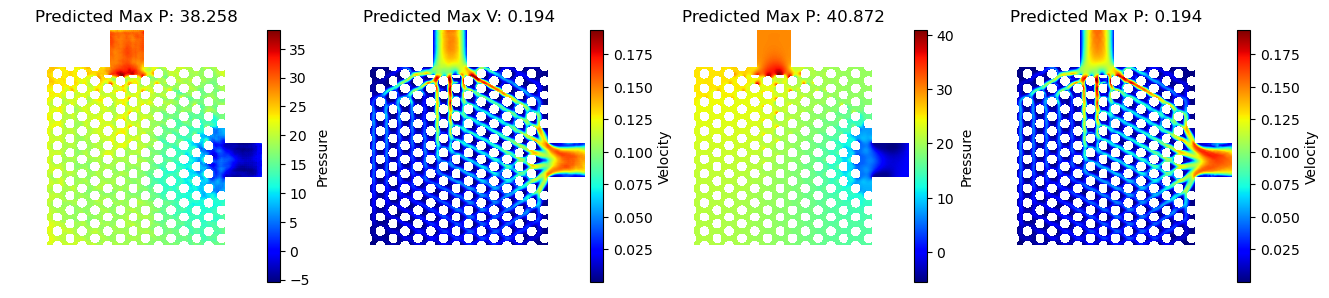

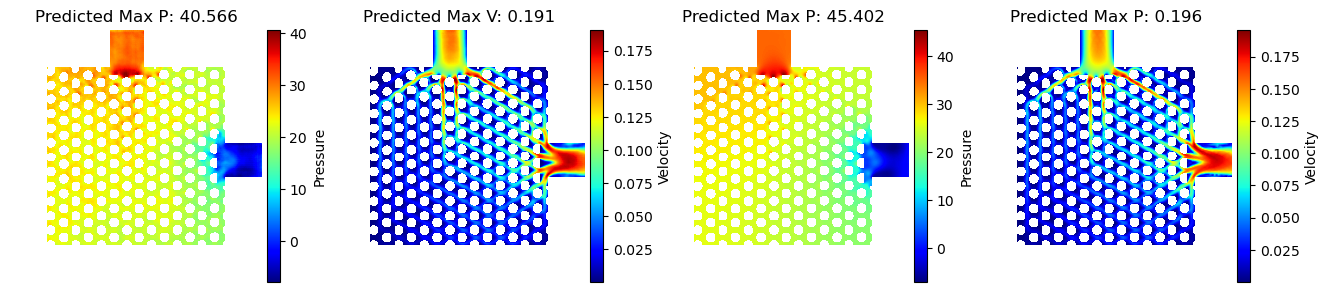

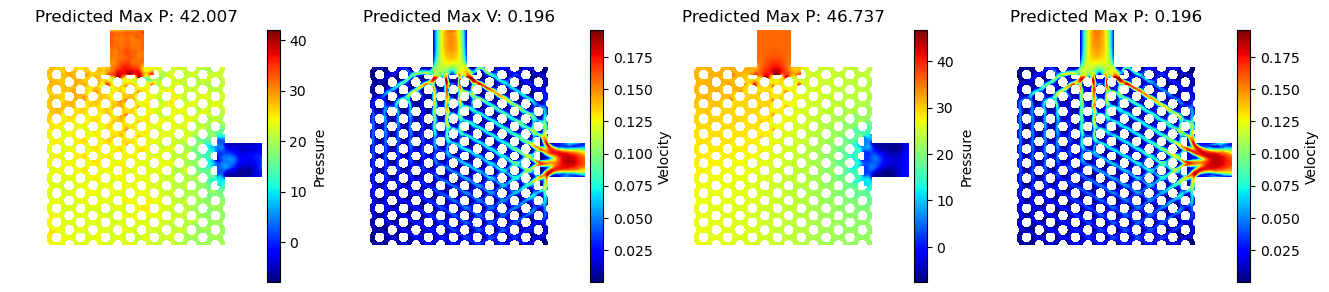

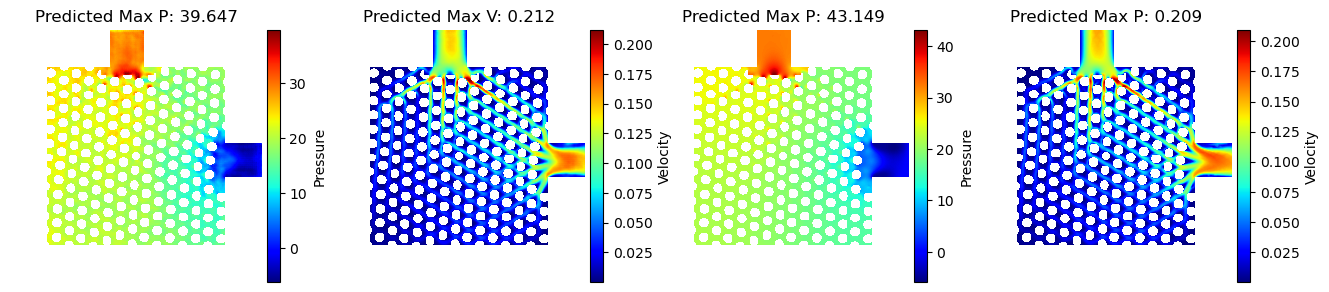

In [2]:
import matplotlib.pyplot as plt

lv2_folder = 'Validation/Low/LVV-new'
hv2_folder = 'Validation/High/HVV'
lp2_folder = 'Validation/Low/LPP-new'
hp2_folder = 'Validation/High/HPP'
lg2_folder = 'Validation/LG-3C'

# Get the list of file names in each folder
lv2_files = [f2 for f2 in os.listdir(lv2_folder) if f2 != ".ipynb_checkpoints"]
hv2_files = [f2 for f2 in os.listdir(hv2_folder) if f2 != ".ipynb_checkpoints"]
lp2_files = [f2 for f2 in os.listdir(lp2_folder) if f2 != ".ipynb_checkpoints"]
hp2_files = [f2 for f2 in os.listdir(hp2_folder) if f2 != ".ipynb_checkpoints"]
lg2_files = [f2 for f2 in os.listdir(lg2_folder) if f2 != ".ipynb_checkpoints"]

# Sort the file names to ensure the order is consistent
lv2_files.sort()
hv2_files.sort()
lp2_files.sort()
hp2_files.sort()
lg2_files.sort()



# Create empty lists to store the data
X_lv2 = []
X_lp2 = []
X_lg2 = []
Y_hv2 = []
Y_hp2 = []

# Read the data from the folders
for lv2_file, hv2_file,lp2_file,hp2_file,lg2_file in zip(lv2_files, hv2_files,lp2_files,hp2_files,lg2_files):
    try:
        
        # Read the LFV
        lv2_image = np.load(os.path.join(lv2_folder, lv2_file))  # Convert to RGB
        X_lv2.append(np.array(lv2_image))
        
        # Read the HFV
        hv2_image = np.load(os.path.join(hv2_folder, hv2_file))  # Convert to RGB
        Y_hv2.append(np.array(hv2_image))

        # Read the LFP
        lp2_image = np.load(os.path.join(lp2_folder, lp2_file))  # Convert to RGB
        X_lp2.append(np.array(lp2_image))
    
    
        # Read the channel geometry image
        lg2_image = Image.open(os.path.join(lg2_folder, lg2_file)).convert('RGB')  # Convert to RGB
        lg2_image = lg2_image.resize(input_shape[:2])  # Resize the image
        X_lg2.append(np.array(lg2_image))
    
        # Read the HFP
        hp2_image = np.load(os.path.join(hp2_folder, hp2_file))  # Convert to RGB
        Y_hp2.append(np.array(hp2_image))
    except:
        print('')

# Convert the lists to arrays
X_lv2 = np.array(X_lv2) 
X_lp2 = np.array(X_lp2) 
X_lg2 = np.array(X_lg2) / 255.0  # Normalize the channel geometry images
Y_hv2 = np.array(Y_hv2)
Y_hp2 = np.array(Y_hp2)





X_lp2 = np.nan_to_num(X_lp2, nan=0)
X_lv2 = np.nan_to_num(X_lv2, nan=0)
X_lp2=(X_lp2-np.min(X_lp2))/(np.max(X_lp2)-np.min(X_lp2))
# Predict velocity and pressure outputs
model.load_weights('Saved_Models_Temp/total-Micro-Unet-3-Inputs.h5')
pressure_output2,velocity_output2 = model.predict([X_lg2,X_lv2,X_lp2])

velocity_output2=(velocity_output2)
a=(np.max(Y_hp)-np.min(Y_hp))
b=(np.min(Y_hp))

pressure_output2=(pressure_output2*a)+b



mask = np.all(X_lg2 > 0.8, axis=-1)

# Expand mask to match the shape of array2
mask_expanded = np.repeat(mask[:, :, np.newaxis], 3, axis=2)
Y_hp2[mask]=np.nan
Y_hv2[mask]=np.nan
velocity_output2[mask]=np.nan
pressure_output2[mask]=np.nan

from mpl_toolkits.axes_grid1 import make_axes_locatable





def plot_images(index):
    plt.figure(figsize=(16, 48))

    # Display the pressure output
    ax1 = plt.subplot(1, 4, 1)
    im1 = ax1.imshow(pressure_output2[index],cmap='jet')
    divider1 = make_axes_locatable(ax1)
    cax1 = divider1.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im1, cax=cax1, label='Pressure')
    ax1.set_title('Predicted Max P: '+ str(np.round(np.nanmax(pressure_output2[index]),decimals=3)))
    ax1.axis("off")

    # Display the velocity output
    ax2 = plt.subplot(1, 4, 2)
    im2 = ax2.imshow(velocity_output2[index],cmap='jet')
    divider2 = make_axes_locatable(ax2)
    cax2 = divider2.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im2, cax=cax2, label='Velocity')
    ax2.set_title('Predicted Max V: '+ str(np.round(np.nanmax(velocity_output2[index]),decimals=3)))
    ax2.axis("off")

    # Display the input image (Pressure GT)
    ax3 = plt.subplot(1, 4, 3)
    im3 = ax3.imshow(Y_hp2[index],cmap='jet')
    divider3 = make_axes_locatable(ax3)
    cax3 = divider3.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im3, cax=cax3, label='Pressure')
    ax3.set_title('GT Max P: '+ str(np.round(np.nanmax(Y_hp2[index]),decimals=3)))
    ax3.axis("off")

    # Display the velocity GT
    ax4 = plt.subplot(1, 4, 4)
    im4 = ax4.imshow(Y_hv2[index],cmap='jet')
    divider4 = make_axes_locatable(ax4)
    cax4 = divider4.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im4, cax=cax4, label='Velocity')
    ax4.set_title('GT Max V: '+ str(np.round(np.nanmax(Y_hv2[index]),decimals=3)))
    ax4.axis("off")

    plt.show()

# Loop to plot images 
for i in range(0, 25):
    plot_images(i)

In [4]:
import numpy as np
from sklearn.metrics import mean_absolute_error, r2_score
from scipy.stats import pearsonr

Yp = np.expand_dims(Y_hp2, axis=-1)
Yv = np.expand_dims(Y_hv2, axis=-1)

expected = Yp
predicted = pressure_output2



# Mean Squared Error (MSE)
mse = np.nanmean((expected - predicted) ** 2)

# Mean Absolute Error (MAE)
mae = np.nanmean(np.abs(expected - predicted))

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Coefficient of Determination (R^2)
ss_tot = np.nanmean((expected - np.nanmean(expected)) ** 2)
ss_res = np.nanmean((expected - predicted) ** 2)
r2 = 1 - (ss_res / ss_tot)

# Normalized Root Mean Squared Error (NRMSE)
nrmse = rmse / (np.nanmax(expected) - np.nanmin(expected))

# Relative Error (RE)
relative_error = np.abs(expected - predicted) / np.abs(expected)
re = np.nanmean(relative_error)

# Symmetric Mean Absolute Percentage Error (SMAPE)
smape = 100 * np.nanmean(2 * np.abs(expected - predicted) / (np.abs(expected) + np.abs(predicted)))

# Pearson Correlation Coefficient (r)
expected_flattened = expected.flatten()
predicted_flattened = predicted.flatten()
valid_mask = ~np.isnan(expected_flattened) & ~np.isnan(predicted_flattened)
expected_valid = expected_flattened[valid_mask]
predicted_valid = predicted_flattened[valid_mask]
pearson_corr = np.corrcoef(expected_valid, predicted_valid)[0, 1]



# Peak Signal-to-Noise Ratio (PSNR)
psnr = 10 * np.log10(np.nanmax(expected) ** 2 / mse)

# Print Results
print("---------------------All Results---------")
print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R^2: {r2:.4f}")
print(f"NRMSE: {nrmse:.4f}")
print(f"SMAPE: {smape:.4f}%")
print(f"Pearson Correlation: {pearson_corr:.4f}")
print(f"PSNR: {psnr:.4f} dB")

print("---------------------RN=1000---------")

# Dummy data (replace with actual predicted and expected arrays)
expected = Yp[0:973]
predicted = pressure_output2[0:973]



# Mean Squared Error (MSE)
mse = np.nanmean((expected - predicted) ** 2)

# Mean Absolute Error (MAE)
mae = np.nanmean(np.abs(expected - predicted))

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Coefficient of Determination (R^2)
ss_tot = np.nanmean((expected - np.nanmean(expected)) ** 2)
ss_res = np.nanmean((expected - predicted) ** 2)
r2 = 1 - (ss_res / ss_tot)

# Normalized Root Mean Squared Error (NRMSE)
nrmse = rmse / (np.nanmax(expected) - np.nanmin(expected))

# Relative Error (RE)
relative_error = np.abs(expected - predicted) / np.abs(expected)
re = np.nanmean(relative_error)

# Symmetric Mean Absolute Percentage Error (SMAPE)
smape = 100 * np.nanmean(2 * np.abs(expected - predicted) / (np.abs(expected) + np.abs(predicted)))

# Pearson Correlation Coefficient (r)
expected_flattened = expected.flatten()
predicted_flattened = predicted.flatten()
valid_mask = ~np.isnan(expected_flattened) & ~np.isnan(predicted_flattened)
expected_valid = expected_flattened[valid_mask]
predicted_valid = predicted_flattened[valid_mask]
pearson_corr = np.corrcoef(expected_valid, predicted_valid)[0, 1]



# Peak Signal-to-Noise Ratio (PSNR)
psnr = 10 * np.log10(np.nanmax(expected) ** 2 / mse)

# Print Results
print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R^2: {r2:.4f}")
print(f"NRMSE: {nrmse:.4f}")
print(f"SMAPE: {smape:.4f}%")
print(f"Pearson Correlation: {pearson_corr:.4f}")
print(f"PSNR: {psnr:.4f} dB")

print("---------------------RN=1500---------")

expected = Yp[974:1886]
predicted = pressure_output2[974:1886]




# Mean Squared Error (MSE)
mse = np.nanmean((expected - predicted) ** 2)

# Mean Absolute Error (MAE)
mae = np.nanmean(np.abs(expected - predicted))

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Coefficient of Determination (R^2)
ss_tot = np.nanmean((expected - np.nanmean(expected)) ** 2)
ss_res = np.nanmean((expected - predicted) ** 2)
r2 = 1 - (ss_res / ss_tot)

# Normalized Root Mean Squared Error (NRMSE)
nrmse = rmse / (np.nanmax(expected) - np.nanmin(expected))

# Relative Error (RE)
relative_error = np.abs(expected - predicted) / np.abs(expected)
re = np.nanmean(relative_error)

# Symmetric Mean Absolute Percentage Error (SMAPE)
smape = 100 * np.nanmean(2 * np.abs(expected - predicted) / (np.abs(expected) + np.abs(predicted)))

# Pearson Correlation Coefficient (r)
expected_flattened = expected.flatten()
predicted_flattened = predicted.flatten()
valid_mask = ~np.isnan(expected_flattened) & ~np.isnan(predicted_flattened)
expected_valid = expected_flattened[valid_mask]
predicted_valid = predicted_flattened[valid_mask]
pearson_corr = np.corrcoef(expected_valid, predicted_valid)[0, 1]



# Peak Signal-to-Noise Ratio (PSNR)
psnr = 10 * np.log10(np.nanmax(expected) ** 2 / mse)

# Print Results
print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R^2: {r2:.4f}")
print(f"NRMSE: {nrmse:.4f}")
print(f"SMAPE: {smape:.4f}%")
print(f"Pearson Correlation: {pearson_corr:.4f}")
print(f"PSNR: {psnr:.4f} dB")
    
print("---------------------RN=500---------")

expected = Yp[1887:2885]
predicted = pressure_output2[1887:2885]



# Mean Squared Error (MSE)
mse = np.nanmean((expected - predicted) ** 2)

# Mean Absolute Error (MAE)
mae = np.nanmean(np.abs(expected - predicted))

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Coefficient of Determination (R^2)
ss_tot = np.nanmean((expected - np.nanmean(expected)) ** 2)
ss_res = np.nanmean((expected - predicted) ** 2)
r2 = 1 - (ss_res / ss_tot)

# Normalized Root Mean Squared Error (NRMSE)
nrmse = rmse / (np.nanmax(expected) - np.nanmin(expected))

# Relative Error (RE)
relative_error = np.abs(expected - predicted) / np.abs(expected)
re = np.nanmean(relative_error)

# Symmetric Mean Absolute Percentage Error (SMAPE)
smape = 100 * np.nanmean(2 * np.abs(expected - predicted) / (np.abs(expected) + np.abs(predicted)))

# Pearson Correlation Coefficient (r)
expected_flattened = expected.flatten()
predicted_flattened = predicted.flatten()
valid_mask = ~np.isnan(expected_flattened) & ~np.isnan(predicted_flattened)
expected_valid = expected_flattened[valid_mask]
predicted_valid = predicted_flattened[valid_mask]
pearson_corr = np.corrcoef(expected_valid, predicted_valid)[0, 1]



# Peak Signal-to-Noise Ratio (PSNR)
psnr = 10 * np.log10(np.nanmax(expected) ** 2 / mse)

# Print Results
print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R^2: {r2:.4f}")
print(f"NRMSE: {nrmse:.4f}")
print(f"SMAPE: {smape:.4f}%")
print(f"Pearson Correlation: {pearson_corr:.4f}")
print(f"PSNR: {psnr:.4f} dB")


---------------------All Results---------
MSE: 124.5536
MAE: 4.7267
RMSE: 11.1604
R^2: 0.7782
NRMSE: 0.0194
SMAPE: 25.8294%
Pearson Correlation: 0.8882
PSNR: 33.3554 dB
---------------------RN=1000---------
MSE: 148.6015
MAE: 4.3018
RMSE: 12.1902
R^2: 0.3303
NRMSE: 0.0282
SMAPE: 22.2568%
Pearson Correlation: 0.5966
PSNR: 30.3388 dB
---------------------RN=1500---------
MSE: 149.9533
MAE: 8.3307
RMSE: 12.2455
R^2: 0.6844
NRMSE: 0.0213
SMAPE: 21.0642%
Pearson Correlation: 0.8421
PSNR: 32.5494 dB
---------------------RN=500---------
MSE: 78.1282
MAE: 1.8466
RMSE: 8.8390
R^2: 0.0638
NRMSE: 0.0234
SMAPE: 33.6905%
Pearson Correlation: 0.2802
PSNR: 32.0179 dB


In [7]:
import numpy as np
from sklearn.metrics import mean_absolute_error, r2_score
from scipy.stats import pearsonr

# Dummy data (replace with actual predicted and expected arrays)
expected = Yv
predicted = velocity_output2

# Mean Squared Error (MSE)
mse = np.nanmean((expected - predicted) ** 2)

# Mean Absolute Error (MAE)
mae = np.nanmean(np.abs(expected - predicted))

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Coefficient of Determination (R^2)
ss_tot = np.nanmean((expected - np.nanmean(expected)) ** 2)
ss_res = np.nanmean((expected - predicted) ** 2)
r2 = 1 - (ss_res / ss_tot)

# Normalized Root Mean Squared Error (NRMSE)
nrmse = rmse / (np.nanmax(expected) - np.nanmin(expected))

# Relative Error (RE)
relative_error = np.abs(expected - predicted) / np.abs(expected)
re = np.nanmean(relative_error)

# Symmetric Mean Absolute Percentage Error (SMAPE)
smape = 100 * np.nanmean(2 * np.abs(expected - predicted) / (np.abs(expected) + np.abs(predicted)))

# Pearson Correlation Coefficient (r)
expected_flattened = expected.flatten()
predicted_flattened = predicted.flatten()
valid_mask = ~np.isnan(expected_flattened) & ~np.isnan(predicted_flattened)
expected_valid = expected_flattened[valid_mask]
predicted_valid = predicted_flattened[valid_mask]
pearson_corr = np.corrcoef(expected_valid, predicted_valid)[0, 1]



# Peak Signal-to-Noise Ratio (PSNR)
psnr = 10 * np.log10(np.nanmax(expected) ** 2 / mse)

# Print Results
print("---------------------All Results---------")
print(f"MSE: {mse:.8f}")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R^2: {r2:.4f}")
print(f"NRMSE: {nrmse:.4f}")
print(f"SMAPE: {smape:.4f}%")
print(f"Pearson Correlation: {pearson_corr:.4f}")
print(f"PSNR: {psnr:.4f} dB")

print("---------------------RN=1000---------")

# Dummy data (replace with actual predicted and expected arrays)
expected = Yv[0:973]
predicted = velocity_output2[0:973]



# Mean Squared Error (MSE)
mse = np.nanmean((expected - predicted) ** 2)

# Mean Absolute Error (MAE)
mae = np.nanmean(np.abs(expected - predicted))

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Coefficient of Determination (R^2)
ss_tot = np.nanmean((expected - np.nanmean(expected)) ** 2)
ss_res = np.nanmean((expected - predicted) ** 2)
r2 = 1 - (ss_res / ss_tot)

# Normalized Root Mean Squared Error (NRMSE)
nrmse = rmse / (np.nanmax(expected) - np.nanmin(expected))

# Relative Error (RE)
relative_error = np.abs(expected - predicted) / np.abs(expected)
re = np.nanmean(relative_error)

# Symmetric Mean Absolute Percentage Error (SMAPE)
smape = 100 * np.nanmean(2 * np.abs(expected - predicted) / (np.abs(expected) + np.abs(predicted)))

# Pearson Correlation Coefficient (r)
expected_flattened = expected.flatten()
predicted_flattened = predicted.flatten()
valid_mask = ~np.isnan(expected_flattened) & ~np.isnan(predicted_flattened)
expected_valid = expected_flattened[valid_mask]
predicted_valid = predicted_flattened[valid_mask]
pearson_corr = np.corrcoef(expected_valid, predicted_valid)[0, 1]



# Peak Signal-to-Noise Ratio (PSNR)
psnr = 10 * np.log10(np.nanmax(expected) ** 2 / mse)

# Print Results
print(f"MSE: {mse:.8f}")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R^2: {r2:.4f}")
print(f"NRMSE: {nrmse:.4f}")
print(f"SMAPE: {smape:.4f}%")
print(f"Pearson Correlation: {pearson_corr:.4f}")
print(f"PSNR: {psnr:.4f} dB")

print("---------------------RN=1500---------")

expected = Yv[974:1886]
predicted = velocity_output2[974:1886]




# Mean Squared Error (MSE)
mse = np.nanmean((expected - predicted) ** 2)

# Mean Absolute Error (MAE)
mae = np.nanmean(np.abs(expected - predicted))

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Coefficient of Determination (R^2)
ss_tot = np.nanmean((expected - np.nanmean(expected)) ** 2)
ss_res = np.nanmean((expected - predicted) ** 2)
r2 = 1 - (ss_res / ss_tot)

# Normalized Root Mean Squared Error (NRMSE)
nrmse = rmse / (np.nanmax(expected) - np.nanmin(expected))

# Relative Error (RE)
relative_error = np.abs(expected - predicted) / np.abs(expected)
re = np.nanmean(relative_error)

# Symmetric Mean Absolute Percentage Error (SMAPE)
smape = 100 * np.nanmean(2 * np.abs(expected - predicted) / (np.abs(expected) + np.abs(predicted)))

# Pearson Correlation Coefficient (r)
expected_flattened = expected.flatten()
predicted_flattened = predicted.flatten()
valid_mask = ~np.isnan(expected_flattened) & ~np.isnan(predicted_flattened)
expected_valid = expected_flattened[valid_mask]
predicted_valid = predicted_flattened[valid_mask]
pearson_corr = np.corrcoef(expected_valid, predicted_valid)[0, 1]



# Peak Signal-to-Noise Ratio (PSNR)
psnr = 10 * np.log10(np.nanmax(expected) ** 2 / mse)

# Print Results
print(f"MSE: {mse:.8f}")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R^2: {r2:.4f}")
print(f"NRMSE: {nrmse:.4f}")
print(f"SMAPE: {smape:.4f}%")
print(f"Pearson Correlation: {pearson_corr:.4f}")
print(f"PSNR: {psnr:.4f} dB")
    
print("---------------------RN=500---------")

expected = Yv[1887:2885]
predicted = velocity_output2[1887:2885]



# Mean Squared Error (MSE)
mse = np.nanmean((expected - predicted) ** 2)

# Mean Absolute Error (MAE)
mae = np.nanmean(np.abs(expected - predicted))

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Coefficient of Determination (R^2)
ss_tot = np.nanmean((expected - np.nanmean(expected)) ** 2)
ss_res = np.nanmean((expected - predicted) ** 2)
r2 = 1 - (ss_res / ss_tot)

# Normalized Root Mean Squared Error (NRMSE)
nrmse = rmse / (np.nanmax(expected) - np.nanmin(expected))

# Relative Error (RE)
relative_error = np.abs(expected - predicted) / np.abs(expected)
re = np.nanmean(relative_error)

# Symmetric Mean Absolute Percentage Error (SMAPE)
smape = 100 * np.nanmean(2 * np.abs(expected - predicted) / (np.abs(expected) + np.abs(predicted)))

# Pearson Correlation Coefficient (r)
expected_flattened = expected.flatten()
predicted_flattened = predicted.flatten()
valid_mask = ~np.isnan(expected_flattened) & ~np.isnan(predicted_flattened)
expected_valid = expected_flattened[valid_mask]
predicted_valid = predicted_flattened[valid_mask]
pearson_corr = np.corrcoef(expected_valid, predicted_valid)[0, 1]



# Peak Signal-to-Noise Ratio (PSNR)
psnr = 10 * np.log10(np.nanmax(expected) ** 2 / mse)

# Print Results
print(f"MSE: {mse:.8f}")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R^2: {r2:.4f}")
print(f"NRMSE: {nrmse:.4f}")
print(f"SMAPE: {smape:.4f}%")
print(f"Pearson Correlation: {pearson_corr:.4f}")
print(f"PSNR: {psnr:.4f} dB")



---------------------All Results---------
MSE: 0.00029717
MAE: 0.0092
RMSE: 0.0172
R^2: 0.9015
NRMSE: 0.0189
SMAPE: 42.1514%
Pearson Correlation: 0.9500
PSNR: 34.4709 dB
---------------------RN=1000---------
MSE: 0.00024080
MAE: 0.0090
RMSE: 0.0155
R^2: 0.8988
NRMSE: 0.0191
SMAPE: 41.7279%
Pearson Correlation: 0.9486
PSNR: 34.3965 dB
---------------------RN=1500---------
MSE: 0.00061546
MAE: 0.0146
RMSE: 0.0248
R^2: 0.8843
NRMSE: 0.0272
SMAPE: 43.8506%
Pearson Correlation: 0.9412
PSNR: 31.3089 dB
---------------------RN=500---------
MSE: 0.00006009
MAE: 0.0044
RMSE: 0.0078
R^2: 0.8991
NRMSE: 0.0125
SMAPE: 40.9993%
Pearson Correlation: 0.9490
PSNR: 38.0837 dB


In [8]:
path1="Results_Temp/Mixed/Unet"
os.makedirs(path1, exist_ok=True)
np.save(path1+"/velocity_predicted.npy",velocity_output2)
np.save(path1+"/pressure_predicted.npy",pressure_output2)


In [8]:
import numpy as np
from sklearn.metrics import mean_absolute_error, r2_score
from scipy.stats import pearsonr

inds1=np.load("Flow-Configurations/top-top.npy")
# Dummy data (replace with actual predicted and expected arrays)
expected = Yp[inds1]
predicted = pressure_output2[inds1]



# Mean Squared Error (MSE)
mse = np.nanmean((expected - predicted) ** 2)

# Mean Absolute Error (MAE)
mae = np.nanmean(np.abs(expected - predicted))

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Coefficient of Determination (R^2)
ss_tot = np.nanmean((expected - np.nanmean(expected)) ** 2)
ss_res = np.nanmean((expected - predicted) ** 2)
r2 = 1 - (ss_res / ss_tot)

# Normalized Root Mean Squared Error (NRMSE)
nrmse = rmse / (np.nanmax(expected) - np.nanmin(expected))

# Relative Error (RE)
relative_error = np.abs(expected - predicted) / np.abs(expected)
re = np.nanmean(relative_error)

# Symmetric Mean Absolute Percentage Error (SMAPE)
smape = 100 * np.nanmean(2 * np.abs(expected - predicted) / (np.abs(expected) + np.abs(predicted)))

# Pearson Correlation Coefficient (r)
expected_flattened = expected.flatten()
predicted_flattened = predicted.flatten()
valid_mask = ~np.isnan(expected_flattened) & ~np.isnan(predicted_flattened)
expected_valid = expected_flattened[valid_mask]
predicted_valid = predicted_flattened[valid_mask]
pearson_corr = np.corrcoef(expected_valid, predicted_valid)[0, 1]



# Peak Signal-to-Noise Ratio (PSNR)
psnr = 10 * np.log10(np.nanmax(expected) ** 2 / mse)

# Print Results
print("---------------------Same-Side-In-Out---------")
print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R^2: {r2:.4f}")
print(f"NRMSE: {nrmse:.4f}")
print(f"SMAPE: {smape:.4f}%")
print(f"Pearson Correlation: {pearson_corr:.4f}")
print(f"PSNR: {psnr:.4f} dB")


inds2=np.load("Flow-Configurations/top-bottom.npy")
# Dummy data (replace with actual predicted and expected arrays)
expected = Yp[inds2]
predicted = pressure_output2[inds2]



# Mean Squared Error (MSE)
mse = np.nanmean((expected - predicted) ** 2)

# Mean Absolute Error (MAE)
mae = np.nanmean(np.abs(expected - predicted))

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Coefficient of Determination (R^2)
ss_tot = np.nanmean((expected - np.nanmean(expected)) ** 2)
ss_res = np.nanmean((expected - predicted) ** 2)
r2 = 1 - (ss_res / ss_tot)

# Normalized Root Mean Squared Error (NRMSE)
nrmse = rmse / (np.nanmax(expected) - np.nanmin(expected))

# Relative Error (RE)
relative_error = np.abs(expected - predicted) / np.abs(expected)
re = np.nanmean(relative_error)

# Symmetric Mean Absolute Percentage Error (SMAPE)
smape = 100 * np.nanmean(2 * np.abs(expected - predicted) / (np.abs(expected) + np.abs(predicted)))

# Pearson Correlation Coefficient (r)
expected_flattened = expected.flatten()
predicted_flattened = predicted.flatten()
valid_mask = ~np.isnan(expected_flattened) & ~np.isnan(predicted_flattened)
expected_valid = expected_flattened[valid_mask]
predicted_valid = predicted_flattened[valid_mask]
pearson_corr = np.corrcoef(expected_valid, predicted_valid)[0, 1]



# Peak Signal-to-Noise Ratio (PSNR)
psnr = 10 * np.log10(np.nanmax(expected) ** 2 / mse)

# Print Results
print("---------------------Top-Bottom---------")
print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R^2: {r2:.4f}")
print(f"NRMSE: {nrmse:.4f}")
print(f"SMAPE: {smape:.4f}%")
print(f"Pearson Correlation: {pearson_corr:.4f}")
print(f"PSNR: {psnr:.4f} dB")




inds3=np.load("Flow-Configurations/top-right.npy")
# Dummy data (replace with actual predicted and expected arrays)
expected = Yp[inds3]
predicted = pressure_output2[inds3]



# Mean Squared Error (MSE)
mse = np.nanmean((expected - predicted) ** 2)

# Mean Absolute Error (MAE)
mae = np.nanmean(np.abs(expected - predicted))

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Coefficient of Determination (R^2)
ss_tot = np.nanmean((expected - np.nanmean(expected)) ** 2)
ss_res = np.nanmean((expected - predicted) ** 2)
r2 = 1 - (ss_res / ss_tot)

# Normalized Root Mean Squared Error (NRMSE)
nrmse = rmse / (np.nanmax(expected) - np.nanmin(expected))

# Relative Error (RE)
relative_error = np.abs(expected - predicted) / np.abs(expected)
re = np.nanmean(relative_error)

# Symmetric Mean Absolute Percentage Error (SMAPE)
smape = 100 * np.nanmean(2 * np.abs(expected - predicted) / (np.abs(expected) + np.abs(predicted)))

# Pearson Correlation Coefficient (r)
expected_flattened = expected.flatten()
predicted_flattened = predicted.flatten()
valid_mask = ~np.isnan(expected_flattened) & ~np.isnan(predicted_flattened)
expected_valid = expected_flattened[valid_mask]
predicted_valid = predicted_flattened[valid_mask]
pearson_corr = np.corrcoef(expected_valid, predicted_valid)[0, 1]



# Peak Signal-to-Noise Ratio (PSNR)
psnr = 10 * np.log10(np.nanmax(expected) ** 2 / mse)






# Print Results
print("---------------------Top-Right---------")
print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R^2: {r2:.4f}")
print(f"NRMSE: {nrmse:.4f}")
print(f"SMAPE: {smape:.4f}%")
print(f"Pearson Correlation: {pearson_corr:.4f}")
print(f"PSNR: {psnr:.4f} dB")




inds5=np.load("Flow-Configurations/top-left.npy")
# Dummy data (replace with actual predicted and expected arrays)
expected = Yp[inds5]
predicted = pressure_output2[inds5]



# Mean Squared Error (MSE)
mse = np.nanmean((expected - predicted) ** 2)

# Mean Absolute Error (MAE)
mae = np.nanmean(np.abs(expected - predicted))

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Coefficient of Determination (R^2)
ss_tot = np.nanmean((expected - np.nanmean(expected)) ** 2)
ss_res = np.nanmean((expected - predicted) ** 2)
r2 = 1 - (ss_res / ss_tot)

# Normalized Root Mean Squared Error (NRMSE)
nrmse = rmse / (np.nanmax(expected) - np.nanmin(expected))

# Relative Error (RE)
relative_error = np.abs(expected - predicted) / np.abs(expected)
re = np.nanmean(relative_error)

# Symmetric Mean Absolute Percentage Error (SMAPE)
smape = 100 * np.nanmean(2 * np.abs(expected - predicted) / (np.abs(expected) + np.abs(predicted)))

# Pearson Correlation Coefficient (r)
expected_flattened = expected.flatten()
predicted_flattened = predicted.flatten()
valid_mask = ~np.isnan(expected_flattened) & ~np.isnan(predicted_flattened)
expected_valid = expected_flattened[valid_mask]
predicted_valid = predicted_flattened[valid_mask]
pearson_corr = np.corrcoef(expected_valid, predicted_valid)[0, 1]



# Peak Signal-to-Noise Ratio (PSNR)
psnr = 10 * np.log10(np.nanmax(expected) ** 2 / mse)






# Print Results
print("---------------------Top-Left---------")
print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R^2: {r2:.4f}")
print(f"NRMSE: {nrmse:.4f}")
print(f"SMAPE: {smape:.4f}%")
print(f"Pearson Correlation: {pearson_corr:.4f}")
print(f"PSNR: {psnr:.4f} dB")





inds4=np.load("Flow-Configurations/left-right.npy")
# Dummy data (replace with actual predicted and expected arrays)
expected = Yp[inds4]
predicted = pressure_output2[inds4]



# Mean Squared Error (MSE)
mse = np.nanmean((expected - predicted) ** 2)

# Mean Absolute Error (MAE)
mae = np.nanmean(np.abs(expected - predicted))

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Coefficient of Determination (R^2)
ss_tot = np.nanmean((expected - np.nanmean(expected)) ** 2)
ss_res = np.nanmean((expected - predicted) ** 2)
r2 = 1 - (ss_res / ss_tot)

# Normalized Root Mean Squared Error (NRMSE)
nrmse = rmse / (np.nanmax(expected) - np.nanmin(expected))

# Relative Error (RE)
relative_error = np.abs(expected - predicted) / np.abs(expected)
re = np.nanmean(relative_error)

# Symmetric Mean Absolute Percentage Error (SMAPE)
smape = 100 * np.nanmean(2 * np.abs(expected - predicted) / (np.abs(expected) + np.abs(predicted)))

# Pearson Correlation Coefficient (r)
expected_flattened = expected.flatten()
predicted_flattened = predicted.flatten()
valid_mask = ~np.isnan(expected_flattened) & ~np.isnan(predicted_flattened)
expected_valid = expected_flattened[valid_mask]
predicted_valid = predicted_flattened[valid_mask]
pearson_corr = np.corrcoef(expected_valid, predicted_valid)[0, 1]



# Peak Signal-to-Noise Ratio (PSNR)
psnr = 10 * np.log10(np.nanmax(expected) ** 2 / mse)

# Print Results
print("---------------------left-right---------")
print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R^2: {r2:.4f}")
print(f"NRMSE: {nrmse:.4f}")
print(f"SMAPE: {smape:.4f}%")
print(f"Pearson Correlation: {pearson_corr:.4f}")
print(f"PSNR: {psnr:.4f} dB")

---------------------Same-Side-In-Out---------
MSE: 39.7864
MAE: 4.3872
RMSE: 6.3076
R^2: 0.5793
NRMSE: 0.0451
SMAPE: 25.1365%
Pearson Correlation: 0.8011
PSNR: 25.2303 dB
---------------------Top-Bottom---------
MSE: 10.7518
MAE: 2.5089
RMSE: 3.2790
R^2: 0.8580
NRMSE: 0.0461
SMAPE: 16.9239%
Pearson Correlation: 0.9276
PSNR: 25.2085 dB
---------------------Top-Right---------
MSE: 366.0039
MAE: 4.5207
RMSE: 19.1312
R^2: 0.1757
NRMSE: 0.0443
SMAPE: 20.5207%
Pearson Correlation: 0.4399
PSNR: 26.4242 dB
---------------------Top-Left---------
MSE: 36.2474
MAE: 4.2904
RMSE: 6.0206
R^2: 0.6932
NRMSE: 0.0621
SMAPE: 22.5576%
Pearson Correlation: 0.8557
PSNR: 22.7454 dB
---------------------left-right---------
MSE: 28.2764
MAE: 3.9066
RMSE: 5.3176
R^2: 0.7613
NRMSE: 0.0643
SMAPE: 20.3681%
Pearson Correlation: 0.8951
PSNR: 22.2531 dB


In [5]:
import numpy as np
from sklearn.metrics import mean_absolute_error, r2_score
from scipy.stats import pearsonr

inds1=np.load("Flow-Configurations/top-top.npy")
# Dummy data (replace with actual predicted and expected arrays)
expected = Yv[inds1]
predicted = velocity_output2[inds1]



# Mean Squared Error (MSE)
mse = np.nanmean((expected - predicted) ** 2)

# Mean Absolute Error (MAE)
mae = np.nanmean(np.abs(expected - predicted))

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Coefficient of Determination (R^2)
ss_tot = np.nanmean((expected - np.nanmean(expected)) ** 2)
ss_res = np.nanmean((expected - predicted) ** 2)
r2 = 1 - (ss_res / ss_tot)

# Normalized Root Mean Squared Error (NRMSE)
nrmse = rmse / (np.nanmax(expected) - np.nanmin(expected))

# Relative Error (RE)
relative_error = np.abs(expected - predicted) / np.abs(expected)
re = np.nanmean(relative_error)

# Symmetric Mean Absolute Percentage Error (SMAPE)
smape = 100 * np.nanmean(2 * np.abs(expected - predicted) / (np.abs(expected) + np.abs(predicted)))

# Pearson Correlation Coefficient (r)
expected_flattened = expected.flatten()
predicted_flattened = predicted.flatten()
valid_mask = ~np.isnan(expected_flattened) & ~np.isnan(predicted_flattened)
expected_valid = expected_flattened[valid_mask]
predicted_valid = predicted_flattened[valid_mask]
pearson_corr = np.corrcoef(expected_valid, predicted_valid)[0, 1]



# Peak Signal-to-Noise Ratio (PSNR)
psnr = 10 * np.log10(np.nanmax(expected) ** 2 / mse)

# Print Results
print("---------------------Same-Side-In-Out---------")
print(f"MSE: {mse:.8f}")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R^2: {r2:.4f}")
print(f"NRMSE: {nrmse:.4f}")
print(f"SMAPE: {smape:.4f}%")
print(f"Pearson Correlation: {pearson_corr:.4f}")
print(f"PSNR: {psnr:.4f} dB")


inds2=np.load("Flow-Configurations/top-bottom.npy")
# Dummy data (replace with actual predicted and expected arrays)
expected = Yv[inds2]
predicted = velocity_output2[inds2]



# Mean Squared Error (MSE)
mse = np.nanmean((expected - predicted) ** 2)

# Mean Absolute Error (MAE)
mae = np.nanmean(np.abs(expected - predicted))

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Coefficient of Determination (R^2)
ss_tot = np.nanmean((expected - np.nanmean(expected)) ** 2)
ss_res = np.nanmean((expected - predicted) ** 2)
r2 = 1 - (ss_res / ss_tot)

# Normalized Root Mean Squared Error (NRMSE)
nrmse = rmse / (np.nanmax(expected) - np.nanmin(expected))

# Relative Error (RE)
relative_error = np.abs(expected - predicted) / np.abs(expected)
re = np.nanmean(relative_error)

# Symmetric Mean Absolute Percentage Error (SMAPE)
smape = 100 * np.nanmean(2 * np.abs(expected - predicted) / (np.abs(expected) + np.abs(predicted)))

# Pearson Correlation Coefficient (r)
expected_flattened = expected.flatten()
predicted_flattened = predicted.flatten()
valid_mask = ~np.isnan(expected_flattened) & ~np.isnan(predicted_flattened)
expected_valid = expected_flattened[valid_mask]
predicted_valid = predicted_flattened[valid_mask]
pearson_corr = np.corrcoef(expected_valid, predicted_valid)[0, 1]



# Peak Signal-to-Noise Ratio (PSNR)
psnr = 10 * np.log10(np.nanmax(expected) ** 2 / mse)

# Print Results
print("---------------------Top-Bottom---------")
print(f"MSE: {mse:.8f}")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R^2: {r2:.4f}")
print(f"NRMSE: {nrmse:.4f}")
print(f"SMAPE: {smape:.4f}%")
print(f"Pearson Correlation: {pearson_corr:.4f}")
print(f"PSNR: {psnr:.4f} dB")




inds3=np.load("Flow-Configurations/top-right.npy")
# Dummy data (replace with actual predicted and expected arrays)
expected = Yv[inds3]
predicted = velocity_output2[inds3]



# Mean Squared Error (MSE)
mse = np.nanmean((expected - predicted) ** 2)

# Mean Absolute Error (MAE)
mae = np.nanmean(np.abs(expected - predicted))

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Coefficient of Determination (R^2)
ss_tot = np.nanmean((expected - np.nanmean(expected)) ** 2)
ss_res = np.nanmean((expected - predicted) ** 2)
r2 = 1 - (ss_res / ss_tot)

# Normalized Root Mean Squared Error (NRMSE)
nrmse = rmse / (np.nanmax(expected) - np.nanmin(expected))

# Relative Error (RE)
relative_error = np.abs(expected - predicted) / np.abs(expected)
re = np.nanmean(relative_error)

# Symmetric Mean Absolute Percentage Error (SMAPE)
smape = 100 * np.nanmean(2 * np.abs(expected - predicted) / (np.abs(expected) + np.abs(predicted)))

# Pearson Correlation Coefficient (r)
expected_flattened = expected.flatten()
predicted_flattened = predicted.flatten()
valid_mask = ~np.isnan(expected_flattened) & ~np.isnan(predicted_flattened)
expected_valid = expected_flattened[valid_mask]
predicted_valid = predicted_flattened[valid_mask]
pearson_corr = np.corrcoef(expected_valid, predicted_valid)[0, 1]



# Peak Signal-to-Noise Ratio (PSNR)
psnr = 10 * np.log10(np.nanmax(expected) ** 2 / mse)






# Print Results
print("---------------------Top-Right---------")
print(f"MSE: {mse:.8f}")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R^2: {r2:.4f}")
print(f"NRMSE: {nrmse:.4f}")
print(f"SMAPE: {smape:.4f}%")
print(f"Pearson Correlation: {pearson_corr:.4f}")
print(f"PSNR: {psnr:.4f} dB")




inds5=np.load("Flow-Configurations/top-left.npy")
# Dummy data (replace with actual predicted and expected arrays)
expected = Yv[inds5]
predicted = velocity_output2[inds5]



# Mean Squared Error (MSE)
mse = np.nanmean((expected - predicted) ** 2)

# Mean Absolute Error (MAE)
mae = np.nanmean(np.abs(expected - predicted))

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Coefficient of Determination (R^2)
ss_tot = np.nanmean((expected - np.nanmean(expected)) ** 2)
ss_res = np.nanmean((expected - predicted) ** 2)
r2 = 1 - (ss_res / ss_tot)

# Normalized Root Mean Squared Error (NRMSE)
nrmse = rmse / (np.nanmax(expected) - np.nanmin(expected))

# Relative Error (RE)
relative_error = np.abs(expected - predicted) / np.abs(expected)
re = np.nanmean(relative_error)

# Symmetric Mean Absolute Percentage Error (SMAPE)
smape = 100 * np.nanmean(2 * np.abs(expected - predicted) / (np.abs(expected) + np.abs(predicted)))

# Pearson Correlation Coefficient (r)
expected_flattened = expected.flatten()
predicted_flattened = predicted.flatten()
valid_mask = ~np.isnan(expected_flattened) & ~np.isnan(predicted_flattened)
expected_valid = expected_flattened[valid_mask]
predicted_valid = predicted_flattened[valid_mask]
pearson_corr = np.corrcoef(expected_valid, predicted_valid)[0, 1]



# Peak Signal-to-Noise Ratio (PSNR)
psnr = 10 * np.log10(np.nanmax(expected) ** 2 / mse)






# Print Results
print("---------------------Top-Left---------")
print(f"MSE: {mse:.8f}")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R^2: {r2:.4f}")
print(f"NRMSE: {nrmse:.4f}")
print(f"SMAPE: {smape:.4f}%")
print(f"Pearson Correlation: {pearson_corr:.4f}")
print(f"PSNR: {psnr:.4f} dB")





inds4=np.load("Flow-Configurations/left-right.npy")
# Dummy data (replace with actual predicted and expected arrays)
expected = Yv[inds4]
predicted = velocity_output2[inds4]



# Mean Squared Error (MSE)
mse = np.nanmean((expected - predicted) ** 2)

# Mean Absolute Error (MAE)
mae = np.nanmean(np.abs(expected - predicted))

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Coefficient of Determination (R^2)
ss_tot = np.nanmean((expected - np.nanmean(expected)) ** 2)
ss_res = np.nanmean((expected - predicted) ** 2)
r2 = 1 - (ss_res / ss_tot)

# Normalized Root Mean Squared Error (NRMSE)
nrmse = rmse / (np.nanmax(expected) - np.nanmin(expected))

# Relative Error (RE)
relative_error = np.abs(expected - predicted) / np.abs(expected)
re = np.nanmean(relative_error)

# Symmetric Mean Absolute Percentage Error (SMAPE)
smape = 100 * np.nanmean(2 * np.abs(expected - predicted) / (np.abs(expected) + np.abs(predicted)))

# Pearson Correlation Coefficient (r)
expected_flattened = expected.flatten()
predicted_flattened = predicted.flatten()
valid_mask = ~np.isnan(expected_flattened) & ~np.isnan(predicted_flattened)
expected_valid = expected_flattened[valid_mask]
predicted_valid = predicted_flattened[valid_mask]
pearson_corr = np.corrcoef(expected_valid, predicted_valid)[0, 1]



# Peak Signal-to-Noise Ratio (PSNR)
psnr = 10 * np.log10(np.nanmax(expected) ** 2 / mse)

# Print Results
print("---------------------left-right---------")
print(f"MSE: {mse:.8f}")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R^2: {r2:.4f}")
print(f"NRMSE: {nrmse:.4f}")
print(f"SMAPE: {smape:.4f}%")
print(f"Pearson Correlation: {pearson_corr:.4f}")
print(f"PSNR: {psnr:.4f} dB")

---------------------Same-Side-In-Out---------
MSE: 0.00026356
MAE: 0.0089
RMSE: 0.0162
R^2: 0.8896
NRMSE: 0.0347
SMAPE: 46.1439%
Pearson Correlation: 0.9446
PSNR: 29.1876 dB
---------------------Top-Bottom---------
MSE: 0.00014944
MAE: 0.0078
RMSE: 0.0122
R^2: 0.9334
NRMSE: 0.0478
SMAPE: 34.3005%
Pearson Correlation: 0.9663
PSNR: 26.4045 dB
---------------------Top-Right---------
MSE: 0.00022441
MAE: 0.0087
RMSE: 0.0150
R^2: 0.9046
NRMSE: 0.0184
SMAPE: 39.7654%
Pearson Correlation: 0.9519
PSNR: 34.7026 dB
---------------------Top-Left---------
MSE: 0.00023839
MAE: 0.0093
RMSE: 0.0154
R^2: 0.9002
NRMSE: 0.0495
SMAPE: 41.2151%
Pearson Correlation: 0.9491
PSNR: 26.1109 dB
---------------------left-right---------
MSE: 0.00027719
MAE: 0.0105
RMSE: 0.0166
R^2: 0.8783
NRMSE: 0.0616
SMAPE: 38.5555%
Pearson Correlation: 0.9376
PSNR: 24.2109 dB
